# **PROJECT** #
## ***STOCK PRICE TIMELINE FORECASTING*** ##

### **Company Name: INFOSYS** ###

In [1]:

# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

### **Importing data from file infosys.csv** ###

**We have extracted the stock prices for INFOSYS from the website https://finance.yahoo.com/**
Steps are as follows -

    1. Visited the website https://finance.yahoo.com/
    2. Select the INFOSYS Stocks by searching in the search bar for "INFOSYS" and the BSE index.
    3. The data shows up as "Infosys Limited (INFY.BO)".
        In order to get the historical data for stock prices for INFOSYS, we need to select the "Historical Data" tab.
    4. We need to now select the "Time Period", with the Frequency as "Daily". We can click on the start "Time Period" and click "Max". It gives the maximum Time Period for stock prices.
    5. Click on the Apply button. This will give the Daily stock prices for the given maximum duration, in this case "Jan 03, 2000 - Nov 28, 2023".
    6. Click on the Download button. This will give us the option to download the file in a location in the computer.
        We have selected to download as a .csv file with the name as "infosys.csv"

In [2]:
# Importing the data from the file 'infosys.csv'
stock_orig_data = pd.read_csv('infosys.csv')
stock_orig_data.head()

Date        Open        High         Low       Close  Adj Close  \
0  03-01-2000  117.273438  122.480469  117.273438  122.480469  -2.162692   
1  04-01-2000  132.278519  132.278519  125.000000  132.110931  -2.332741   
2  05-01-2000  131.257813  131.257813  121.542191  121.542191  -2.146124   
3  06-01-2000  119.531250  120.312500  111.819138  111.819138  -1.974440   
4  07-01-2000  102.875000  102.875000  102.873825  102.873825  -1.816489   

       Volume  
0   3804416.0  
1  12100608.0  
2  15264256.0  
3   9052800.0  
4    696832.0

Importing the file "infosys.csv" and reading it via the pandas read_csv module.</br>
**This gives us the columns - Date, Open, High, Low, Close, Adj Close and Volume.**</br>
We are interested in the "Date" and "Close" columns, so we will remove the remaining columns as part of the EDA steps.

### **EDA (Exploratory Data Analysis)** ###

In [3]:
# Getting the shape of the Data Frame, it shows us that we have 5972 rows and 7 columns
stock_orig_data.shape

(5972, 7)

#### *Descriptive Analysis* ####

In [4]:
# The .describe function help us get the Descriptive Analysis of the DataFrame.
# It give us the Count, Mean, Standard Deviation, Minimum, 25% Quartile, 50% Quartile or Median, 75% Quartile and the Maximum Value for each of the columns.
stock_orig_data.describe() # Describes the entire dataset

Open         High          Low        Close    Adj Close  \
count  5922.000000  5922.000000  5922.000000  5922.000000  5922.000000   
mean    473.109831   478.137824   467.821550   472.899457   383.979522   
std     444.270908   448.293479   440.152100   444.180493   472.866010   
min      34.340626    34.340626    34.340626    34.340626    -7.086354   
25%     151.865627   154.132816   148.505856   151.617973    36.791442   
50%     342.668747   345.906250   339.568756   342.759384   185.091980   
75%     575.637512   583.756241   569.712494   576.850006   526.586715   
max    1935.000000  1953.699951  1931.150024  1939.349976  1889.180664   

             Volume  
count  5.922000e+03  
mean   5.398202e+06  
std    1.053604e+07  
min    0.000000e+00  
25%    3.543765e+05  
50%    8.867240e+05  
75%    4.093948e+06  
max    1.409381e+08

In [5]:
# If we want to get the Descriptive Analysis data for only the specific column/feature "Close", 
# we can run the command specific to that column as shown below
stock_orig_data['Close'].describe() # describe for the required column/feature 'Close'

count    5922.000000
mean      472.899457
std       444.180493
min        34.340626
25%       151.617973
50%       342.759384
75%       576.850006
max      1939.349976
Name: Close, dtype: float64

In [6]:
# We get the details of the number of null/non-null values and Data time for each column/feature.
stock_orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5972 entries, 0 to 5971
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5972 non-null   object 
 1   Open       5922 non-null   float64
 2   High       5922 non-null   float64
 3   Low        5922 non-null   float64
 4   Close      5922 non-null   float64
 5   Adj Close  5922 non-null   float64
 6   Volume     5922 non-null   float64
dtypes: float64(6), object(1)
memory usage: 326.7+ KB


*Creating backup file*

In [7]:
# Creating a file 'stock_data' as copy of the original file 'stock_orig_data'
# We will do all the changes in this file only.

stock_data = stock_orig_data.copy()

#### *Dropping columns not needed* ####

In [8]:
# Once we have created a backup for the original file, we can now do changes on the file copy "stock_data"
# We are retraining only the desired 
stock_data = stock_orig_data[['Date','Close']]

In [9]:
stock_data

Date        Close
0     03-01-2000   122.480469
1     04-01-2000   132.110931
2     05-01-2000   121.542191
3     06-01-2000   111.819138
4     07-01-2000   102.873825
...          ...          ...
5967  10-11-2023  1368.699951
5968  13-11-2023  1374.150024
5969  15-11-2023  1411.150024
5970  16-11-2023  1443.900024
5971  17-11-2023  1437.650024

[5972 rows x 2 columns]

#### *Checking for Null Values* ####

In [10]:
stock_data.shape

(5972, 2)

In [11]:
# Checking to see if there are any null values
# We can get this information using stock_data.info() option as well
stock_data.isnull().sum() # The result shows that there are null values

Date      0
Close    50
dtype: int64

In [12]:
stock_data.dropna(subset=['Close'], inplace=True) # We are concentrating on dropping for 'Close' column our intended column. 
# However, dropping null values in 'Close' column will have a desired effect on other columns as well.

In [13]:
stock_data.shape

(5922, 2)

In [14]:
stock_data.isnull().sum() # Rechecking after dropping null values

Date     0
Close    0
dtype: int64

#### *Checking for missing values* ####

In [15]:
# Check for missing values
stock_data.isna().sum() # The result shows that there are no missing values

Date     0
Close    0
dtype: int64

#### *Checking for Duplicates* ####

In [16]:
# Checking for Duplicate Values
stock_data.duplicated()  # if any 2 rows has same values

0       False
1       False
2       False
3       False
4       False
        ...  
5967    False
5968    False
5969    False
5970    False
5971    False
Length: 5922, dtype: bool

In [17]:
# Count of duplicated rows
stock_data[stock_data.duplicated()].shape # We see that there are no duplicates

(0, 2)

In [18]:
# Print the duplicated rows. Since we have no duplicates it will show us nothing
stock_data[stock_data.duplicated()] # There are no duplicates

Empty DataFrame
Columns: [Date, Close]
Index: []

#### *Checking the data structure* ####

In [19]:
# Data Structure
print(type(stock_data))

<class 'pandas.core.frame.DataFrame'>


In [20]:
# Checking data types
stock_data.dtypes # check data types of all variables

Date      object
Close    float64
dtype: object

#### *Renaming columns* ####

In [21]:
# Renaming column names
stock_data.rename(columns = {'Date':'DATE','Close':'STOCK_PRICE'}, inplace = True)
stock_data.head()

DATE  STOCK_PRICE
0  03-01-2000   122.480469
1  04-01-2000   132.110931
2  05-01-2000   121.542191
3  06-01-2000   111.819138
4  07-01-2000   102.873825

In [22]:
stock_data

DATE  STOCK_PRICE
0     03-01-2000   122.480469
1     04-01-2000   132.110931
2     05-01-2000   121.542191
3     06-01-2000   111.819138
4     07-01-2000   102.873825
...          ...          ...
5967  10-11-2023  1368.699951
5968  13-11-2023  1374.150024
5969  15-11-2023  1411.150024
5970  16-11-2023  1443.900024
5971  17-11-2023  1437.650024

[5922 rows x 2 columns]

#### *Outlier Detection* ####

Text(0.5, 0.98, 'Close')

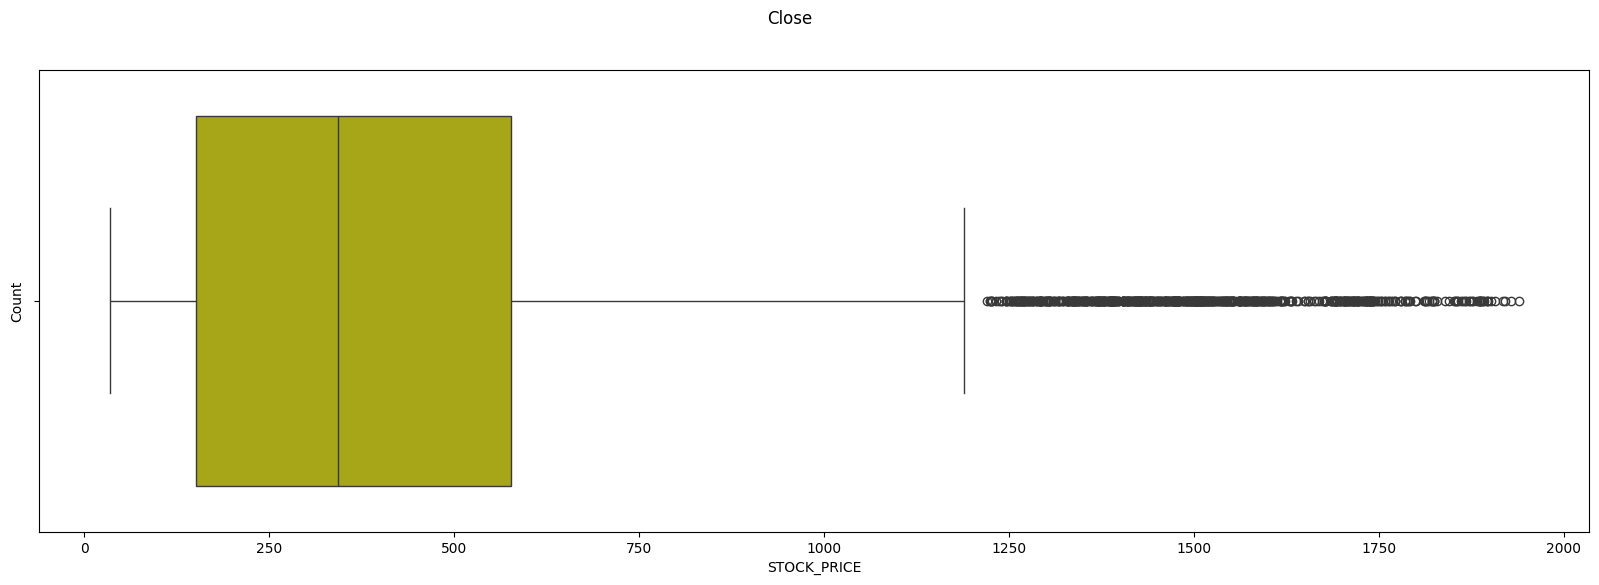

In [23]:
plt.figure(figsize=(20,6))
sns.boxplot(data=stock_data, x='STOCK_PRICE', color='#bebe00')
plt.ylabel('Count')
plt.suptitle('Close')

##### **INFERENCE** #####
1. Since the Mean is greater than the Median the data is "Positively Skewed"
2. IQR=576-151=425
3. The Median is 342
4. There are many outliers between 1250 and 2000

#### *Converting 'DATE' column to Index* ####

In [24]:
stock_data.set_index('DATE',inplace=True)

In [25]:
stock_data

STOCK_PRICE
DATE                   
03-01-2000   122.480469
04-01-2000   132.110931
05-01-2000   121.542191
06-01-2000   111.819138
07-01-2000   102.873825
...                 ...
10-11-2023  1368.699951
13-11-2023  1374.150024
15-11-2023  1411.150024
16-11-2023  1443.900024
17-11-2023  1437.650024

[5922 rows x 1 columns]

In [26]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5922 entries, 03-01-2000 to 17-11-2023
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STOCK_PRICE  5922 non-null   float64
dtypes: float64(1)
memory usage: 92.5+ KB


In [27]:
stock_data

STOCK_PRICE
DATE                   
03-01-2000   122.480469
04-01-2000   132.110931
05-01-2000   121.542191
06-01-2000   111.819138
07-01-2000   102.873825
...                 ...
10-11-2023  1368.699951
13-11-2023  1374.150024
15-11-2023  1411.150024
16-11-2023  1443.900024
17-11-2023  1437.650024

[5922 rows x 1 columns]

In [28]:
stock_data['DATE'] = stock_data.index
stock_data

STOCK_PRICE        DATE
DATE                               
03-01-2000   122.480469  03-01-2000
04-01-2000   132.110931  04-01-2000
05-01-2000   121.542191  05-01-2000
06-01-2000   111.819138  06-01-2000
07-01-2000   102.873825  07-01-2000
...                 ...         ...
10-11-2023  1368.699951  10-11-2023
13-11-2023  1374.150024  13-11-2023
15-11-2023  1411.150024  15-11-2023
16-11-2023  1443.900024  16-11-2023
17-11-2023  1437.650024  17-11-2023

[5922 rows x 2 columns]

##### **INFERENCE** #####
- As we can see here DATE is showing as 'object' i.e. a string type.
- We need to convert this to datetime format

#### *Converting 'DATE' column datetime format* ####

In [29]:
stock_data['DATE'] = pd.to_datetime(stock_data['DATE'],format='%d-%m-%Y')

In [30]:
stock_data["DATE"].info()

<class 'pandas.core.series.Series'>
Index: 5922 entries, 03-01-2000 to 17-11-2023
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
5922 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 92.5+ KB


#### **VISUALIZATIONS** ####

In [31]:
stock_data["MONTH"] = stock_data.DATE.dt.strftime("%b") # month extraction
stock_data["YEAR"] = stock_data.DATE.dt.strftime("%Y") # year extraction
stock_data["YEAR-MONTH"] = stock_data.DATE.dt.strftime("%Y-%m")
stock_data_bak = stock_data.copy()
stock_data

STOCK_PRICE       DATE MONTH  YEAR YEAR-MONTH
DATE                                                     
03-01-2000   122.480469 2000-01-03   Jan  2000    2000-01
04-01-2000   132.110931 2000-01-04   Jan  2000    2000-01
05-01-2000   121.542191 2000-01-05   Jan  2000    2000-01
06-01-2000   111.819138 2000-01-06   Jan  2000    2000-01
07-01-2000   102.873825 2000-01-07   Jan  2000    2000-01
...                 ...        ...   ...   ...        ...
10-11-2023  1368.699951 2023-11-10   Nov  2023    2023-11
13-11-2023  1374.150024 2023-11-13   Nov  2023    2023-11
15-11-2023  1411.150024 2023-11-15   Nov  2023    2023-11
16-11-2023  1443.900024 2023-11-16   Nov  2023    2023-11
17-11-2023  1437.650024 2023-11-17   Nov  2023    2023-11

[5922 rows x 5 columns]

In [32]:
def replace_outlier(df_in, col_name):
    Q1 = df_in[col_name].quantile(0.25)
    Q3 = df_in[col_name].quantile(0.75)
    IQR = Q3 - Q1 # Interquartile range
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR
    median_val = df_in[col_name].median()
    df_out = df_in.copy()
    for i, j in df_in.iterrows():
        if (j[col_name] > upper):
            df_out.at[i, col_name] = upper
        elif (j[col_name] < lower):
            df_out.at[i, col_name] = lower
        else:
            df_out.at[i, col_name] = df_out.at[i, col_name]
    return df_out

In [33]:
def check_outliers(df_in, col_name):
    Q1 = df_in[col_name].quantile(0.25)
    Q3 = df_in[col_name].quantile(0.75)
    IQR = Q3 - Q1 # Interquartile range
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR
    outliers = False
    for i, j in df_in.iterrows():
        if (j[col_name] > upper):
            outliers = True
        elif (j[col_name] < lower):
            outliers = True
    return outliers

In [34]:
ym_periods = stock_data['YEAR-MONTH'].unique()
ym_periods
for ym in ym_periods:
    temp_s_data = stock_data.groupby(['YEAR-MONTH']).get_group(ym)
    col_name = 'STOCK_PRICE'
    for i in range(1, 50):
        if (check_outliers(temp_s_data, col_name) == True):
            stock_data_out = replace_outlier(temp_s_data, col_name)
            stock_data_bak = stock_data_bak.set_index('DATE')
            stock_data_out = stock_data_out.set_index('DATE')
            stock_data_bak.update(stock_data_out)
            stock_data_bak.reset_index(inplace=True)

In [35]:
stock_data_bak.set_index('DATE',inplace=True)
stock_data_bak['DATE'] = pd.to_datetime(stock_data_bak.index,format='%Y-%m-%d')
stock_data_bak

STOCK_PRICE MONTH  YEAR YEAR-MONTH       DATE
DATE                                                     
2000-01-03   122.480469   Jan  2000    2000-01 2000-01-03
2000-01-04   132.110931   Jan  2000    2000-01 2000-01-04
2000-01-05   121.542191   Jan  2000    2000-01 2000-01-05
2000-01-06   111.819138   Jan  2000    2000-01 2000-01-06
2000-01-07   102.873825   Jan  2000    2000-01 2000-01-07
...                 ...   ...   ...        ...        ...
2023-11-10  1368.699951   Nov  2023    2023-11 2023-11-10
2023-11-13  1374.150024   Nov  2023    2023-11 2023-11-13
2023-11-15  1411.150024   Nov  2023    2023-11 2023-11-15
2023-11-16  1443.900024   Nov  2023    2023-11 2023-11-16
2023-11-17  1437.650024   Nov  2023    2023-11 2023-11-17

[5922 rows x 5 columns]

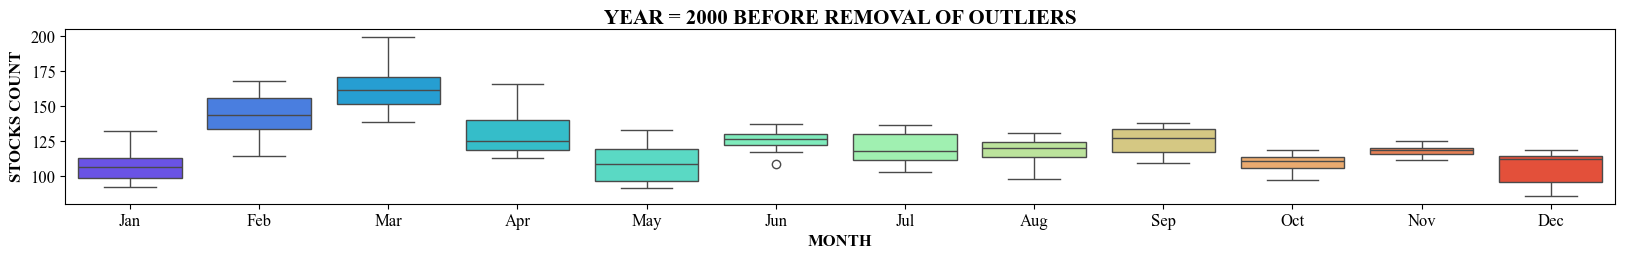

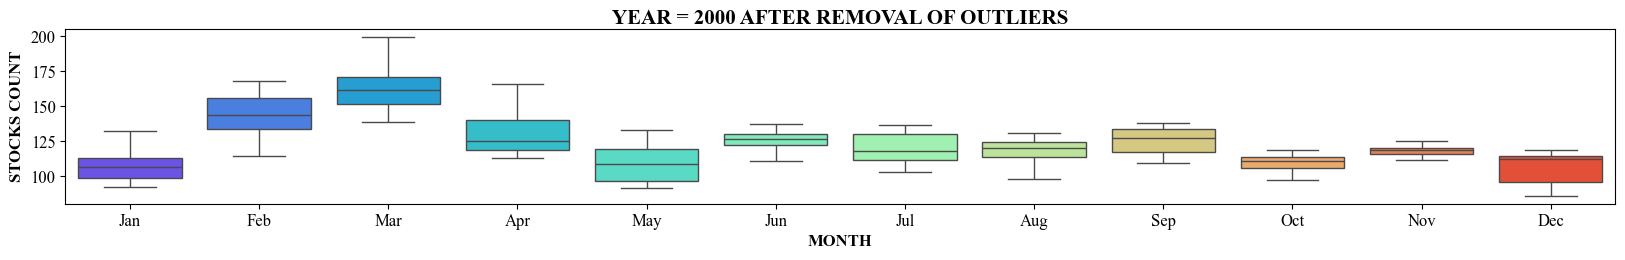

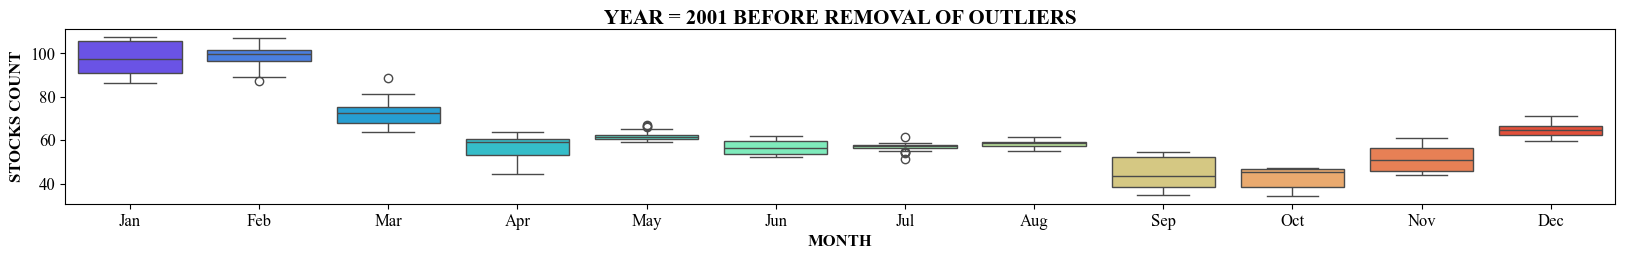

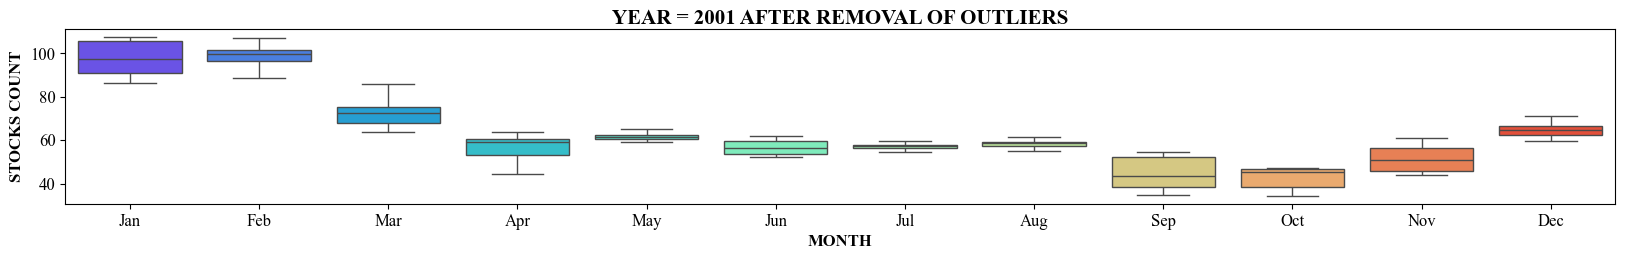

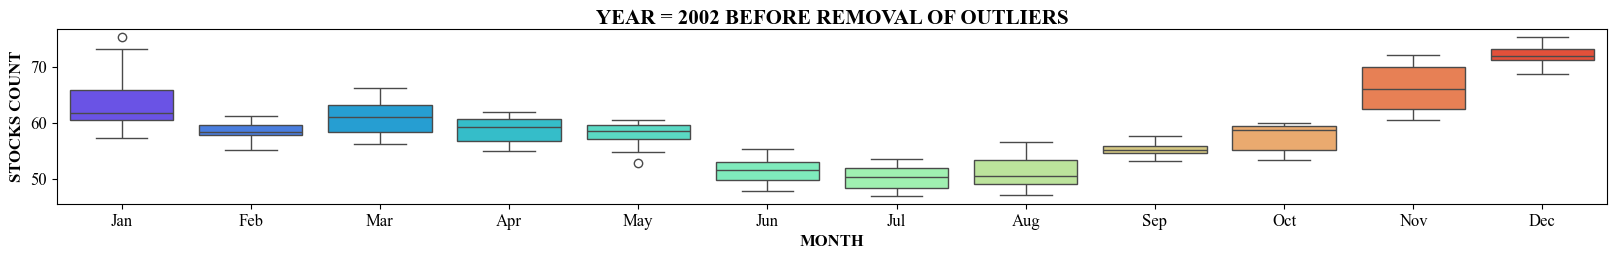

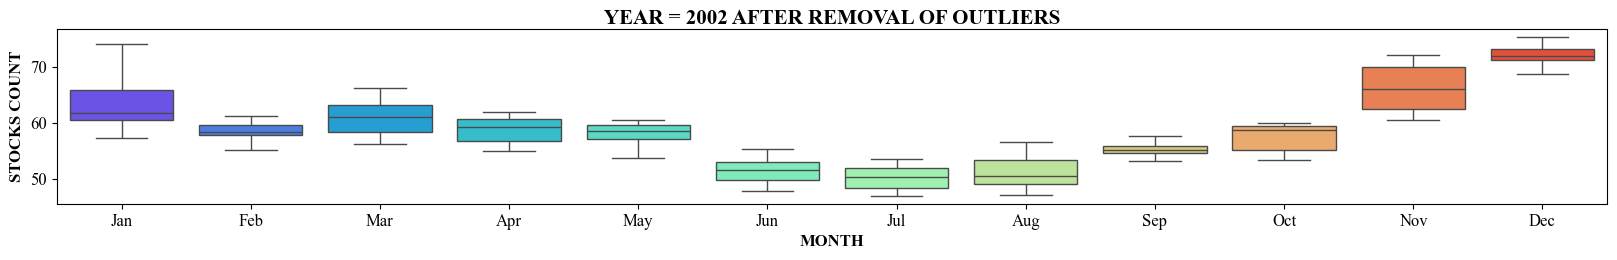

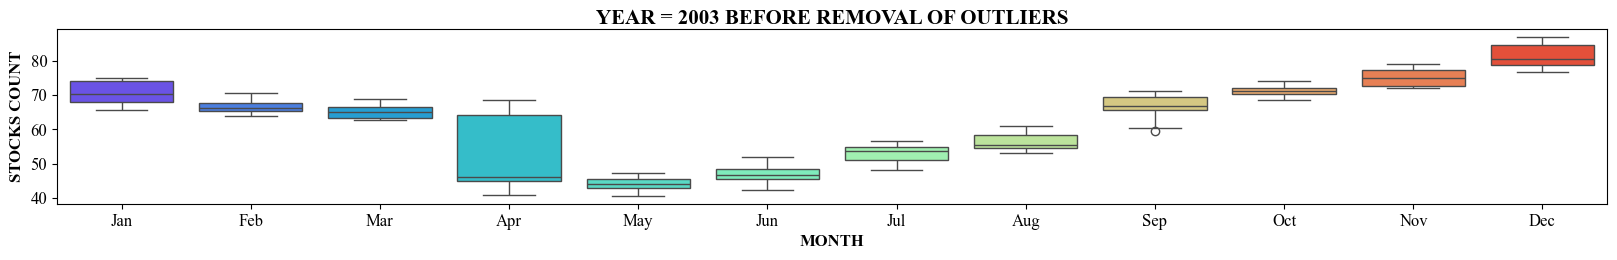

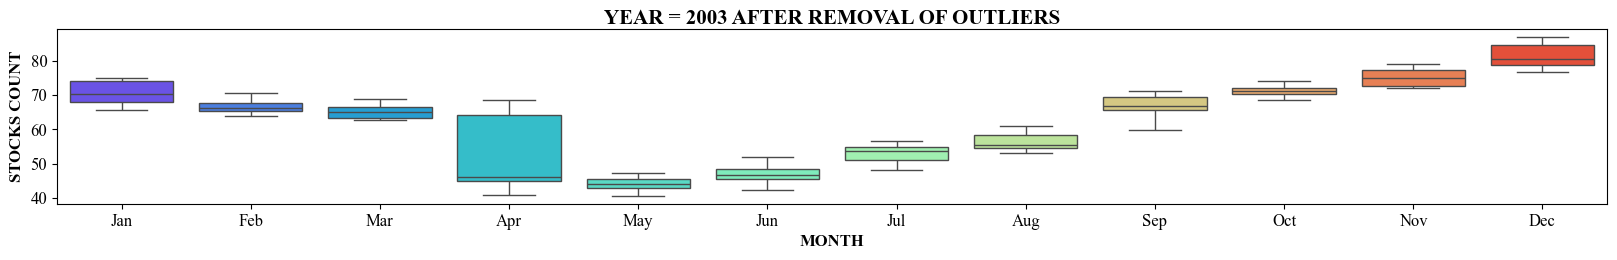

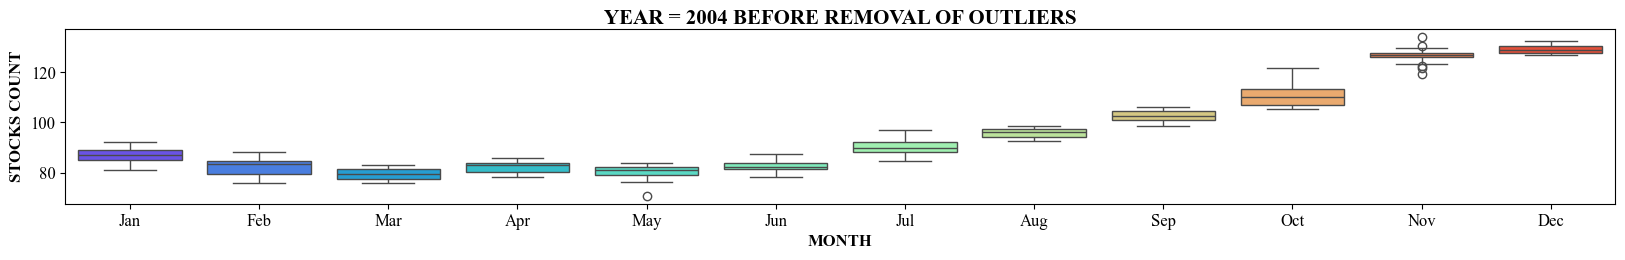

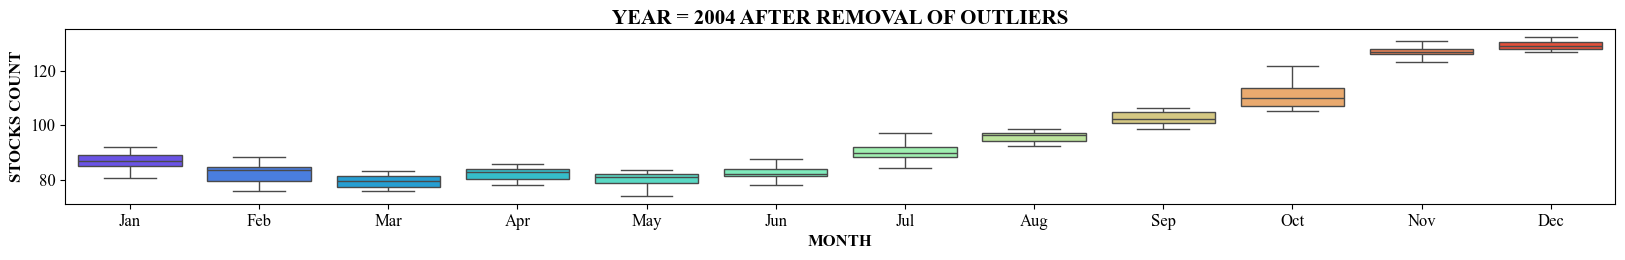

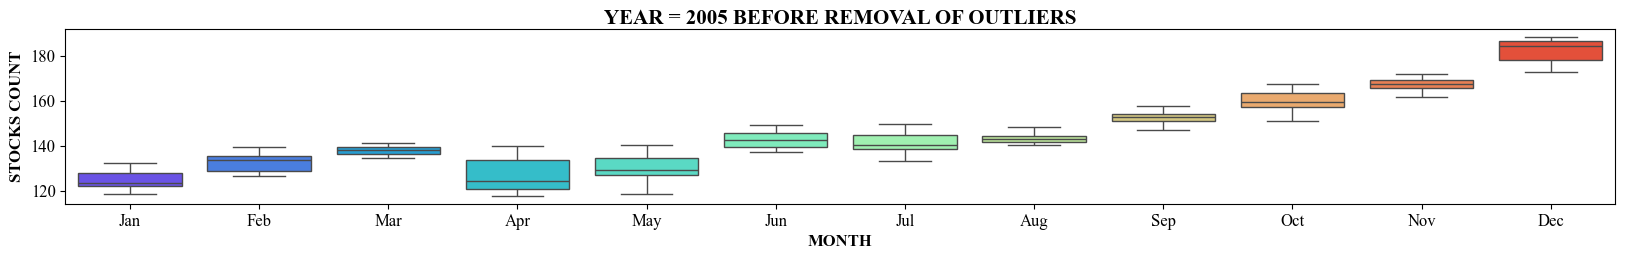

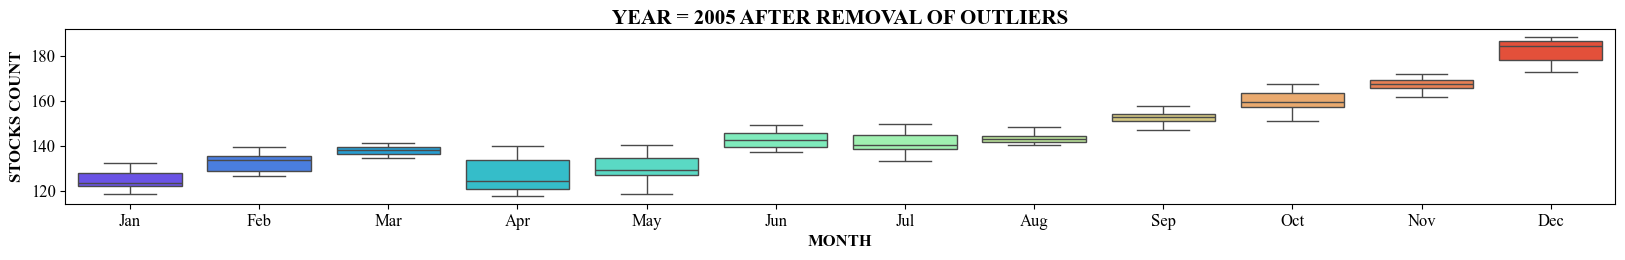

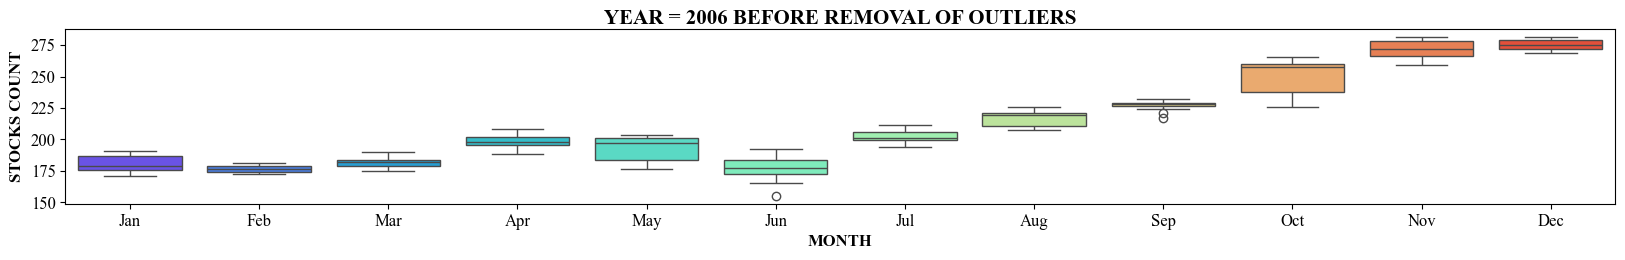

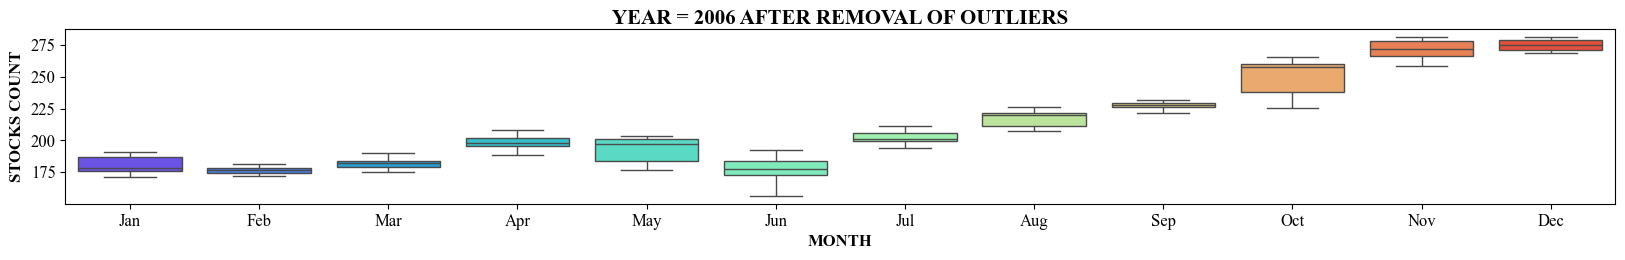

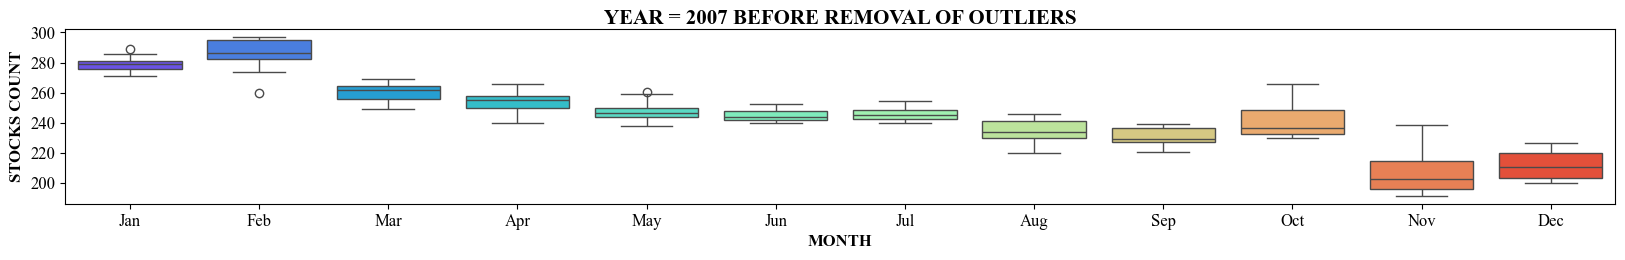

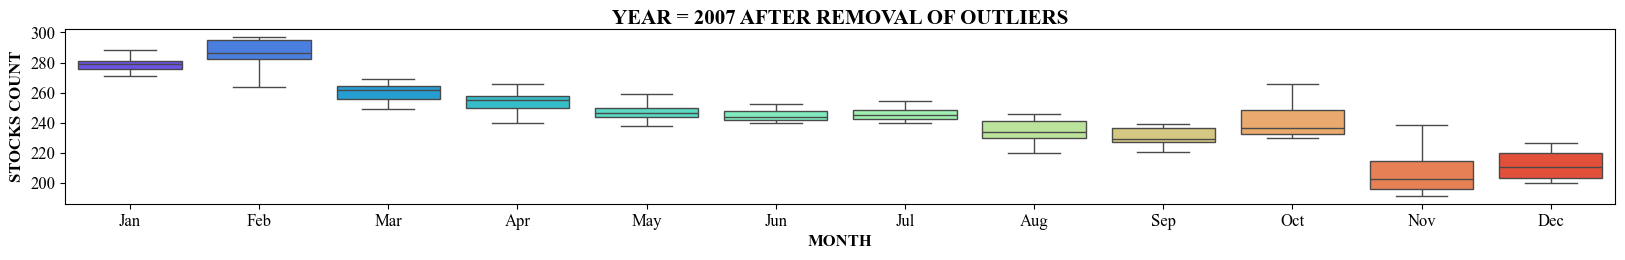

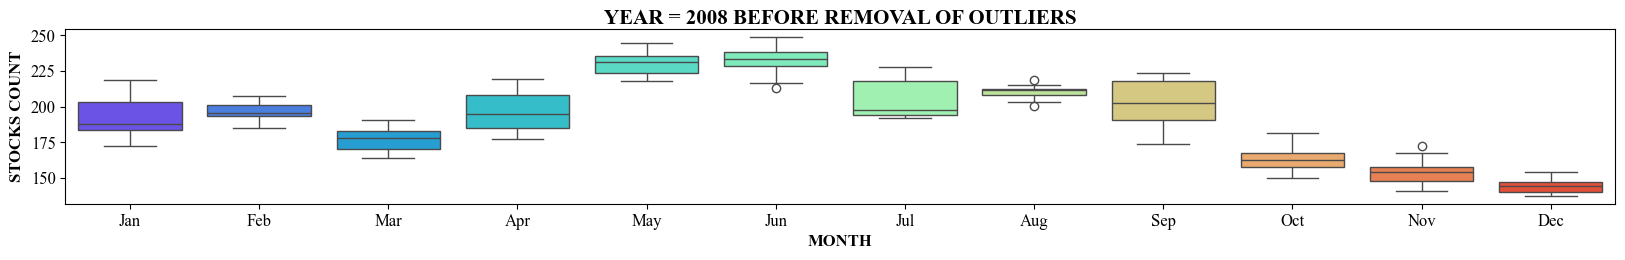

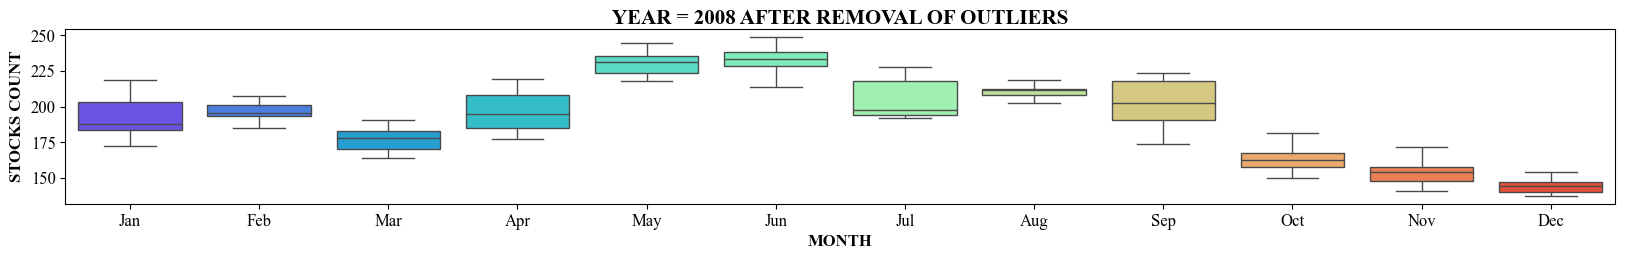

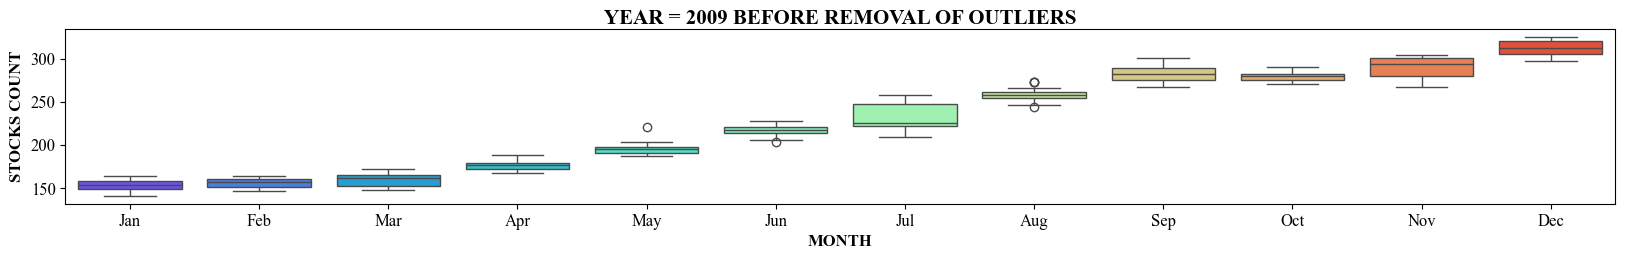

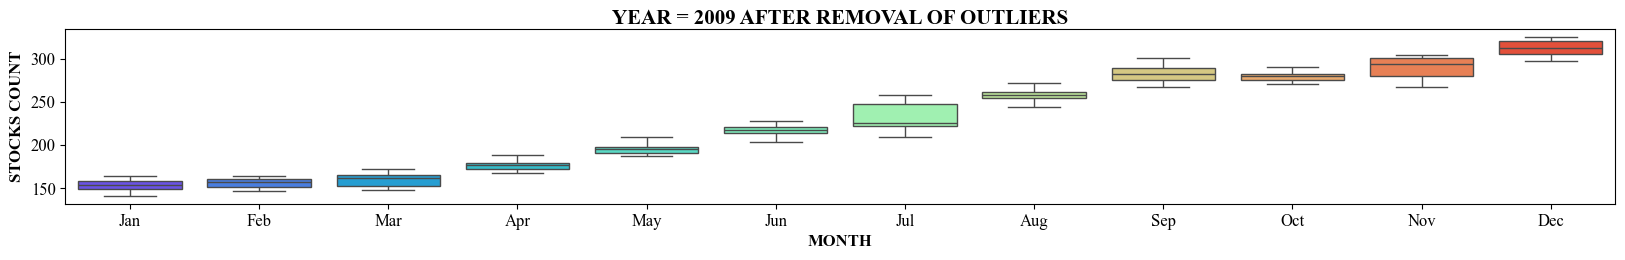

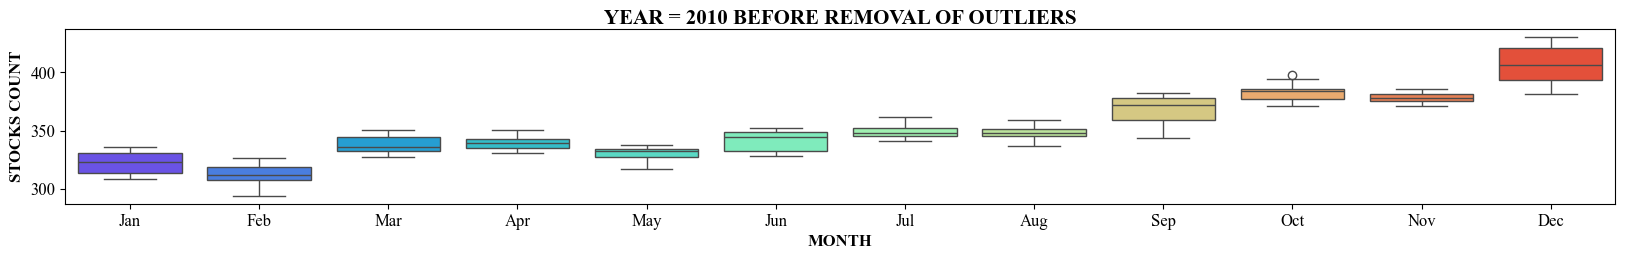

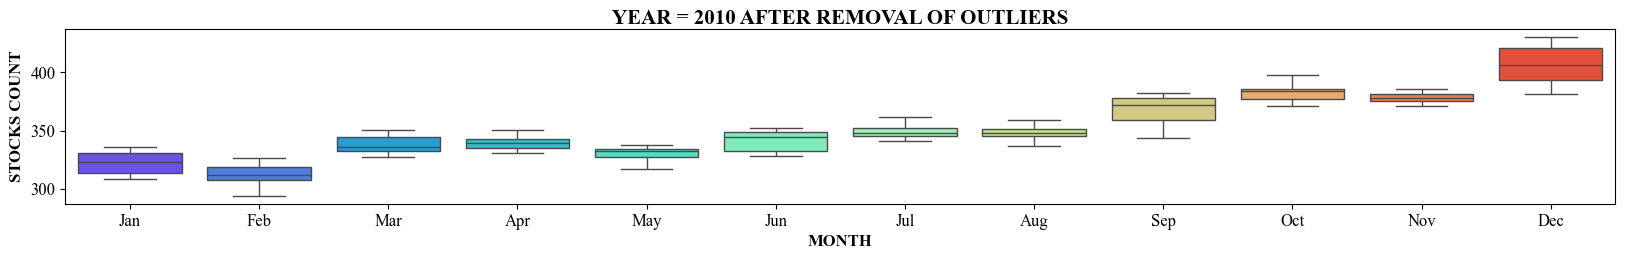

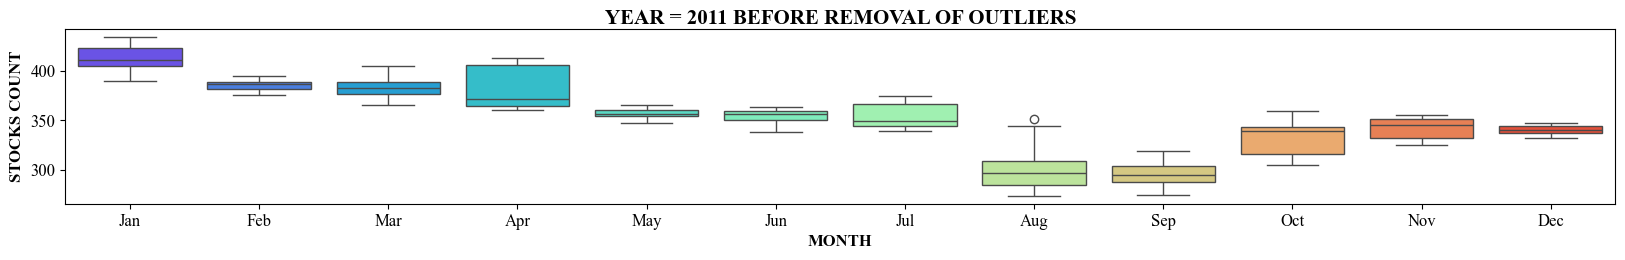

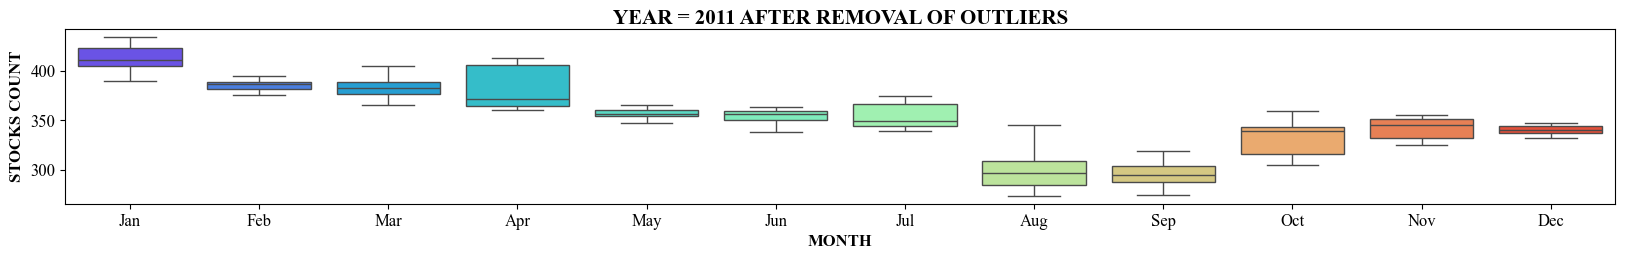

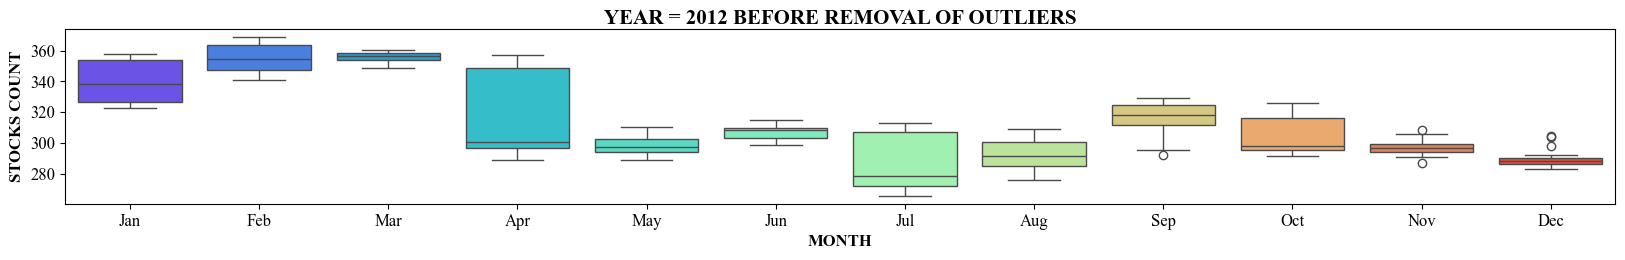

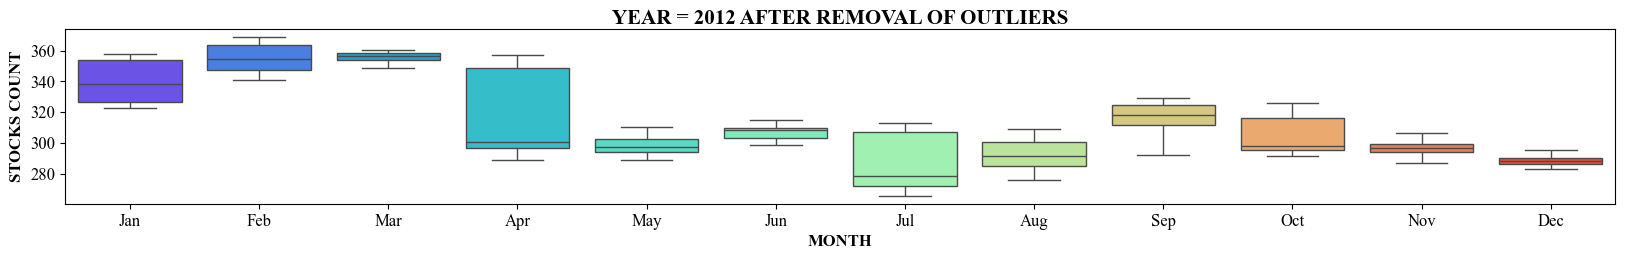

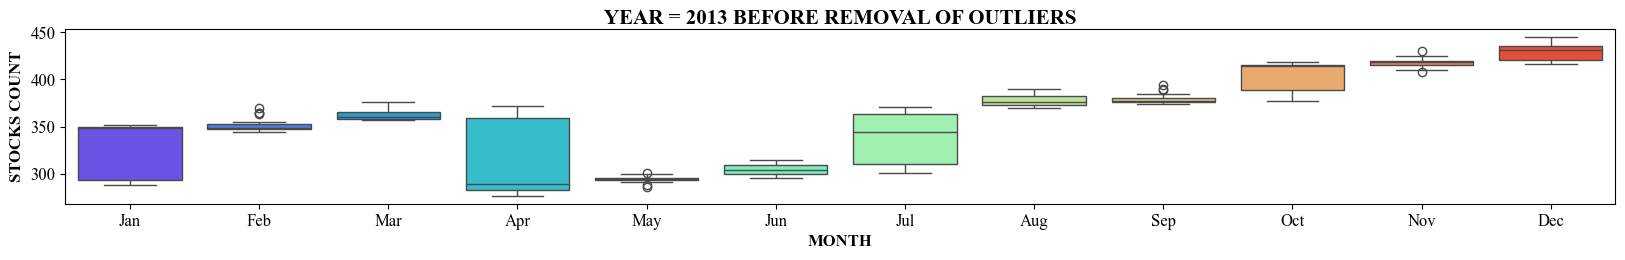

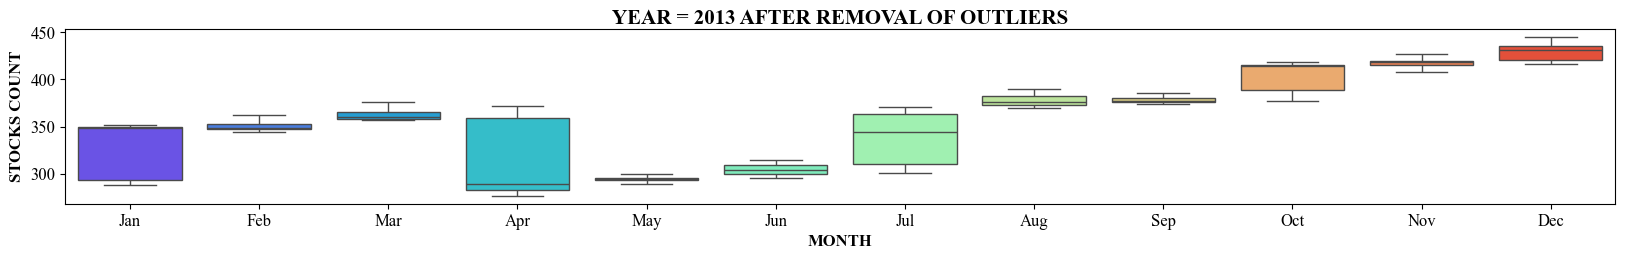

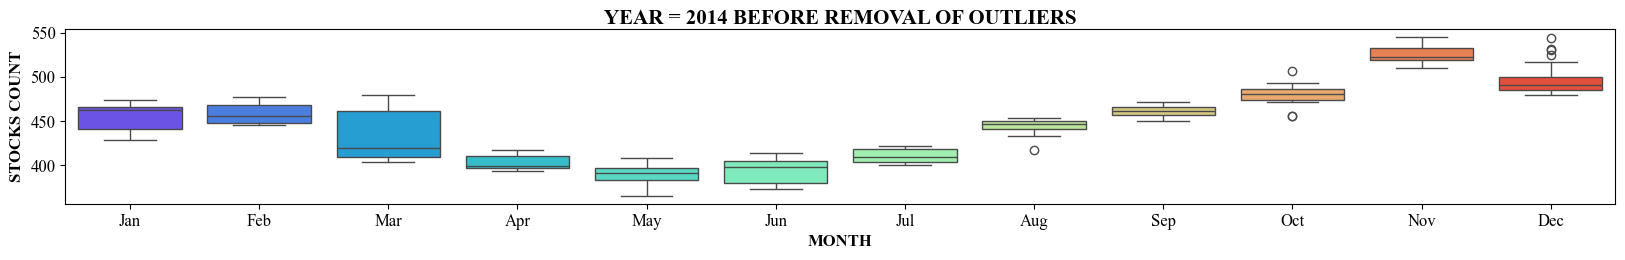

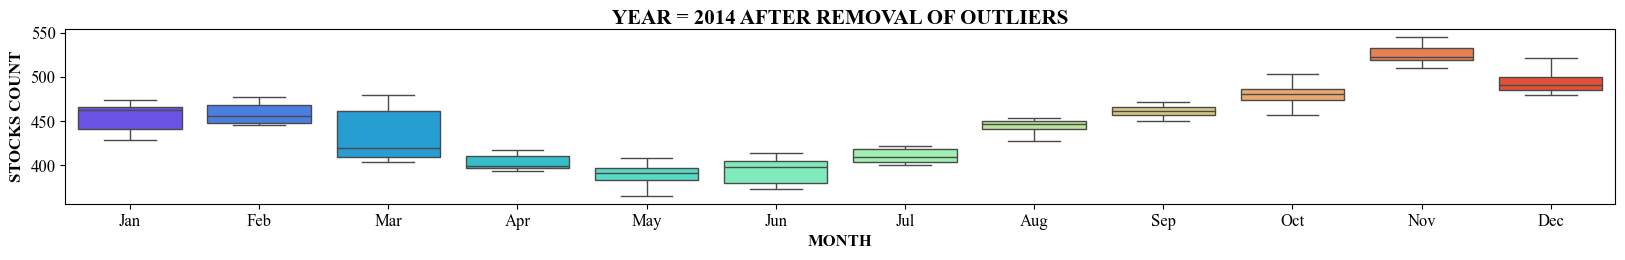

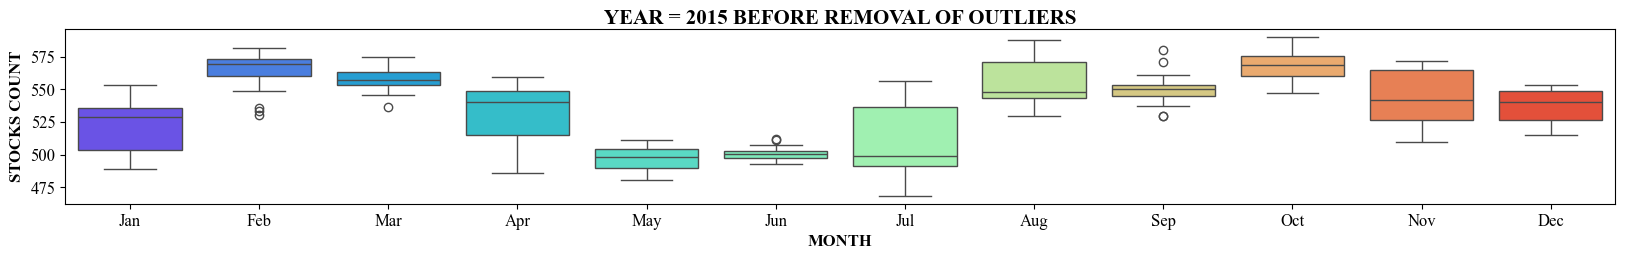

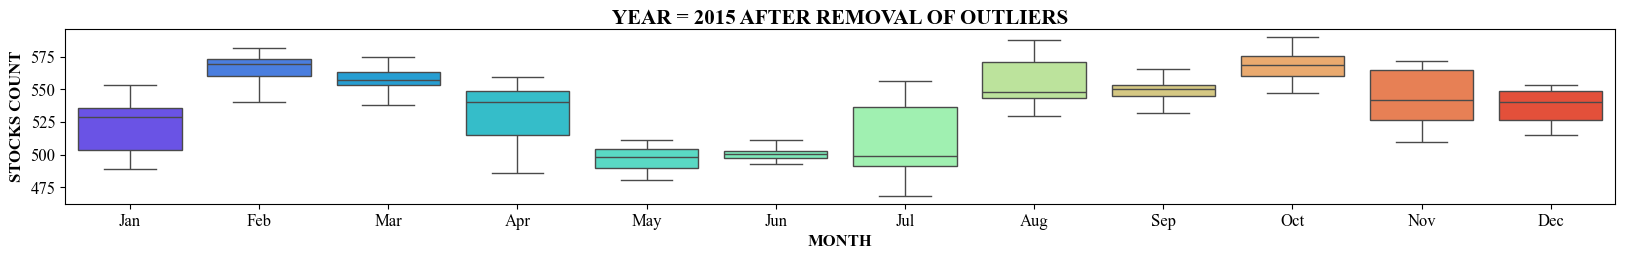

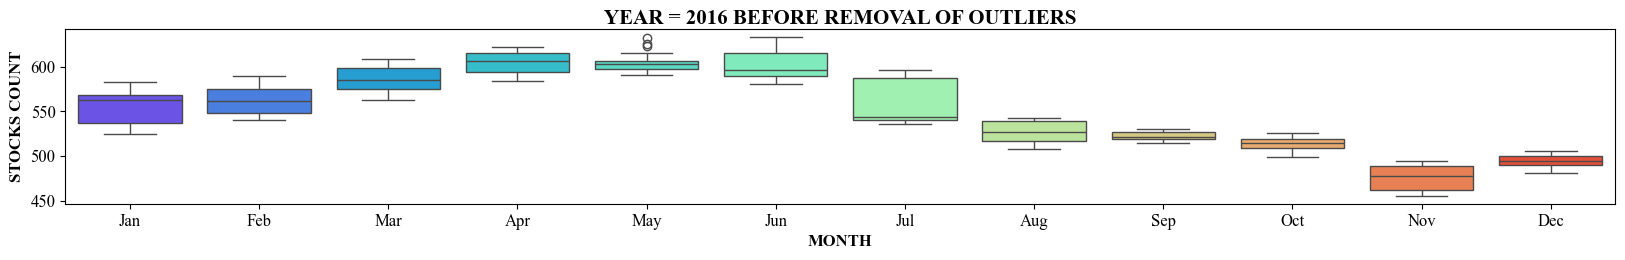

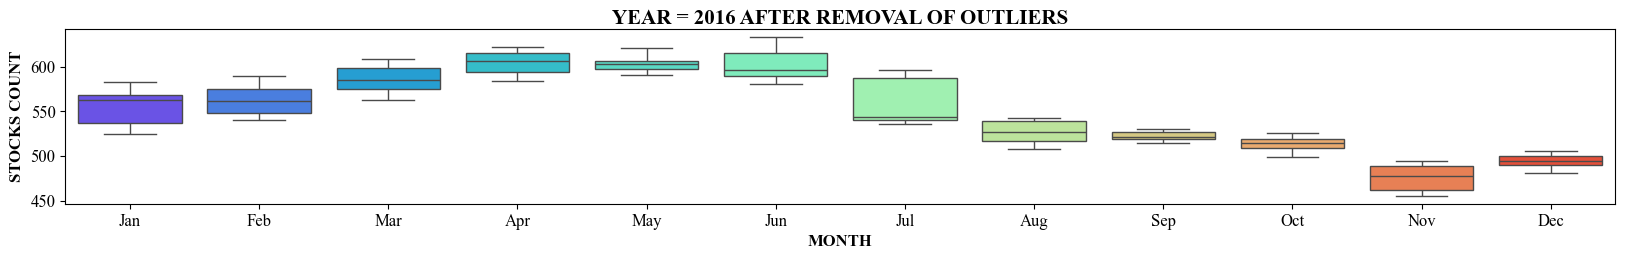

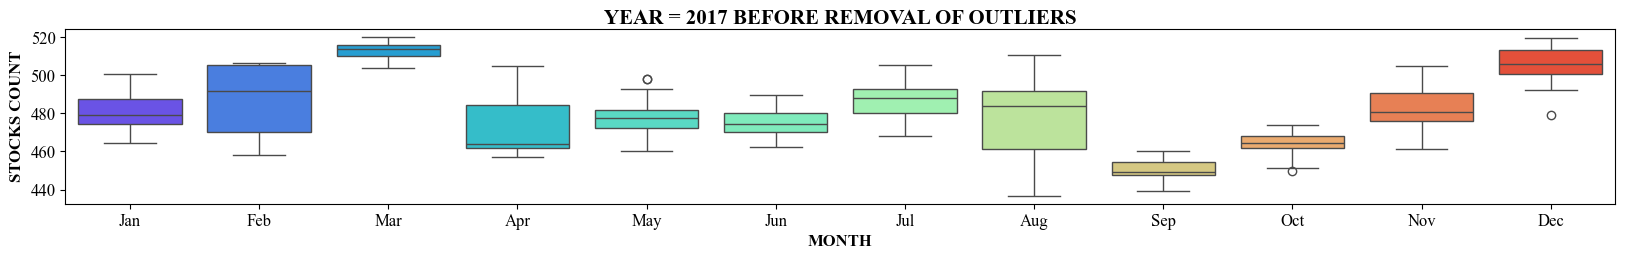

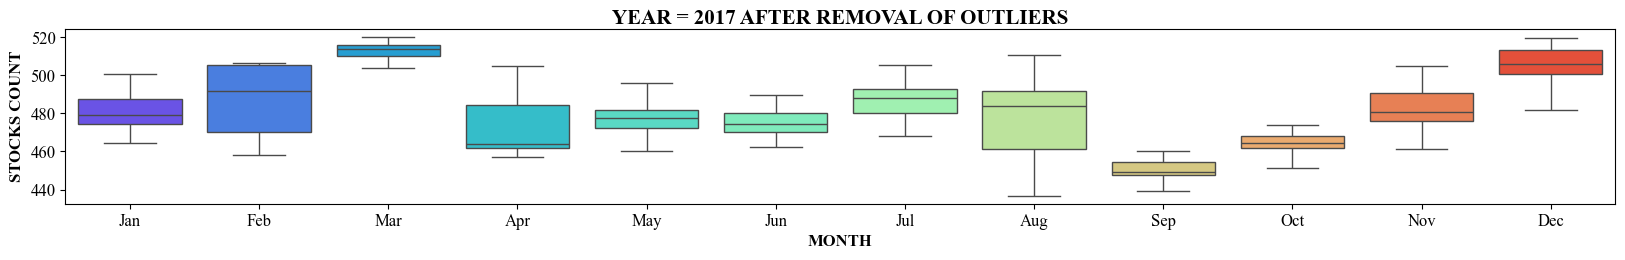

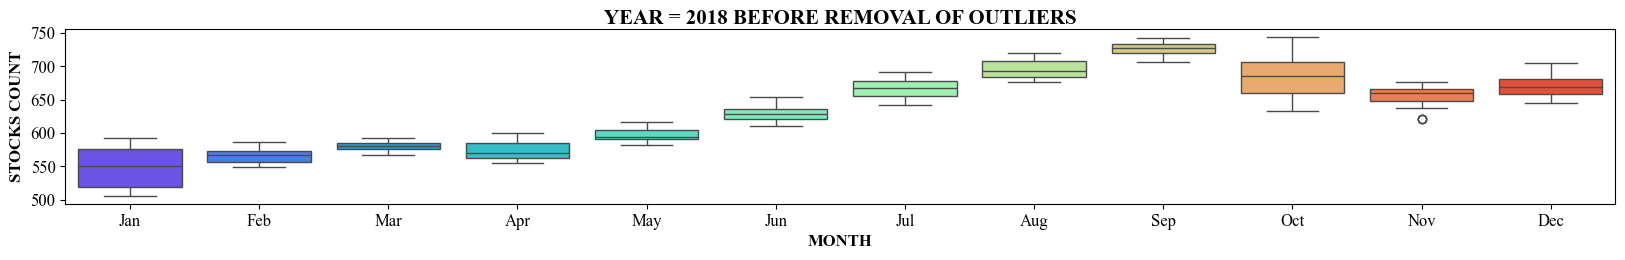

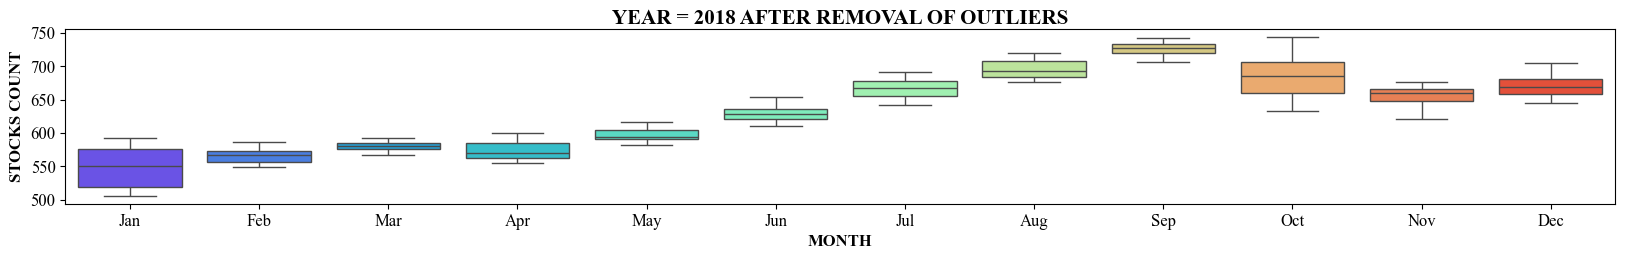

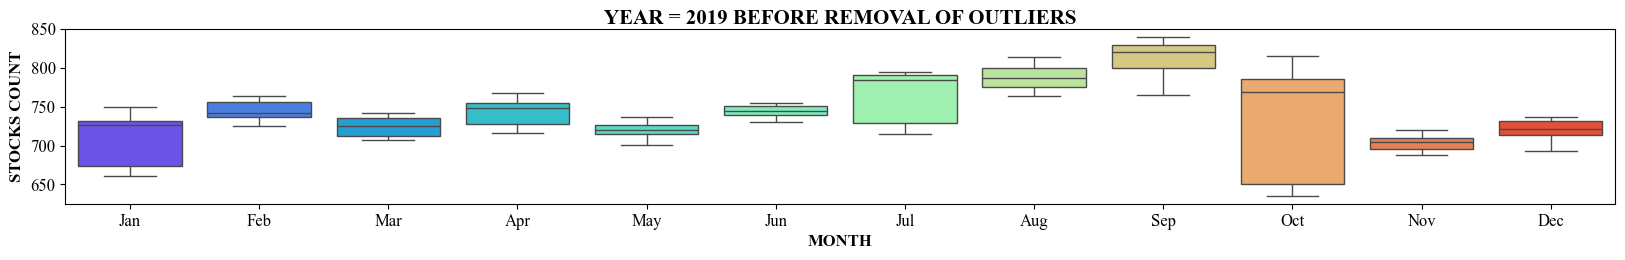

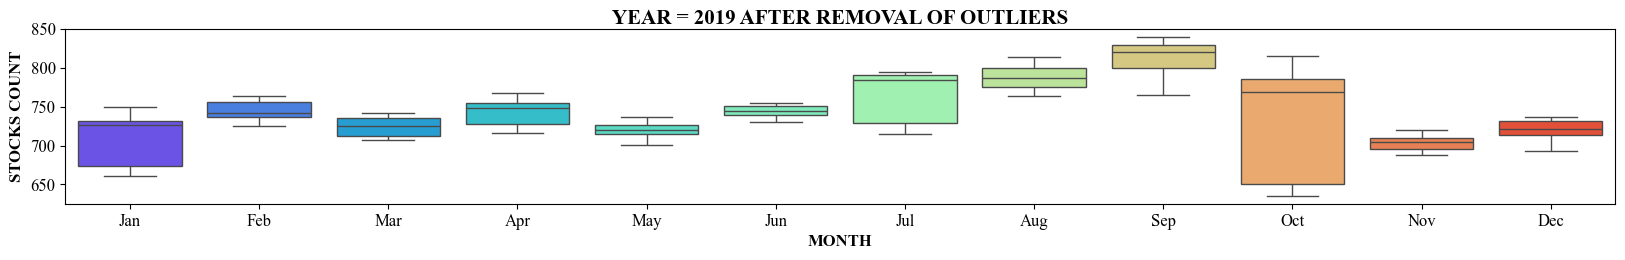

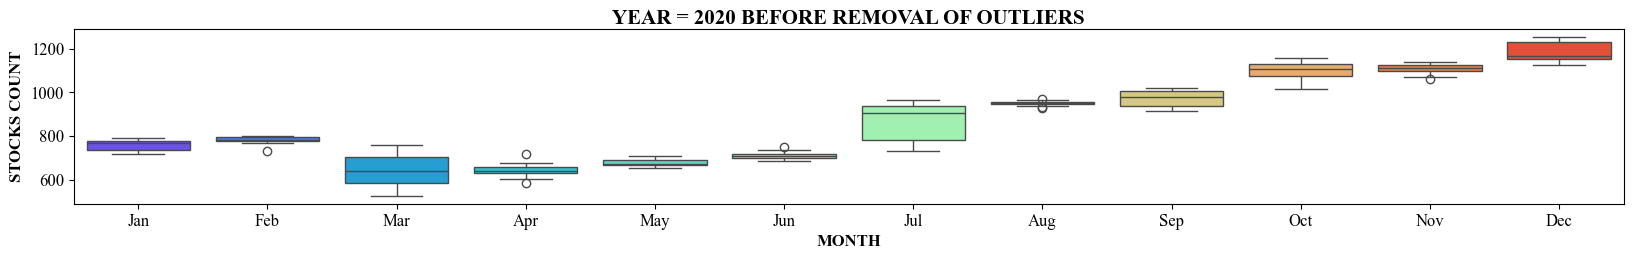

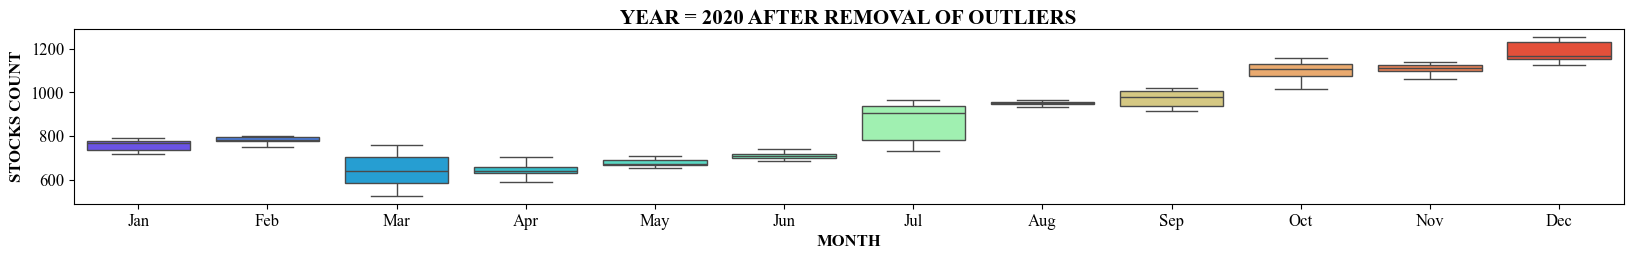

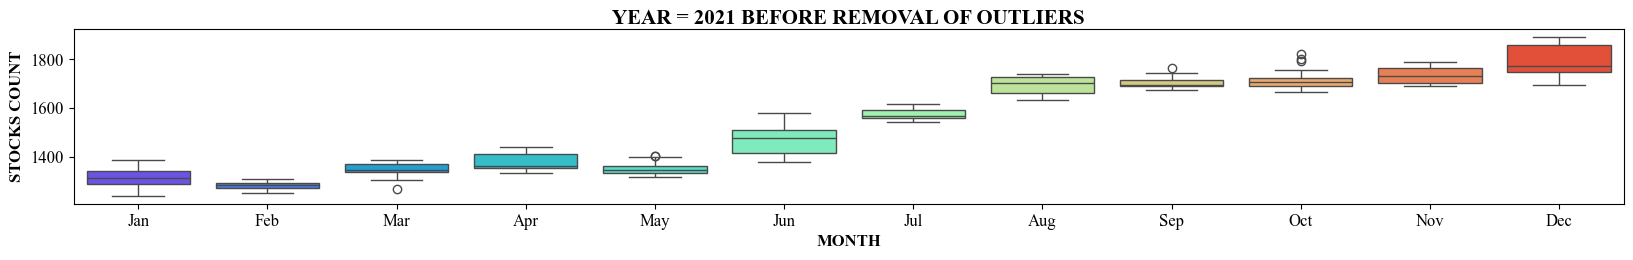

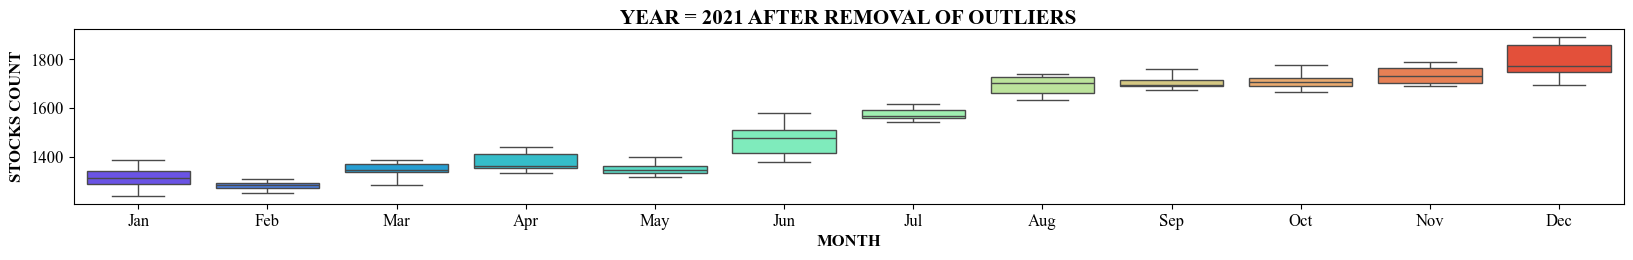

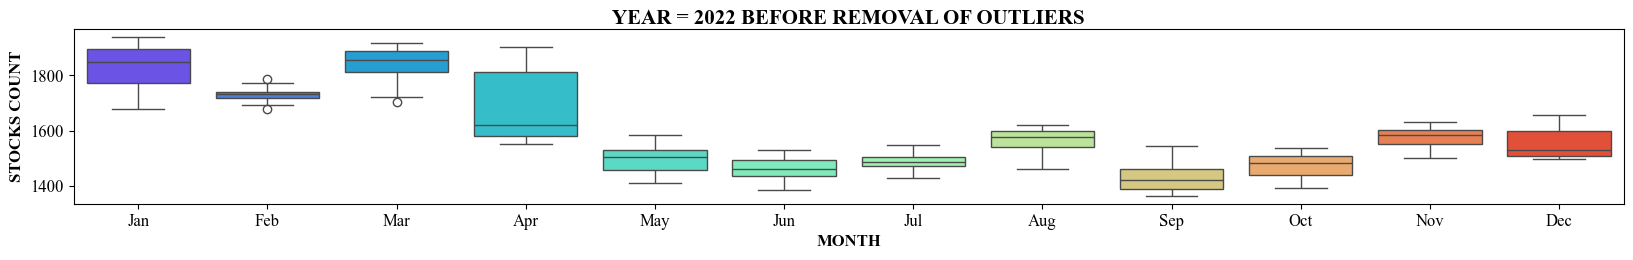

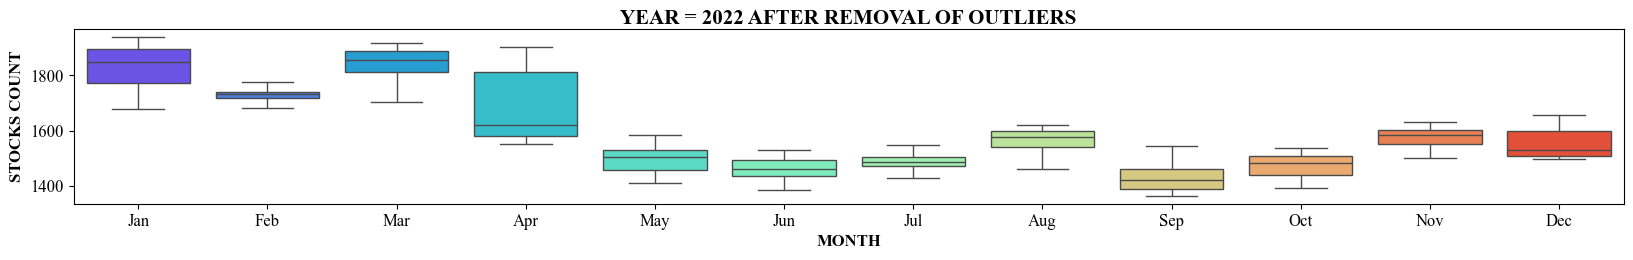

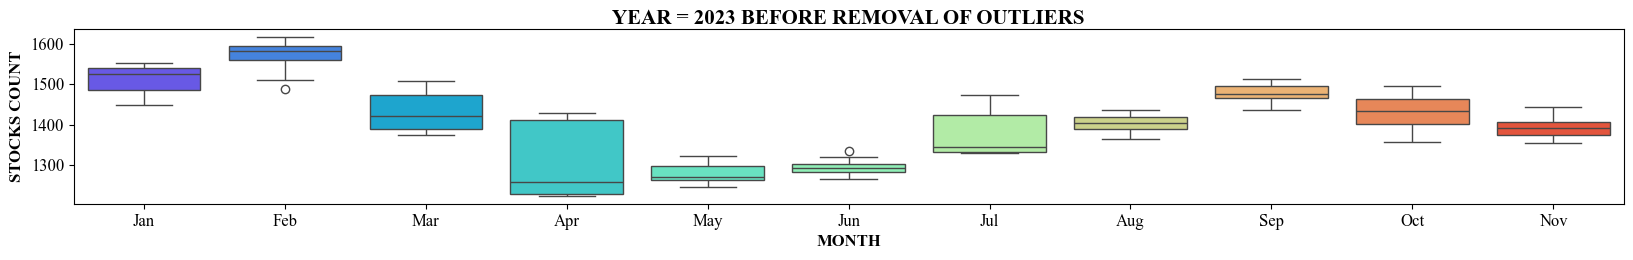

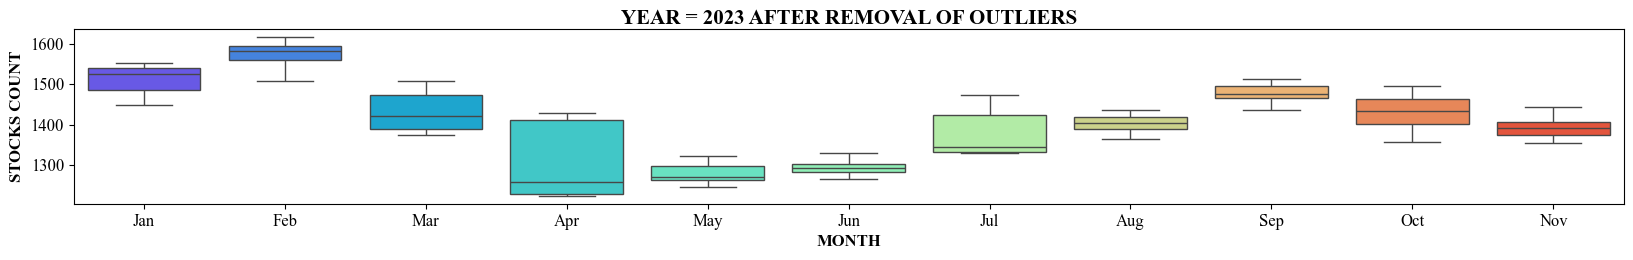

In [36]:
import datetime as dt

year = stock_data['YEAR'].unique()
year

for y in year:
    stock_data['DATE'] = pd.to_datetime(stock_data['DATE'])
    # stock_data['DATE']
    temp_data = stock_data[stock_data.DATE.dt.strftime("%Y") == y]

    
    
    # Boxplot for Year Data
    plt.figure(figsize=(20,5))
    plt.subplot(211)
    sns.boxplot(x="MONTH",y="STOCK_PRICE",data=temp_data, palette="rainbow")
    plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.xlabel("MONTH", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.ylabel("STOCKS COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.title("YEAR = " + str(y) + " BEFORE REMOVAL OF OUTLIERS", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '15')
    plt.show()


    stock_data_bak['DATE'] = pd.to_datetime(stock_data_bak['DATE'])
    temp_data_bak = stock_data_bak[stock_data_bak.DATE.dt.strftime("%Y") == y]

    # Boxplot for Year Data
    plt.figure(figsize=(20,5))
    plt.subplot(211)
    sns.boxplot(x="MONTH",y="STOCK_PRICE",data=temp_data_bak, palette="rainbow")
    plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.xlabel("MONTH", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.ylabel("STOCKS COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.title("YEAR = " + str(y) + " AFTER REMOVAL OF OUTLIERS", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '15')
    plt.show()    

##### **INFERENCE** #####
**We have been able to impute the outliers using the function to substitute the outliers with the upper/lower limit values**
1. The before year graph shows the monthly outliers before imputation.
2. The after year graph shows the monthly outliers after imputation.
3. Now we see that all outliers have been fixed and don't see any outliers.

In [37]:
stock_data = stock_data_bak.copy()

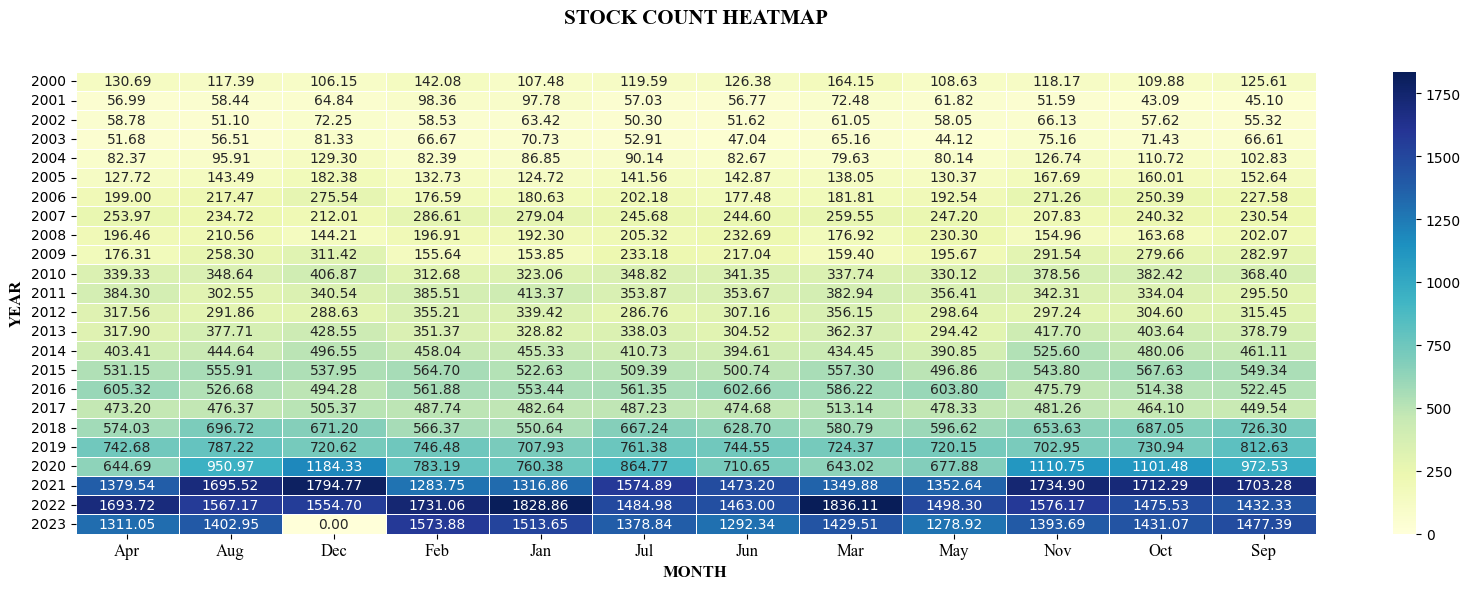

In [38]:
plt.figure(figsize=(20,6))
hm_month = pd.pivot_table(data=stock_data,values="STOCK_PRICE",index="YEAR",columns="MONTH",aggfunc="mean",fill_value=0)
sns.heatmap(hm_month, annot=True, linewidths =.5, fmt ='.2f',cmap="YlGnBu")
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("MONTH", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("YEAR", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.title("STOCK COUNT HEATMAP\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '15')
plt.show()


##### **INFERENCE** #####
1. In March 2022 the stock price was the "Highest".
2. In May 2003 the stock price was the "Lowest".

*Line Chart*

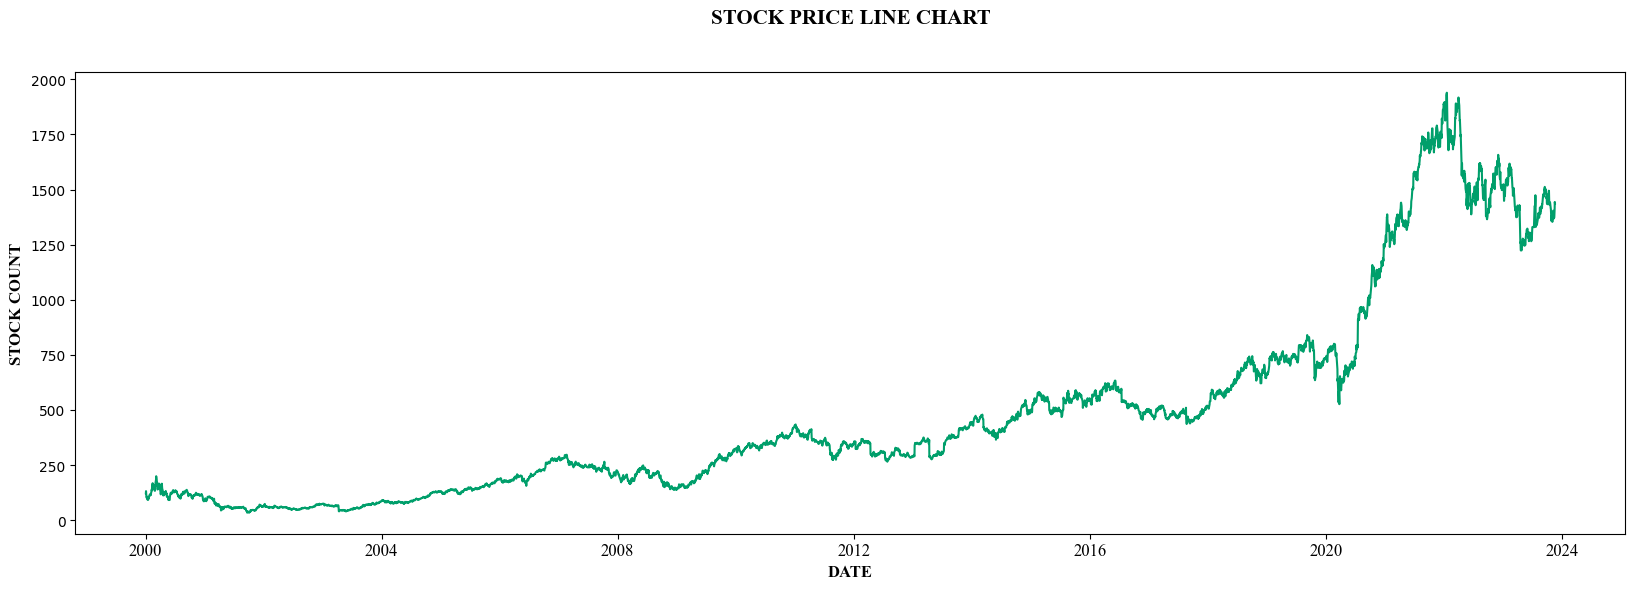

In [39]:
plt.figure(figsize=(20,6))
hm_month = pd.pivot_table(data=stock_data,values="STOCK_PRICE",index="YEAR",columns="MONTH",aggfunc="mean",fill_value=0)
sns.lineplot(x="DATE", y="STOCK_PRICE", marker="o", color="#009f6b", data=stock_data, markersize=0, markerfacecolor='purple')
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("DATE", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("STOCK COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.title("STOCK PRICE LINE CHART\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '15')
plt.show()

##### **INFERENCE** #####
Based on this graph, we can see that there is an increasing/postive trend and there is no seasonality.

In [40]:
stock_data.head()

stock_data['STOCK_DIFF'] = stock_data['STOCK_PRICE'].diff(periods=1)
stock_data

STOCK_PRICE MONTH  YEAR YEAR-MONTH       DATE  STOCK_DIFF
DATE                                                                 
2000-01-03   122.480469   Jan  2000    2000-01 2000-01-03         NaN
2000-01-04   132.110931   Jan  2000    2000-01 2000-01-04    9.630462
2000-01-05   121.542191   Jan  2000    2000-01 2000-01-05  -10.568740
2000-01-06   111.819138   Jan  2000    2000-01 2000-01-06   -9.723053
2000-01-07   102.873825   Jan  2000    2000-01 2000-01-07   -8.945313
...                 ...   ...   ...        ...        ...         ...
2023-11-10  1368.699951   Nov  2023    2023-11 2023-11-10   -6.450073
2023-11-13  1374.150024   Nov  2023    2023-11 2023-11-13    5.450073
2023-11-15  1411.150024   Nov  2023    2023-11 2023-11-15   37.000000
2023-11-16  1443.900024   Nov  2023    2023-11 2023-11-16   32.750000
2023-11-17  1437.650024   Nov  2023    2023-11 2023-11-17   -6.250000

[5922 rows x 6 columns]

In [41]:
stock_data = stock_data.dropna()
stock_data

STOCK_PRICE MONTH  YEAR YEAR-MONTH       DATE  STOCK_DIFF
DATE                                                                 
2000-01-04   132.110931   Jan  2000    2000-01 2000-01-04    9.630462
2000-01-05   121.542191   Jan  2000    2000-01 2000-01-05  -10.568740
2000-01-06   111.819138   Jan  2000    2000-01 2000-01-06   -9.723053
2000-01-07   102.873825   Jan  2000    2000-01 2000-01-07   -8.945313
2000-01-10   107.031250   Jan  2000    2000-01 2000-01-10    4.157425
...                 ...   ...   ...        ...        ...         ...
2023-11-10  1368.699951   Nov  2023    2023-11 2023-11-10   -6.450073
2023-11-13  1374.150024   Nov  2023    2023-11 2023-11-13    5.450073
2023-11-15  1411.150024   Nov  2023    2023-11 2023-11-15   37.000000
2023-11-16  1443.900024   Nov  2023    2023-11 2023-11-16   32.750000
2023-11-17  1437.650024   Nov  2023    2023-11 2023-11-17   -6.250000

[5921 rows x 6 columns]

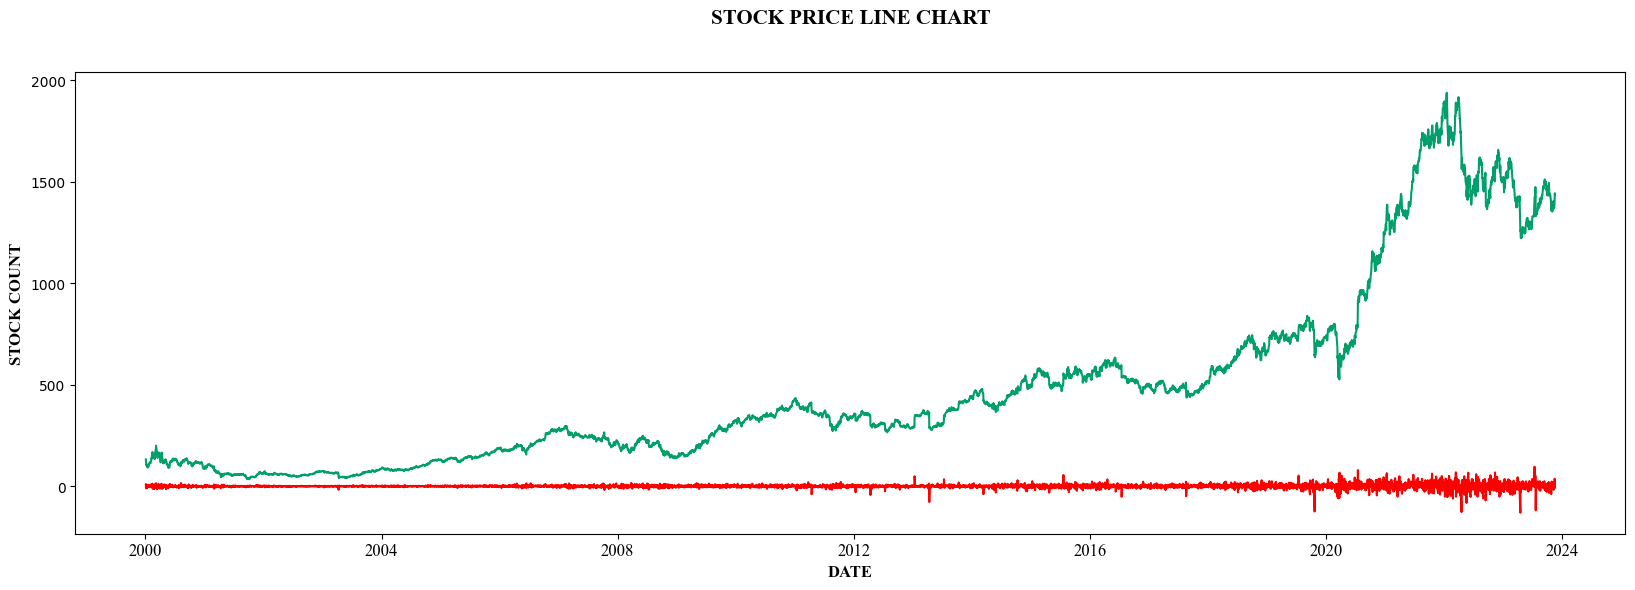

In [42]:
plt.figure(figsize=(20,6))
hm_month = pd.pivot_table(data=stock_data,values="STOCK_PRICE",index="YEAR",columns="MONTH",aggfunc="mean",fill_value=0)
sns.lineplot(x="DATE", y="STOCK_PRICE", marker="o", color="#009f6b", data=stock_data, markersize=0, markerfacecolor='purple')
sns.lineplot(x="DATE", y="STOCK_DIFF", marker="o", color="#FF0000", data=stock_data, markersize=0, markerfacecolor='purple')
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("DATE", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("STOCK COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.title("STOCK PRICE LINE CHART\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '15')
plt.show()

##### **INFERENCE** #####
1. The Green line plot shows the stock prices of INFOSYS as a positive non-seasonal trend line across time.
2. We have converted the non-stationary data to stationary using the method difference. The Red line plot shows the stock prices of INFOSYS as Stationary and we have removed the trend.

In [43]:
stock_data

STOCK_PRICE MONTH  YEAR YEAR-MONTH       DATE  STOCK_DIFF
DATE                                                                 
2000-01-04   132.110931   Jan  2000    2000-01 2000-01-04    9.630462
2000-01-05   121.542191   Jan  2000    2000-01 2000-01-05  -10.568740
2000-01-06   111.819138   Jan  2000    2000-01 2000-01-06   -9.723053
2000-01-07   102.873825   Jan  2000    2000-01 2000-01-07   -8.945313
2000-01-10   107.031250   Jan  2000    2000-01 2000-01-10    4.157425
...                 ...   ...   ...        ...        ...         ...
2023-11-10  1368.699951   Nov  2023    2023-11 2023-11-10   -6.450073
2023-11-13  1374.150024   Nov  2023    2023-11 2023-11-13    5.450073
2023-11-15  1411.150024   Nov  2023    2023-11 2023-11-15   37.000000
2023-11-16  1443.900024   Nov  2023    2023-11 2023-11-16   32.750000
2023-11-17  1437.650024   Nov  2023    2023-11 2023-11-17   -6.250000

[5921 rows x 6 columns]

*YEARLY TREND*

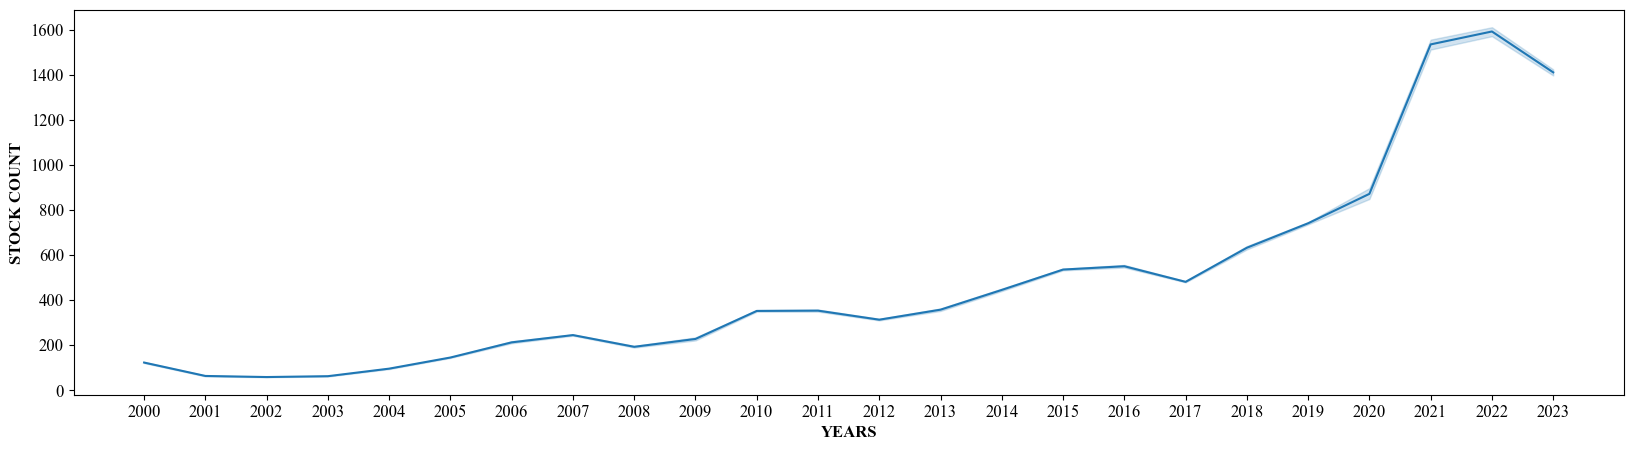

In [44]:
plt.figure(figsize=(20,5))
sns.lineplot(x="YEAR",y="STOCK_PRICE",data=stock_data)
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("YEARS", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("STOCK COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.show()

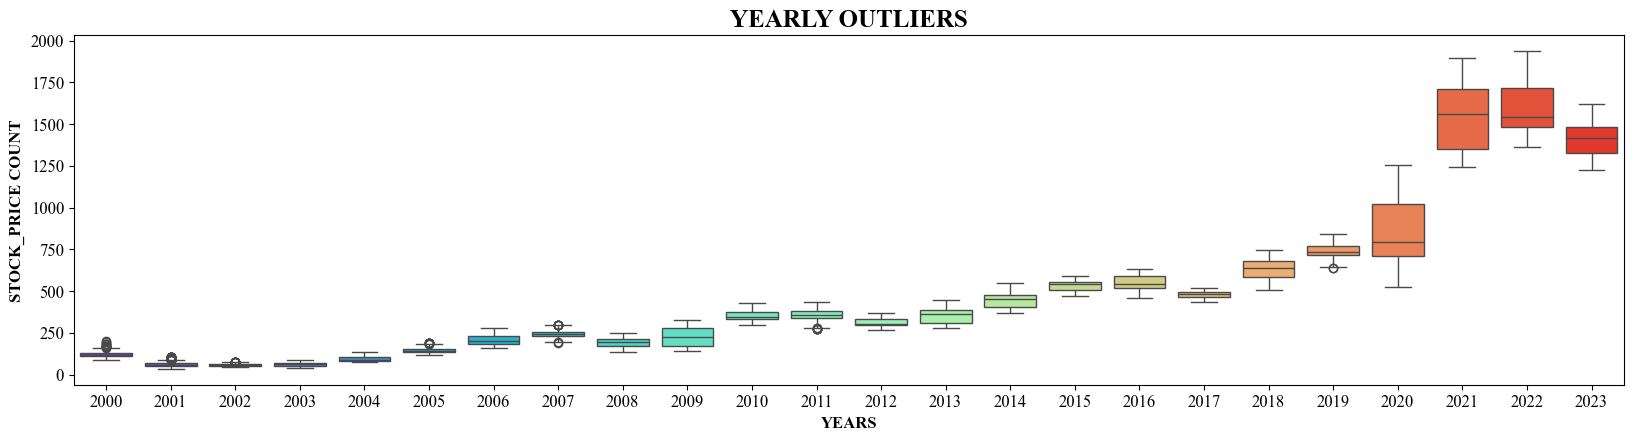

In [45]:
# Boxplot for Year Data
plt.figure(figsize=(20,10))
plt.subplot(211)
sns.boxplot(x="YEAR",y="STOCK_PRICE",data=stock_data, palette="rainbow")
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("YEARS", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("STOCK_PRICE COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.title("YEARLY OUTLIERS", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.show()

##### **INFERENCE** #####
-   Increasing trend as seen in the Yearly Plot, that is not consistent.
-   The variance is not constant

*MONTHLY TREND*

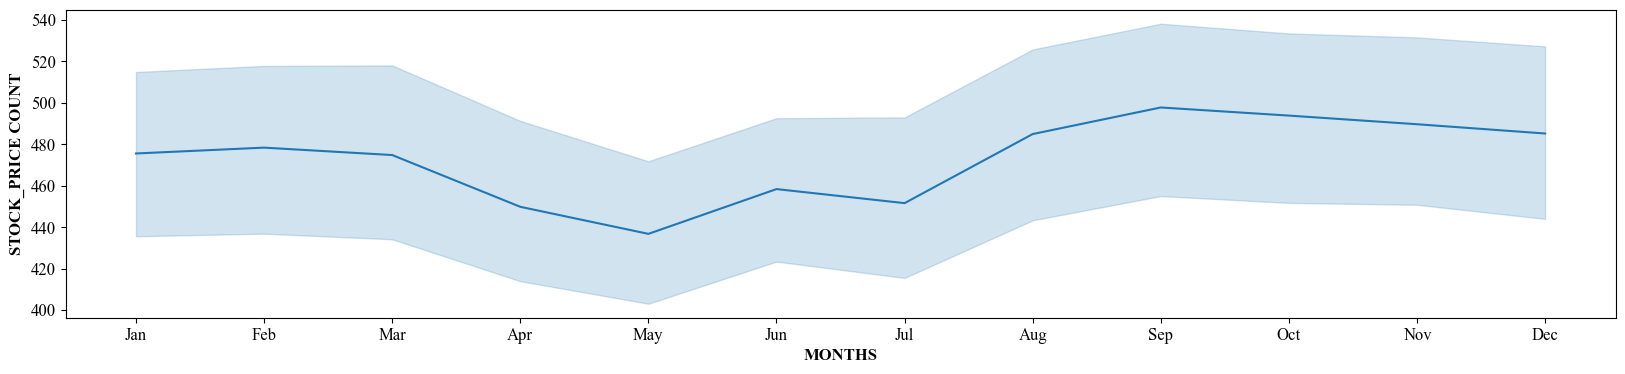

In [46]:
plt.figure(figsize=(20,4))
sns.lineplot(x="MONTH",y="STOCK_PRICE",data=stock_data)
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("MONTHS", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("STOCK_PRICE COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.show()

##### **INFERENCE** #####
1. MAY HAS THE LOWEST STOCK PRICES
2. SEPTHEMBER HAS THE HIGHEST STOCK PRICES

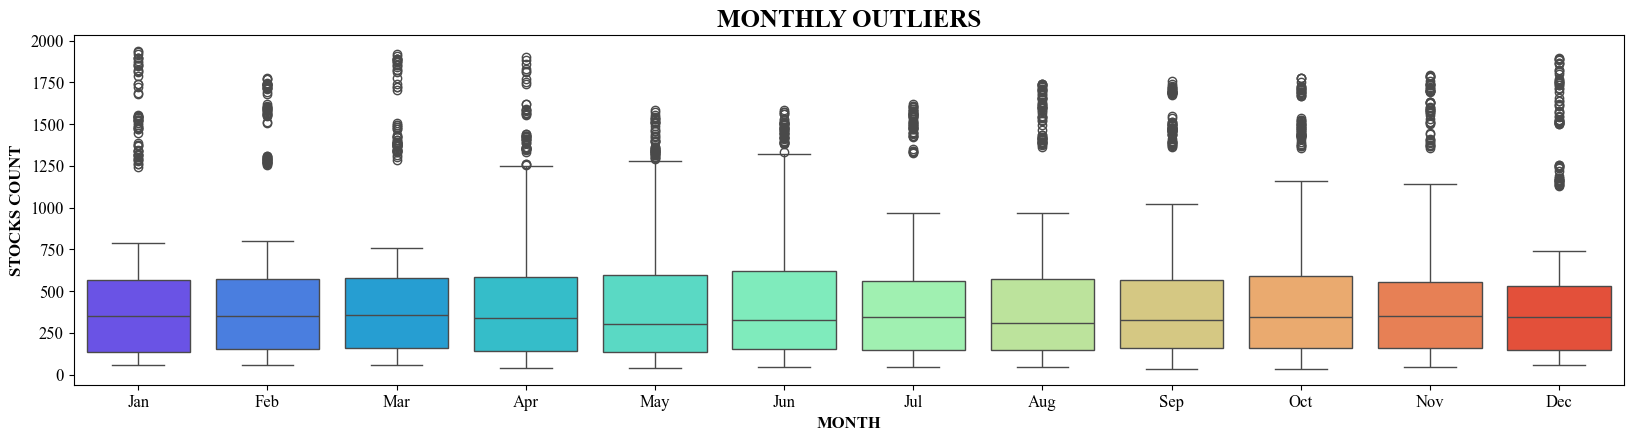

In [47]:
# Boxplot for Year Data
plt.figure(figsize=(20,10))
plt.subplot(211)
sns.boxplot(x="MONTH",y="STOCK_PRICE",data=stock_data, palette="rainbow")
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("MONTH", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("STOCKS COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.title("MONTHLY OUTLIERS", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.show()

##### **INFERENCE** #####
-   The medians for the monthly stock prices is almost a straight line. This shows that the price variation is not seasonal across the month.

*HISTOGRAM AND DENSITY PLOT*

Text(0, 0.5, 'COUNT')

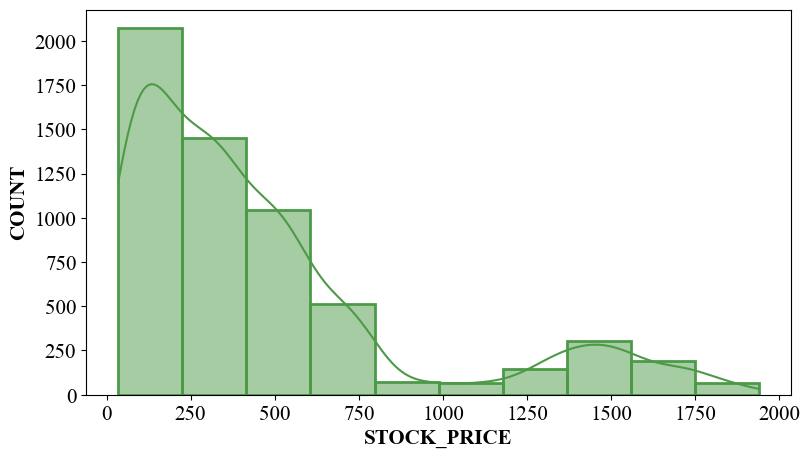

In [48]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plot = sns.histplot(stock_data, x='STOCK_PRICE', color='#4c9a47', edgecolor='#4c9a47', linewidth=2, bins=10, kde=True)
plt.setp(plot.get_xticklabels(), rotation=0, fontfamily = "Times New Roman", size = '15')
plt.setp(plot.get_yticklabels(), rotation=0, fontfamily = "Times New Roman", size = '15')
plt.xlabel('STOCK_PRICE', weight='bold', fontfamily = "Times New Roman", size = '15')
plt.ylabel("COUNT", weight='bold', fontfamily = "Times New Roman", size = '15')

##### **INFERENCE** #####
1. The most stock prices are between the range 50 and 250.
2. We see that the stock price data is skewed to the right, with the maximum being within the range 0 and 750
3. The least stock prices are less within the range 1000 and 1200

*LAG PLOT*

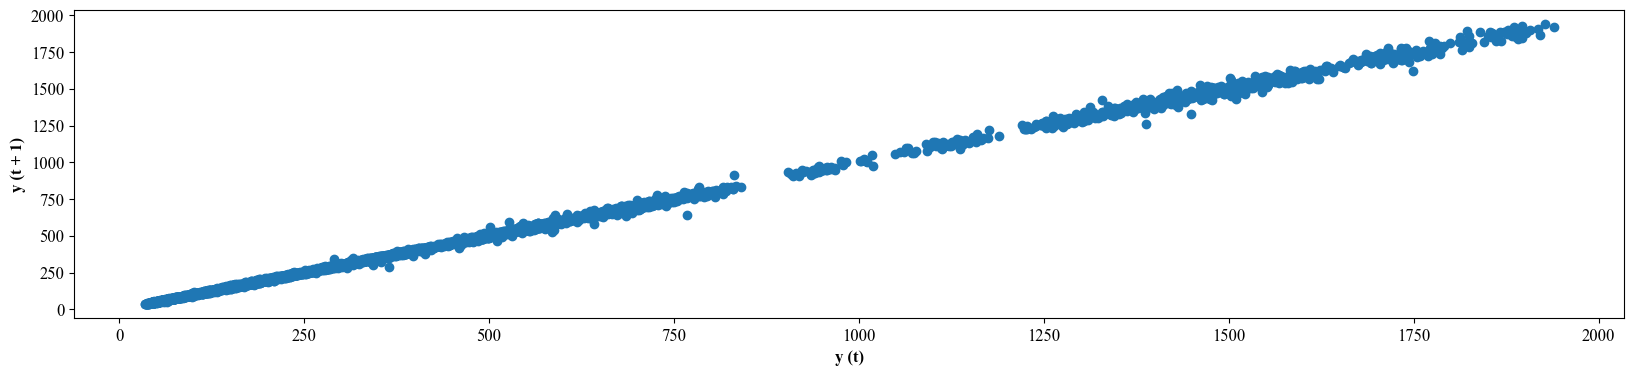

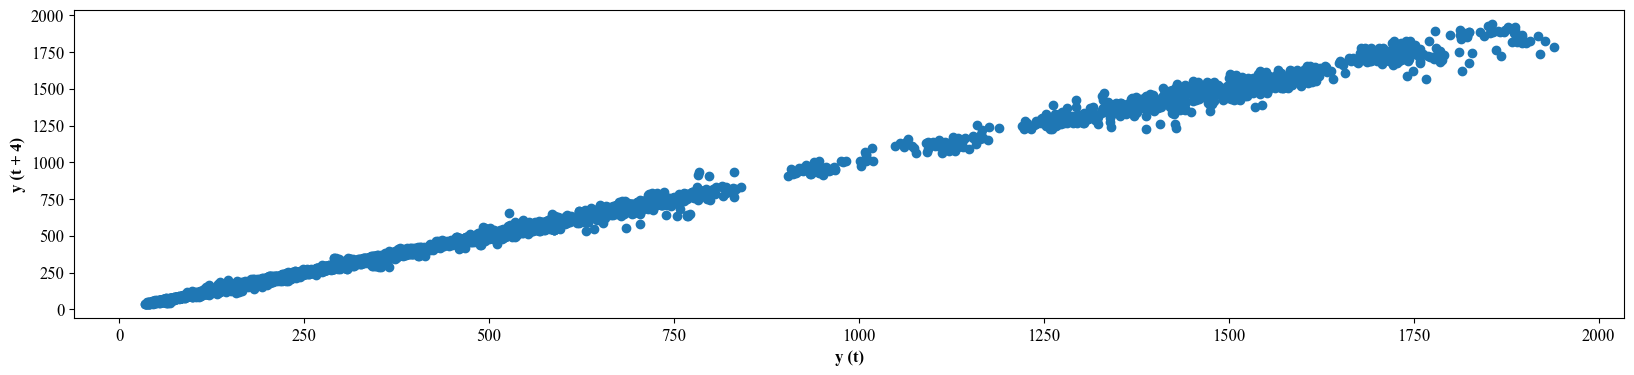

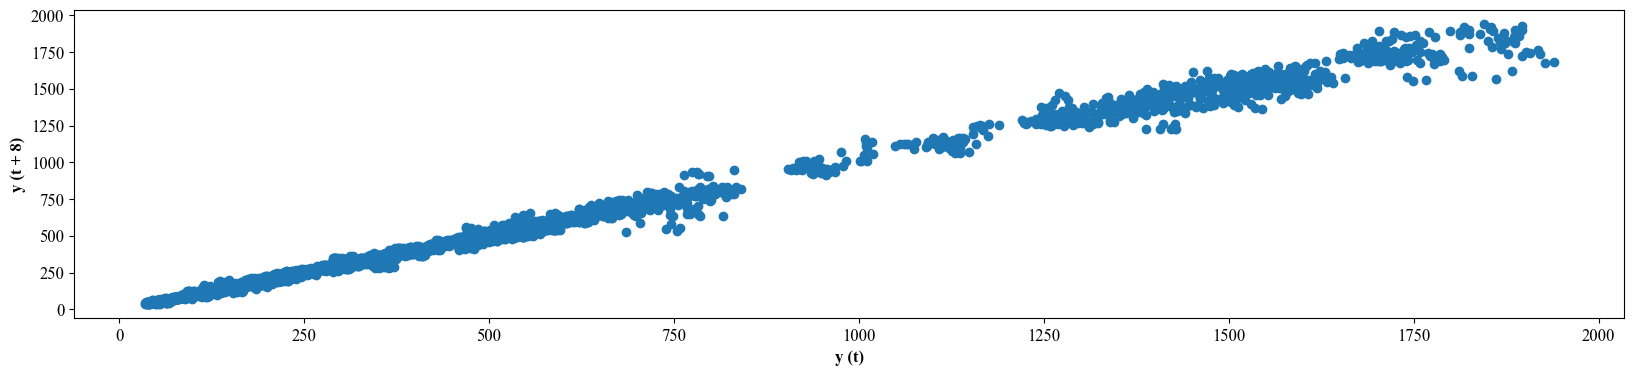

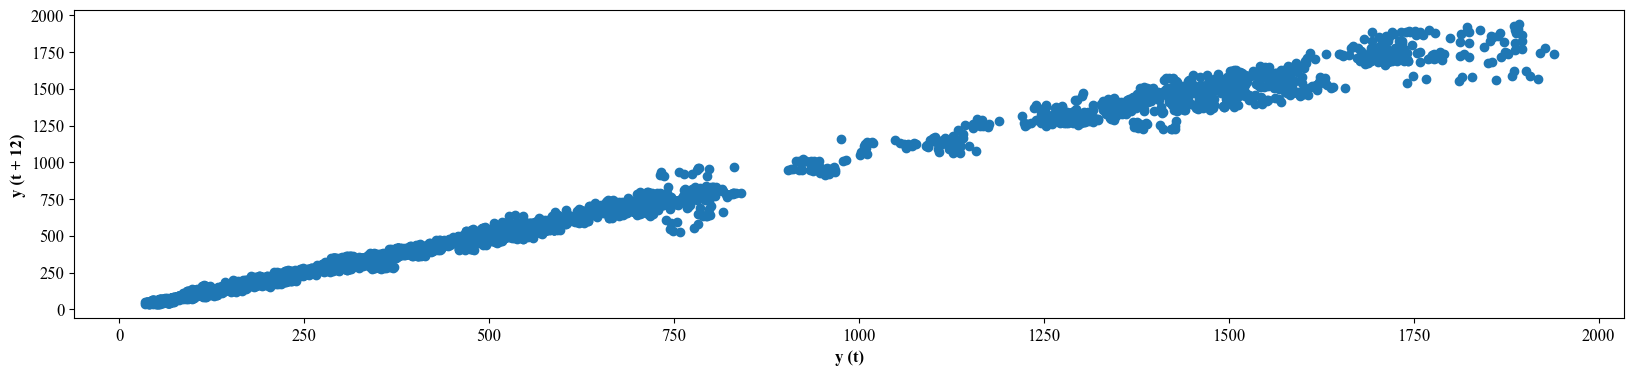

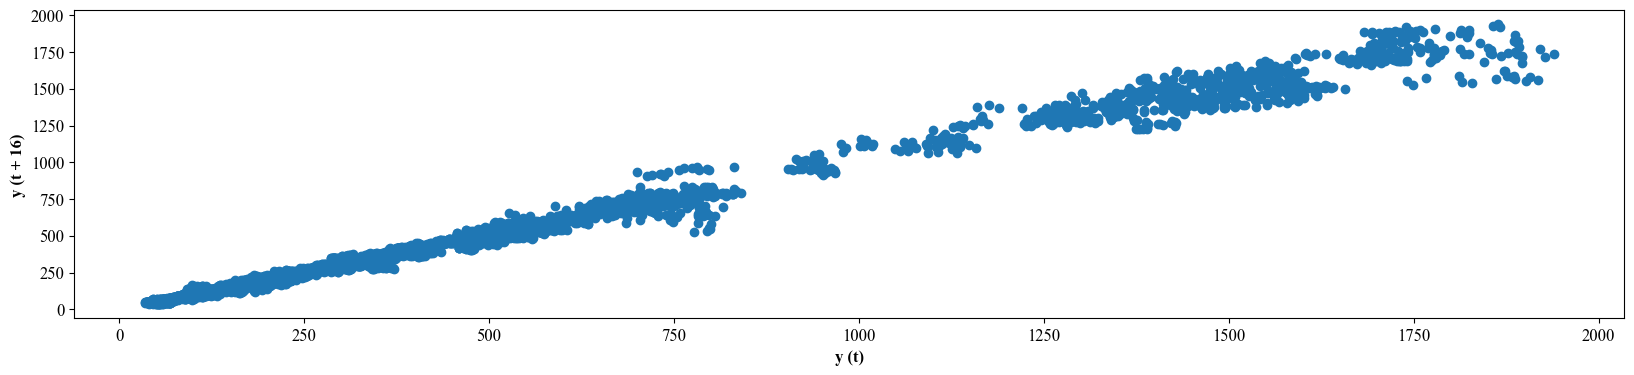

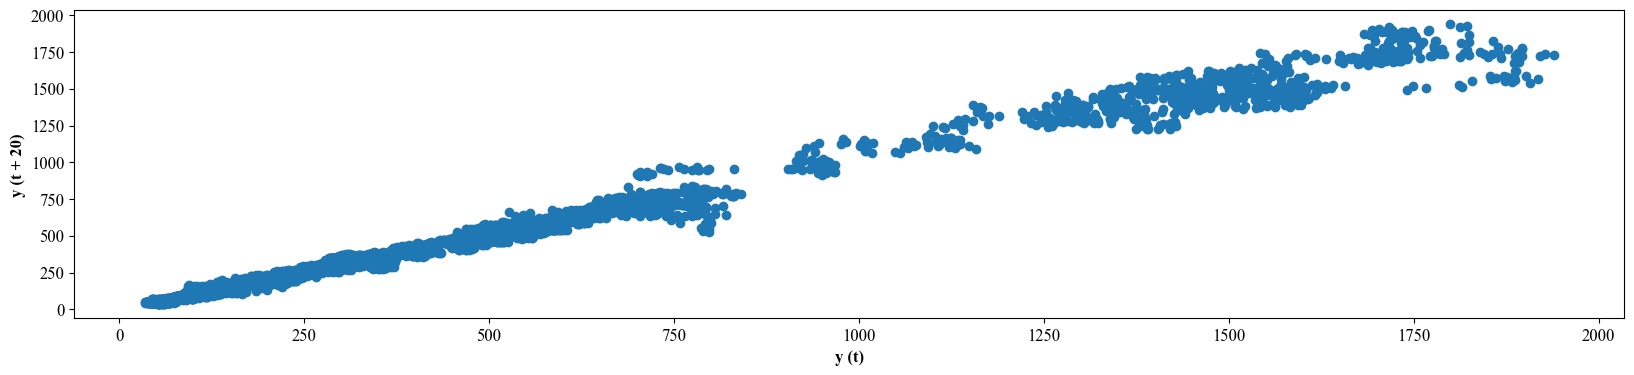

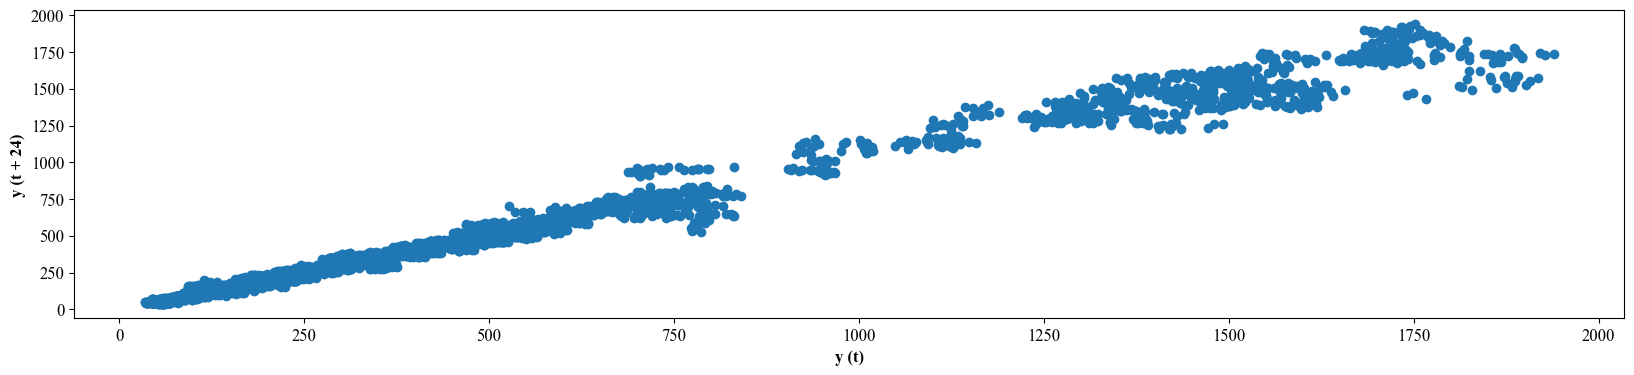

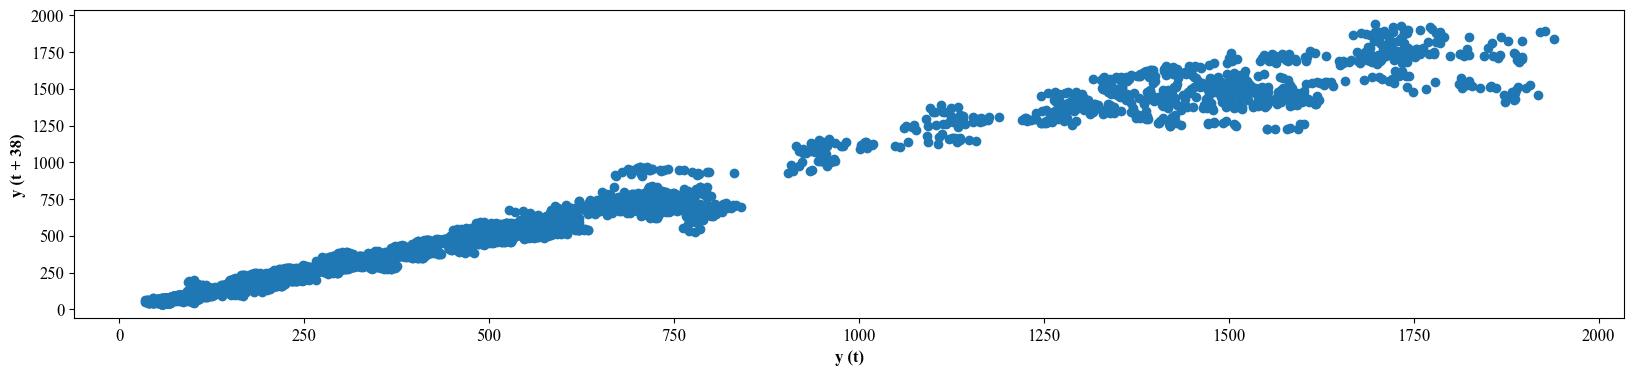

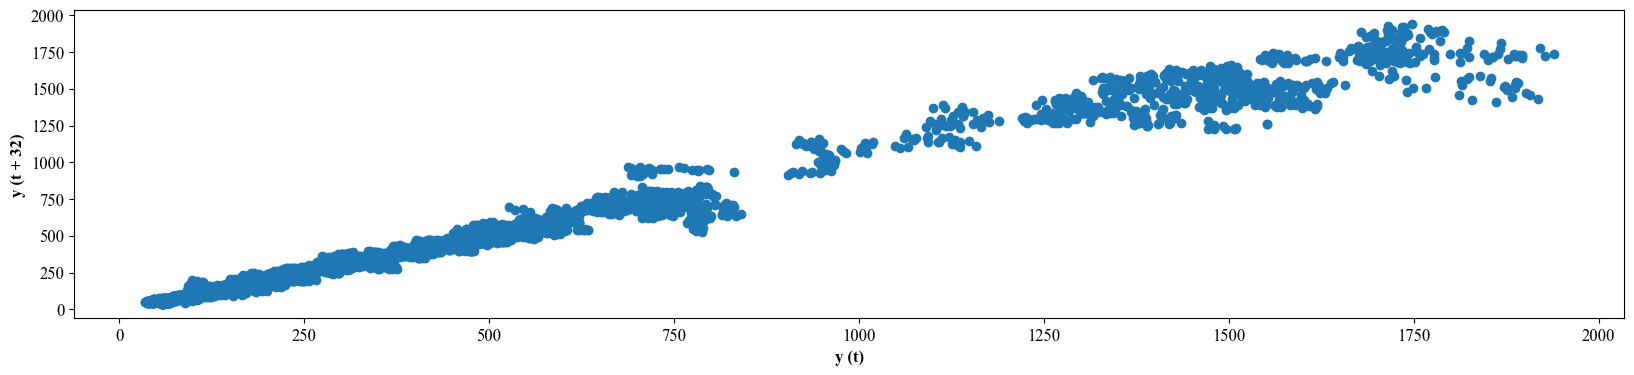

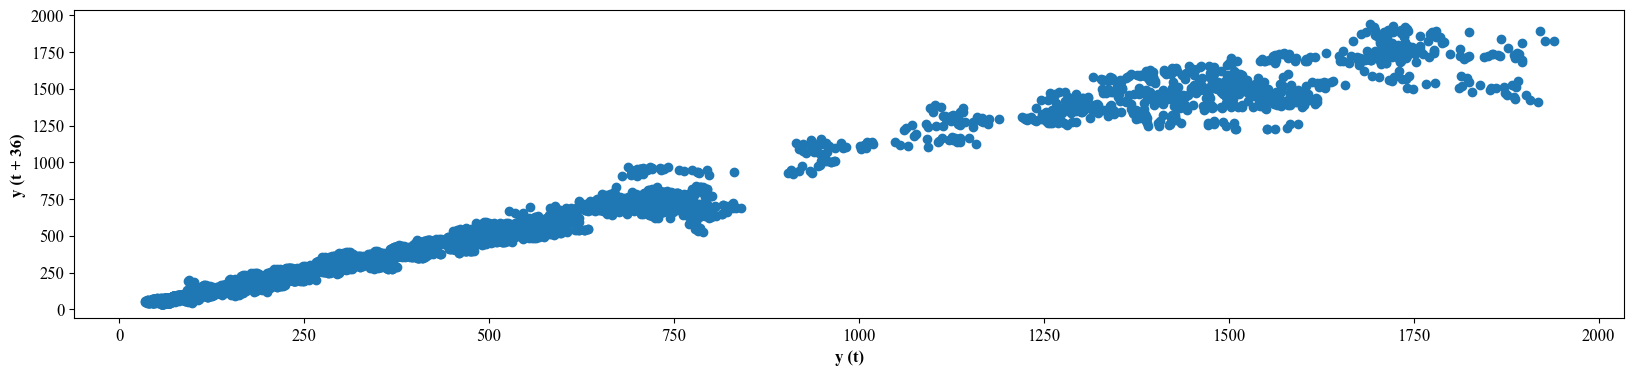

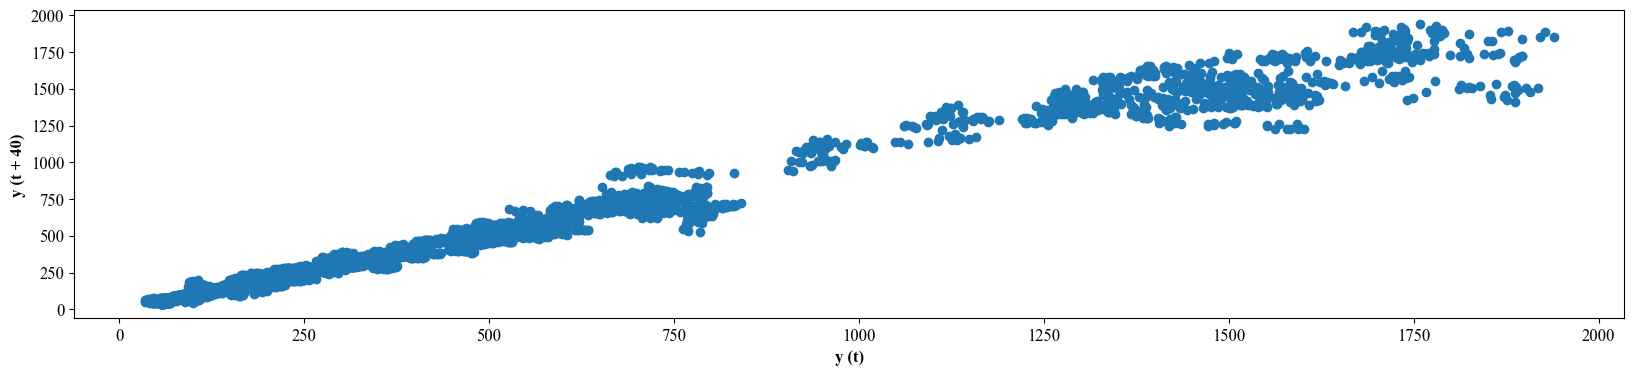

In [49]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    plt.figure(figsize=(20,4))
    lag_plot(stock_data.STOCK_PRICE, lag=i)
    plt.ylabel("y (t + " + str(i) + ")", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.xlabel("y (t)", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.show()

##### **INFERENCE** #####
1. A strong Positive Correlation or increasing trend is seen.
2. The plot shows a linear pattern.
3. The stock prices are not random but have a positive trend.
4. We also don't see any seasonality even though the data gets spread.

*MOVING AVERAGE*

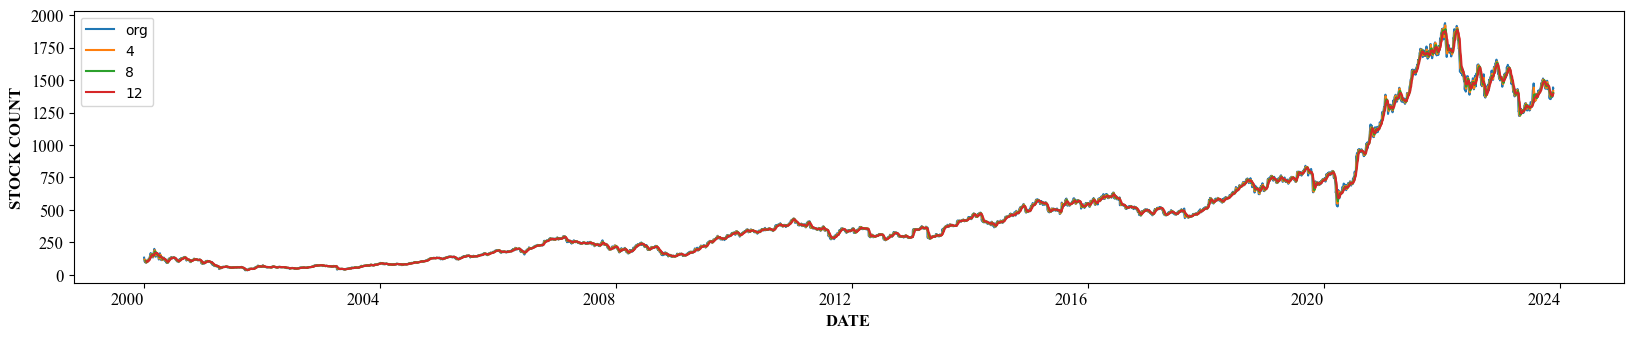

In [50]:
plt.figure(figsize=(20,4))
stock_data.STOCK_PRICE.plot(label="org")
for i in range(4,13,4):
    stock_data["STOCK_PRICE"].rolling(i).mean().plot(label=str(i))
    plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.xlabel("DATE", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.ylabel("STOCK COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.legend(loc='best')

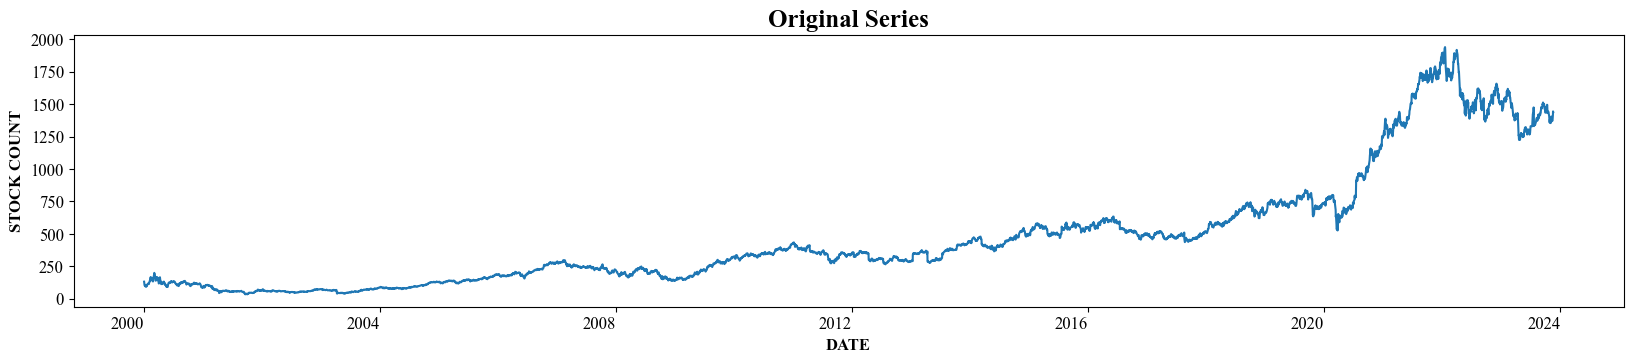

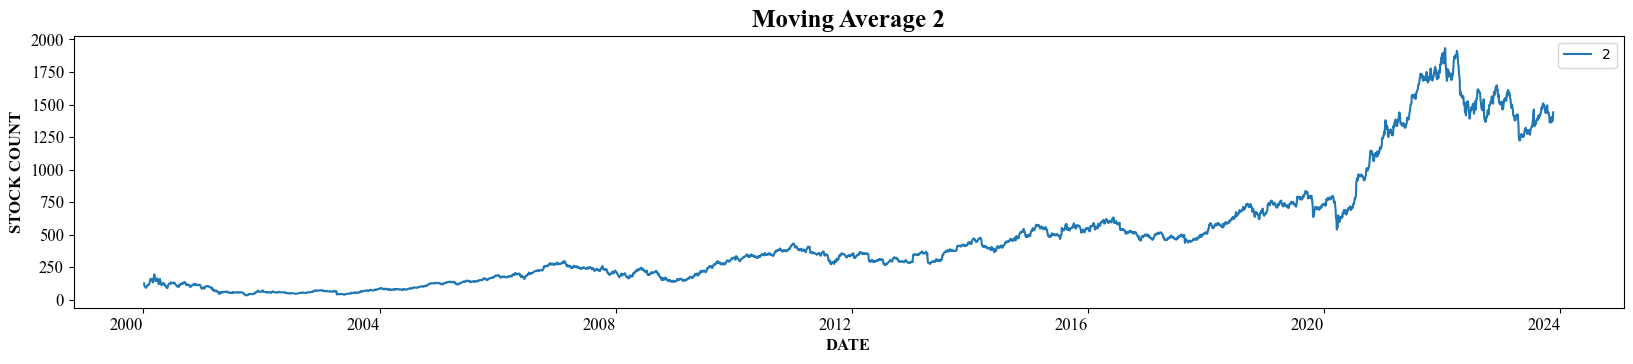

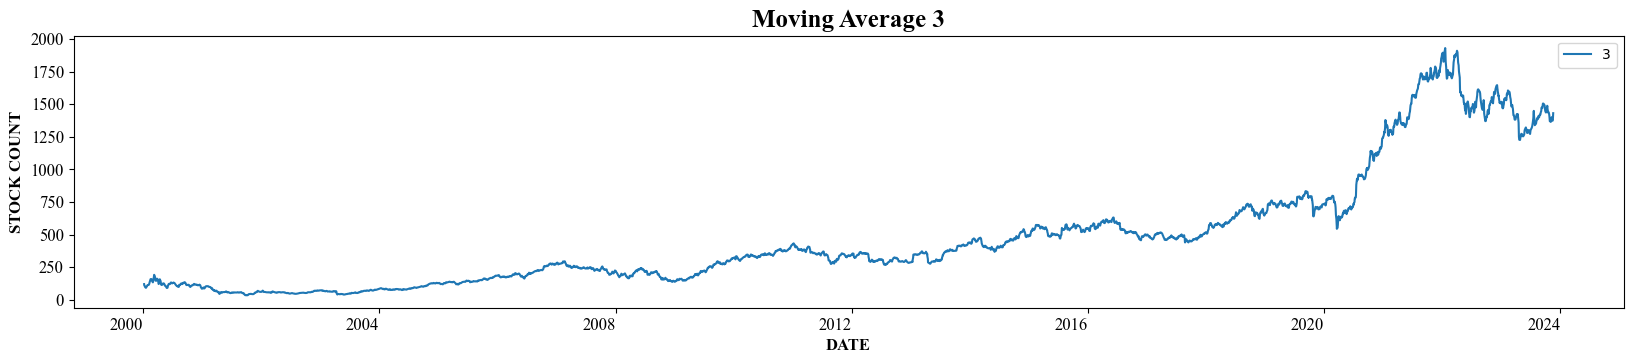

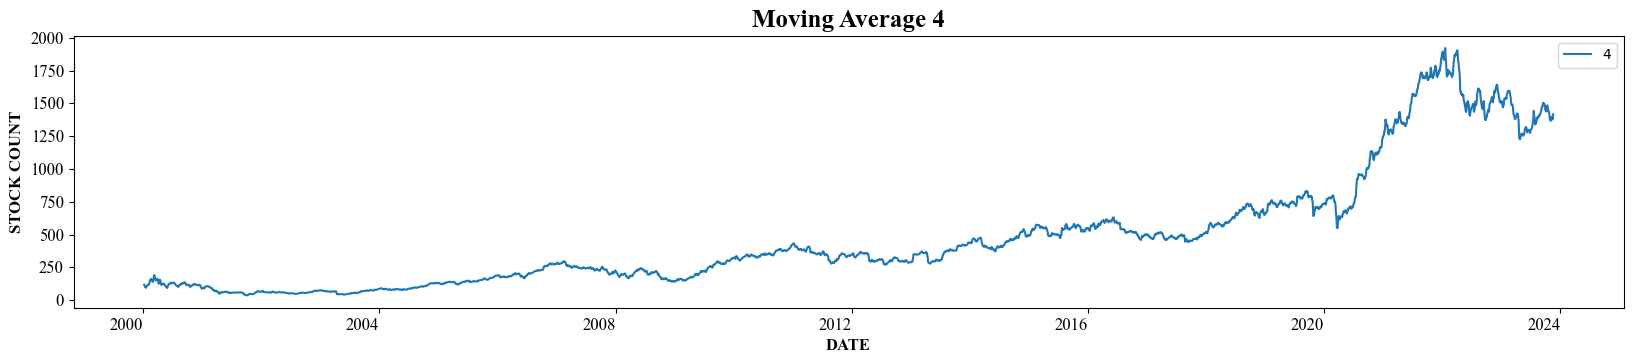

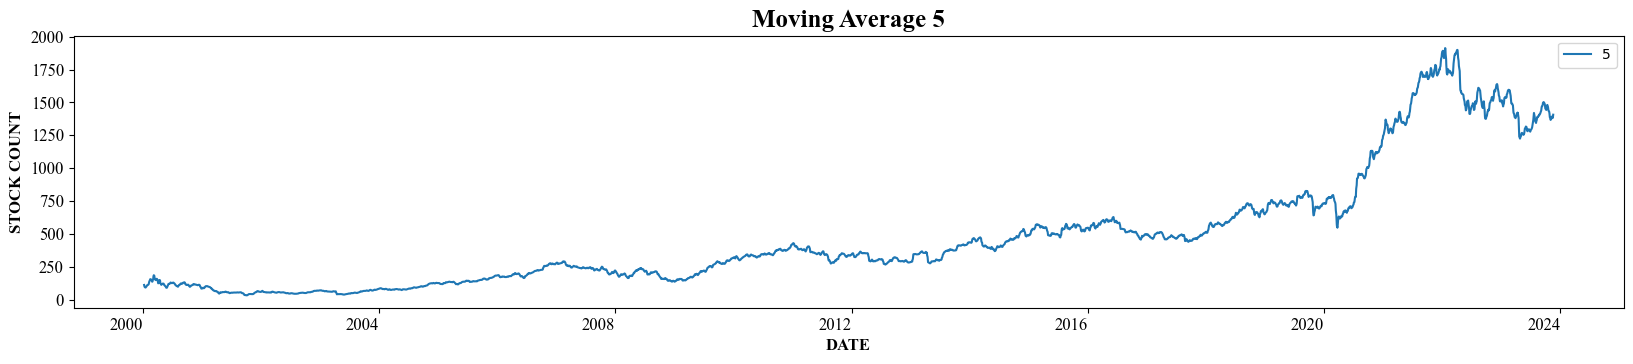

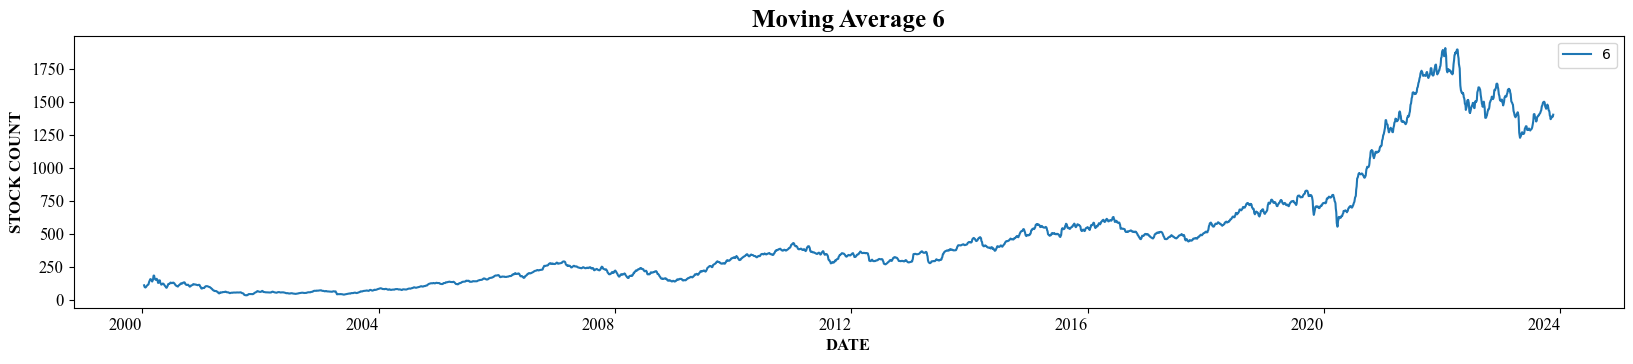

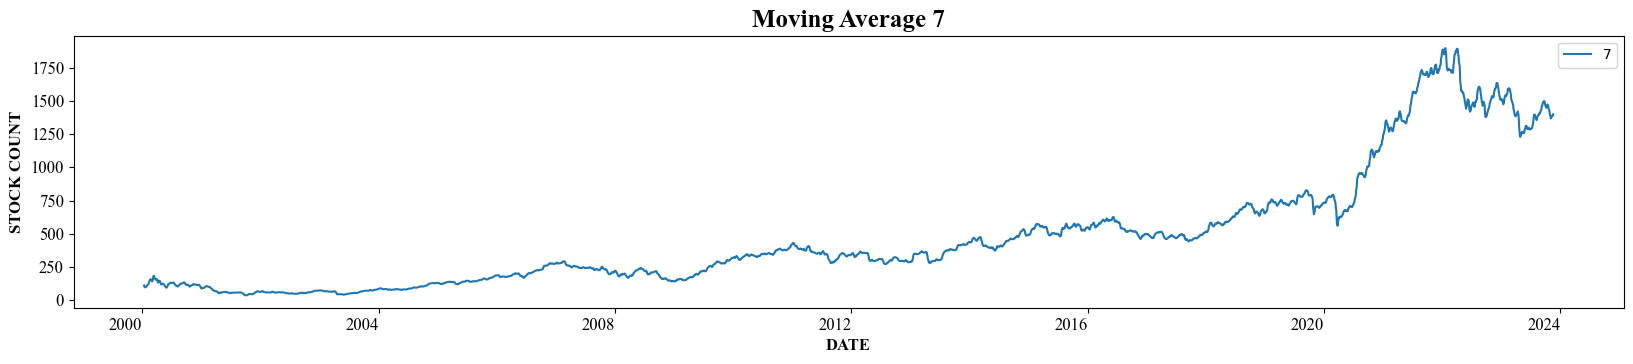

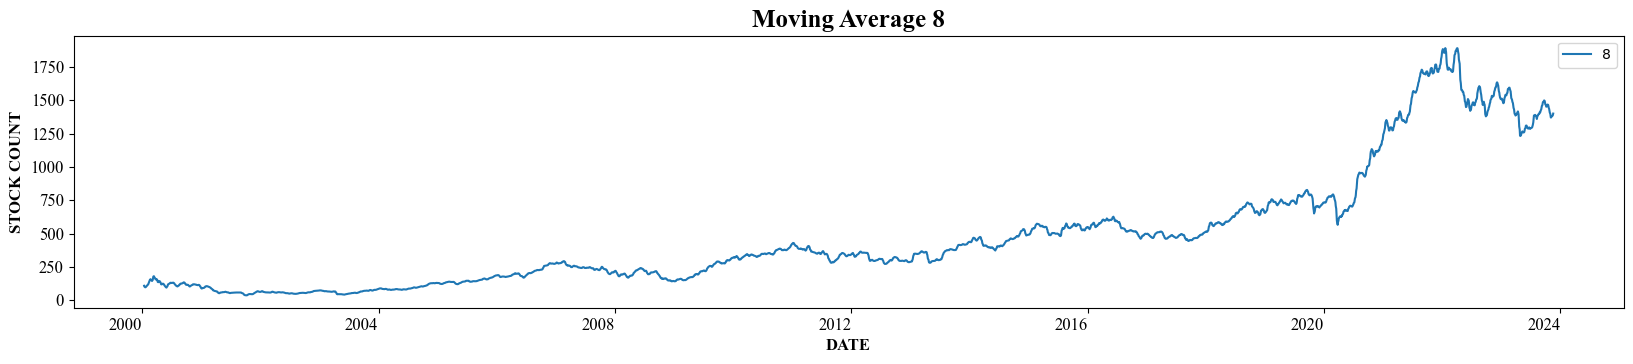

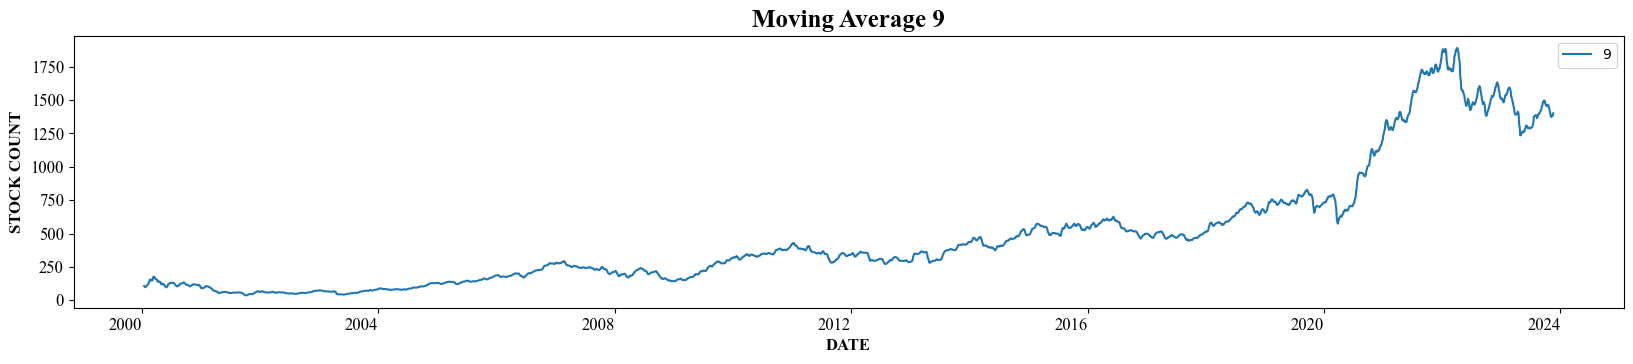

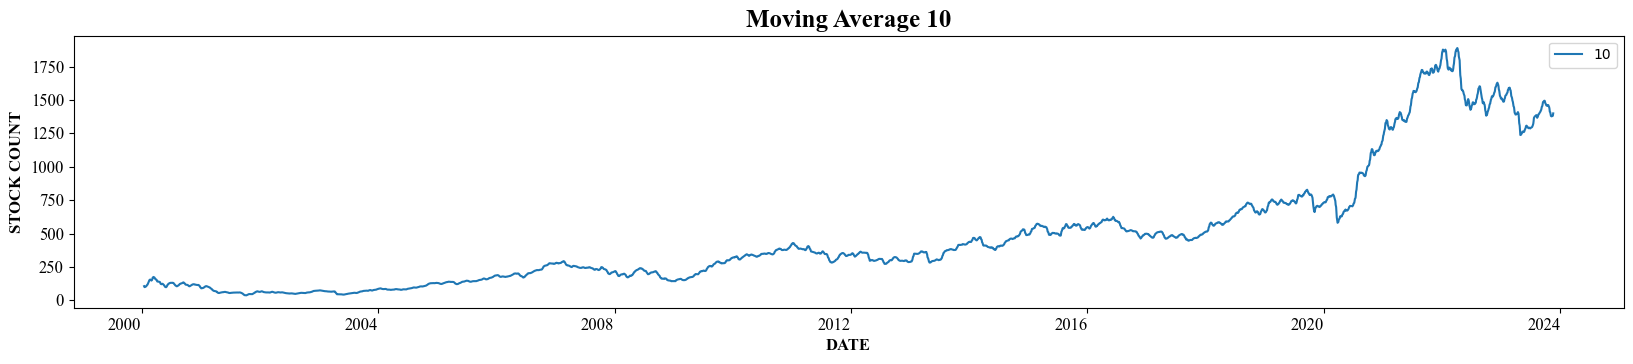

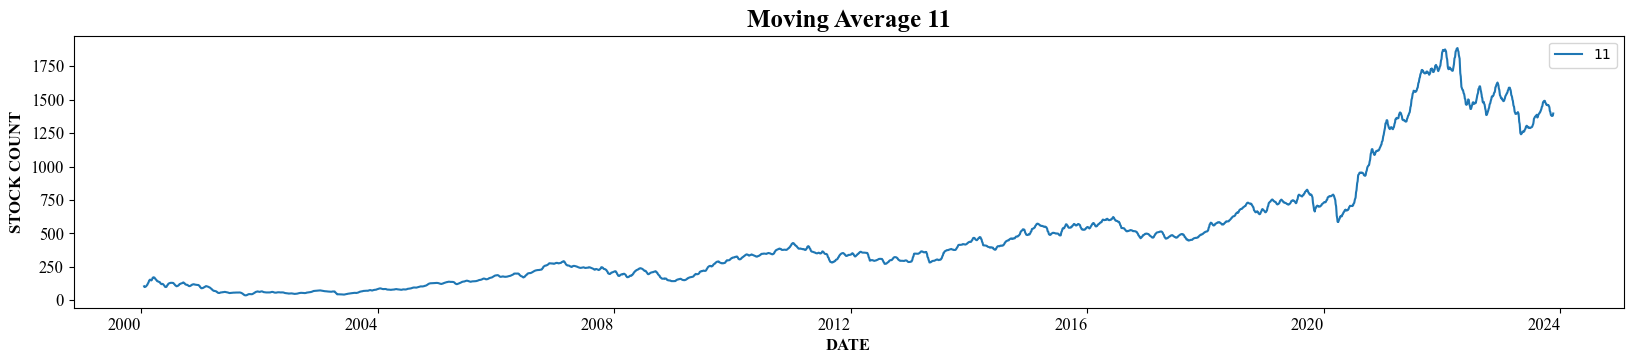

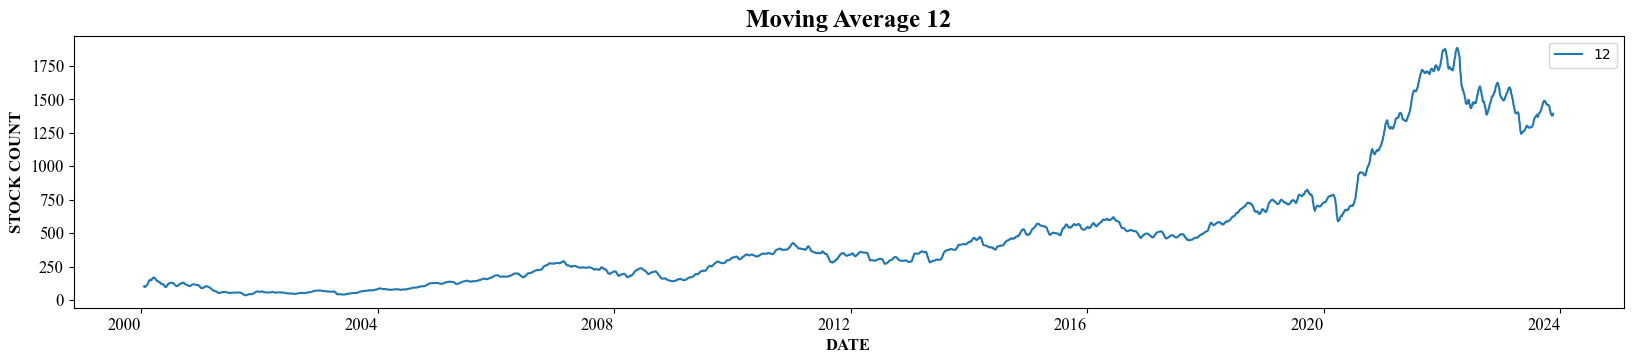

In [51]:
plt.figure(figsize=(20,4))
stock_data.STOCK_PRICE.plot(label="org")
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("DATE", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("STOCK COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.title("Original Series", weight='bold', fontfamily = "Times New Roman", size = '18')
for i in range(2,13):
    plt.figure(figsize=(20,4))
    stock_data["STOCK_PRICE"].rolling(i).mean().plot(label=str(i))
    plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.xlabel("DATE", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.ylabel("STOCK COUNT", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.title("Moving Average "+str(i), weight='bold', fontfamily = "Times New Roman", size = '18')
    plt.legend(loc='best')
    plt.show()

##### **INFERENCE** #####
1. By increasing the Moving Average time window, we see that the smoothening of the curve is much more but the overall trend remains the same.
2. Also, after 2-3 months, we don't see much smoothening in the trend line.

#### ***ACF plots and PACF plots*** ####

*ACF plot*

In [52]:
acf_data = pd.DataFrame()

for period in range(1,13):
    sdata_bak = stock_data.copy()
    sdata_bak['STOCK_DIFF'] = sdata_bak['STOCK_PRICE'].diff(periods=period)
    sdata_bak = sdata_bak.dropna()
    acf_values = acf(sdata_bak['STOCK_DIFF'])
    acf_data[period] = np.round(acf_values,2)


In [53]:
acf_data

1     2     3     4     5     6     7     8     9     10    11    12
0   1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00
1   0.04  0.51  0.68  0.75  0.81  0.83  0.86  0.88  0.89  0.90  0.91  0.92
2  -0.02  0.01  0.33  0.50  0.60  0.66  0.71  0.74  0.77  0.79  0.81  0.83
3   0.01 -0.01  0.01  0.25  0.40  0.49  0.56  0.61  0.65  0.69  0.72  0.75
4  -0.02  0.00 -0.01 -0.01  0.18  0.31  0.40  0.47  0.53  0.58  0.62  0.66
5   0.03 -0.00 -0.01 -0.02 -0.02  0.14  0.25  0.34  0.42  0.48  0.53  0.58
6  -0.05 -0.03 -0.03 -0.04 -0.04 -0.04  0.10  0.21  0.29  0.37  0.43  0.49
7   0.00 -0.03 -0.03 -0.04 -0.05 -0.05 -0.04  0.08  0.18  0.27  0.34  0.41
8  -0.02 -0.02 -0.04 -0.05 -0.05 -0.04 -0.04 -0.04  0.07  0.17  0.25  0.32
9  -0.01 -0.02 -0.03 -0.04 -0.04 -0.04 -0.03 -0.03 -0.03  0.08  0.17  0.25
10 -0.02 -0.02 -0.02 -0.02 -0.03 -0.02 -0.02 -0.02 -0.01 -0.01  0.09  0.17
11 -0.01 -0.00  0.00 -0.00 -0.00 -0.01 -0.00  0.00  0.00  0.01  0.01  0.10
12  0.03  0.03  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.03  0.03
13  0.02  0.03  0.03  0.03  0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.04
14 -0.01  0.00  0.02  0.04  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.04
15  0.01  0.02  0.03  0.05  0.05  0.06  0.06  0.06  0.06  0.06  0.05  0.05
16  0.02  0.03  0.04  0.04  0.06  0.07  0.07  0.07  0.07  0.07  0.05  0.04
17  0.02  0.03  0.04  0.05  0.06  0.07  0.07  0.07  0.07  0.06  0.05  0.04
18  0.01  0.01  0.03  0.05  0.05  0.05  0.06  0.06  0.05  0.05  0.04  0.03
19 -0.02  0.01  0.02  0.03  0.04  0.04  0.04  0.04  0.03  0.03  0.02  0.01
20  0.04  0.03  0.03  0.03  0.03  0.03  0.03  0.02  0.02  0.01  0.00 -0.01
21  0.01  0.02  0.01  0.01  0.01  0.00 -0.00 -0.01 -0.01 -0.02 -0.02 -0.04
22 -0.02 -0.02 -0.01 -0.01 -0.02 -0.03 -0.04 -0.04 -0.04 -0.05 -0.06 -0.06
23 -0.01 -0.02 -0.03 -0.04 -0.05 -0.06 -0.06 -0.07 -0.07 -0.08 -0.09 -0.09
24 -0.00 -0.02 -0.05 -0.07 -0.07 -0.08 -0.09 -0.10 -0.11 -0.11 -0.11 -0.11
25 -0.02 -0.05 -0.07 -0.09 -0.10 -0.10 -0.11 -0.13 -0.13 -0.13 -0.13 -0.13
26 -0.06 -0.08 -0.09 -0.10 -0.12 -0.13 -0.14 -0.15 -0.15 -0.15 -0.15 -0.15
27 -0.03 -0.06 -0.08 -0.10 -0.12 -0.14 -0.15 -0.15 -0.15 -0.15 -0.15 -0.16
28 -0.01 -0.02 -0.06 -0.09 -0.12 -0.13 -0.14 -0.15 -0.15 -0.15 -0.15 -0.16
29 -0.00 -0.02 -0.05 -0.09 -0.11 -0.12 -0.13 -0.13 -0.14 -0.15 -0.16 -0.16
30 -0.03 -0.05 -0.07 -0.08 -0.10 -0.11 -0.11 -0.12 -0.14 -0.15 -0.15 -0.16
31 -0.04 -0.07 -0.07 -0.07 -0.07 -0.08 -0.10 -0.11 -0.12 -0.14 -0.15 -0.15
32 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.07 -0.09 -0.11 -0.12 -0.13 -0.14
33  0.03  0.02  0.01  0.00 -0.01 -0.02 -0.04 -0.06 -0.08 -0.09 -0.10 -0.11
34  0.02  0.04  0.04  0.02  0.01 -0.01 -0.03 -0.04 -0.06 -0.07 -0.08 -0.09
35  0.02  0.03  0.04  0.03  0.01 -0.01 -0.02 -0.03 -0.04 -0.06 -0.07 -0.07
36  0.01  0.01  0.00  0.00 -0.00 -0.01 -0.02 -0.03 -0.04 -0.04 -0.05 -0.06
37 -0.02 -0.03 -0.04 -0.03 -0.02 -0.02 -0.03 -0.03 -0.03 -0.03 -0.04 -0.05

In [54]:
# Calculate Autocorrelation 
acf_values = acf(sdata_bak['STOCK_DIFF'])
np.round(acf_values,2)


array([ 1.  ,  0.92,  0.83,  0.75,  0.66,  0.58,  0.49,  0.41,  0.32,
        0.25,  0.17,  0.1 ,  0.03,  0.04,  0.04,  0.05,  0.04,  0.04,
        0.03,  0.01, -0.01, -0.04, -0.06, -0.09, -0.11, -0.13, -0.15,
       -0.16, -0.16, -0.16, -0.16, -0.15, -0.14, -0.11, -0.09, -0.07,
       -0.06, -0.05])

*pacf plot*

In [55]:
pacf_data = pd.DataFrame()

for period in range(1,13):
    sdata_bak = stock_data.copy()
    sdata_bak['STOCK_DIFF'] = sdata_bak['STOCK_PRICE'].diff(periods=period)
    sdata_bak = sdata_bak.dropna()
    pacf_values = pacf(sdata_bak['STOCK_DIFF'])
    pacf_data[period] = np.round(pacf_values,2)


In [56]:
pacf_data

1     2     3     4     5     6     7     8     9     10    11    12
0   1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00
1   0.04  0.51  0.68  0.75  0.81  0.83  0.86  0.88  0.89  0.90  0.91  0.92
2  -0.02 -0.34 -0.25 -0.15 -0.18 -0.11 -0.15 -0.10 -0.11 -0.10 -0.08 -0.08
3   0.01  0.25 -0.20 -0.18 -0.10 -0.10 -0.05 -0.09 -0.05 -0.03 -0.03 -0.04
4  -0.02 -0.19  0.30 -0.20 -0.18 -0.13 -0.13 -0.08 -0.10 -0.07 -0.08 -0.06
5   0.04  0.15 -0.13  0.37 -0.13 -0.13 -0.08 -0.07 -0.03 -0.07 -0.03 -0.03
6  -0.05 -0.17 -0.17 -0.14  0.36 -0.18 -0.16 -0.12 -0.14 -0.08 -0.11 -0.08
7   0.01  0.13  0.23 -0.09 -0.08  0.45 -0.05 -0.07 -0.02 -0.03  0.01 -0.02
8  -0.02 -0.14 -0.12 -0.12 -0.05 -0.06  0.41 -0.10 -0.11 -0.07 -0.08 -0.06
9  -0.00  0.10 -0.10  0.27 -0.07 -0.06 -0.06  0.46 -0.04 -0.06 -0.04 -0.03
10 -0.02 -0.11  0.19 -0.08 -0.08 -0.06 -0.01 -0.04  0.45 -0.07 -0.06 -0.05
11 -0.00  0.12 -0.06 -0.06  0.27 -0.04 -0.04 -0.03 -0.05  0.48 -0.03 -0.06
12  0.02 -0.07 -0.08 -0.06 -0.04 -0.06 -0.02 -0.04  0.01 -0.05  0.45 -0.05
13  0.02  0.07  0.14  0.20 -0.04  0.29 -0.11 -0.03 -0.07 -0.05 -0.07  0.45
14 -0.01 -0.06 -0.05 -0.06 -0.05 -0.07 -0.01 -0.07 -0.04 -0.05 -0.02 -0.07
15  0.01  0.09 -0.03 -0.02 -0.06  0.00  0.29 -0.04 -0.07 -0.03 -0.05 -0.05
16  0.02 -0.05  0.12 -0.06  0.22 -0.04 -0.06 -0.06 -0.02 -0.07 -0.06 -0.07
17  0.02  0.08 -0.07  0.17 -0.05 -0.06 -0.03  0.29 -0.09 -0.08 -0.10 -0.04
18  0.01 -0.08 -0.01 -0.06 -0.05 -0.06 -0.04 -0.06 -0.07 -0.07 -0.02 -0.07
19 -0.02  0.09  0.09 -0.04 -0.05  0.21 -0.05 -0.08  0.26 -0.05 -0.07 -0.06
20  0.04 -0.04 -0.05 -0.04 -0.02 -0.05 -0.10 -0.04 -0.03 -0.03 -0.04 -0.04
21  0.00  0.03 -0.06  0.11  0.12 -0.08 -0.08 -0.06 -0.05  0.26 -0.10 -0.10
22 -0.01 -0.06  0.08 -0.07 -0.09 -0.07  0.20 -0.07 -0.09 -0.07 -0.07 -0.02
23 -0.01  0.04 -0.06 -0.07 -0.06 -0.04 -0.05 -0.05 -0.05 -0.07  0.31 -0.03
24  0.00 -0.06 -0.09 -0.06 -0.04 -0.05 -0.05 -0.07 -0.09 -0.01 -0.04 -0.01
25 -0.02 -0.01  0.03  0.08 -0.04  0.13 -0.07  0.16 -0.00 -0.03 -0.01  0.29
26 -0.05 -0.07 -0.04 -0.05  0.09 -0.06 -0.07 -0.01 -0.04 -0.02 -0.02 -0.05
27 -0.03  0.03 -0.04 -0.04 -0.06 -0.07 -0.01 -0.01  0.00 -0.01 -0.02 -0.01
28 -0.00 -0.04  0.03 -0.05 -0.07 -0.00 -0.02  0.01  0.23 -0.04 -0.06 -0.04
29 -0.01  0.00 -0.06  0.02 -0.01 -0.02  0.18 -0.04 -0.04 -0.06 -0.04 -0.02
30 -0.03 -0.07 -0.08 -0.02 -0.02 -0.02 -0.04 -0.07 -0.05 -0.04 -0.04 -0.04
31 -0.03 -0.02  0.08  0.00  0.12  0.13 -0.03 -0.04 -0.06  0.23  0.01 -0.02
32 -0.05 -0.00 -0.01  0.00 -0.02 -0.04 -0.05 -0.04 -0.00 -0.02 -0.03 -0.00
33  0.03  0.05 -0.00  0.08 -0.02 -0.03 -0.02  0.19 -0.01 -0.00  0.01  0.01
34  0.01 -0.01  0.05 -0.06 -0.06 -0.05 -0.03 -0.04 -0.03 -0.04  0.23 -0.02
35  0.02  0.03 -0.05 -0.04 -0.06 -0.02 -0.02 -0.02 -0.04 -0.01 -0.03 -0.03
36  0.00 -0.05 -0.05 -0.04  0.09 -0.03  0.13 -0.01  0.01 -0.02 -0.02 -0.05
37 -0.02  0.00  0.02  0.07 -0.01  0.11 -0.03 -0.00  0.20 -0.01 -0.04  0.21

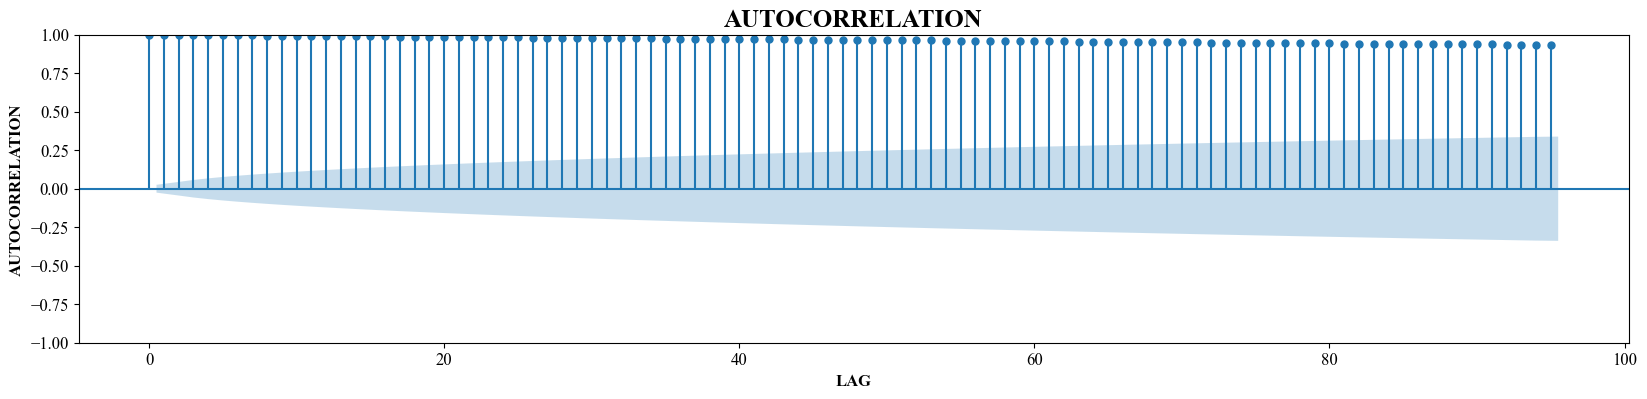

In [57]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(20,4))
    tsa_plots.plot_acf(stock_data["STOCK_PRICE"],lags=95)
    plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
    plt.xlabel("LAG", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.ylabel("AUTOCORRELATION", weight='bold', fontfamily = "Times New Roman", size = '12')
    plt.title("AUTOCORRELATION", weight='bold', fontfamily = "Times New Roman", size = '18')
    plt.show()

##### **INFERENCE** #####
All the lag points are above the Standard Error (SE), so we can consider all of them for the model building.

In [58]:
visual = stock_data.drop('DATE',axis=1)
visual.reset_index(inplace=True)
visual['DATE'] = pd.to_datetime(visual['DATE'],format='%d-%m-%Y')
visual['year'] = visual['DATE'].dt.year
visual['month'] = visual['DATE'].dt.month
visual['week'] = visual['DATE'].dt.isocalendar().week
visual['quarter'] = visual['DATE'].dt.quarter
visual['day_of_week'] = visual['DATE'].dt.day_name()
#visual.drop('date', axis =1 , inplace= True)
visual.head(10)

DATE  STOCK_PRICE MONTH  YEAR YEAR-MONTH  STOCK_DIFF  year  month  \
0 2000-01-04   132.110931   Jan  2000    2000-01    9.630462  2000      1   
1 2000-01-05   121.542191   Jan  2000    2000-01  -10.568740  2000      1   
2 2000-01-06   111.819138   Jan  2000    2000-01   -9.723053  2000      1   
3 2000-01-07   102.873825   Jan  2000    2000-01   -8.945313  2000      1   
4 2000-01-10   107.031250   Jan  2000    2000-01    4.157425  2000      1   
5 2000-01-11    98.469139   Jan  2000    2000-01   -8.562111  2000      1   
6 2000-01-12   101.570313   Jan  2000    2000-01    3.101174  2000      1   
7 2000-01-13    93.953514   Jan  2000    2000-01   -7.616799  2000      1   
8 2000-01-14    94.382813   Jan  2000    2000-01    0.429299  2000      1   
9 2000-01-17    92.576172   Jan  2000    2000-01   -1.806641  2000      1   

   week  quarter day_of_week  
0     1        1     Tuesday  
1     1        1   Wednesday  
2     1        1    Thursday  
3     1        1      Friday  
4     2        1      Monday  
5     2        1     Tuesday  
6     2        1   Wednesday  
7     2        1    Thursday  
8     2        1      Friday  
9     3        1      Monday

In [59]:
visual.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023])

In [60]:
visual.loc[visual['day_of_week']=='Sunday']

DATE  STOCK_PRICE MONTH  YEAR YEAR-MONTH  STOCK_DIFF  year  month  \
4931 2019-10-27   648.950012   Oct  2019    2019-10   11.400024  2019     10   

      week  quarter day_of_week  
4931    43        4      Sunday

In [61]:
visual.loc[visual['day_of_week']=='Saturday']
# There are only few records for Saturday and Sunday. These are noise/outliers and can be removed.
# Background - We don't get stock details for Saturday and Sunday so we should remove these days.

DATE  STOCK_PRICE MONTH  YEAR YEAR-MONTH  STOCK_DIFF  year  month  \
3053 2012-03-03   357.424988   Mar  2012    2012-03    1.599976  2012      3   
3183 2012-09-08   311.987488   Sep  2012    2012-09    1.612488  2012      9   
5193 2020-11-14  1133.449951   Nov  2020    2020-11    9.549927  2020     11   

      week  quarter day_of_week  
3053     9        1    Saturday  
3183    36        3    Saturday  
5193    46        4    Saturday

In [62]:
# delete all rows with column 'day_of_week' has value 'Saturday' or 'Sunday' 
sat_sun_index = visual[(visual['day_of_week'] =='Saturday') | (visual['day_of_week'] =='Sunday')].index
visual.drop(sat_sun_index, inplace=True)

In [63]:
# data 
df_2000 = visual[visual['year']==2000][['month','STOCK_PRICE']]
df_2000 = df_2000.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2000'})
df_2001 = visual[visual['year']==2001][['month','STOCK_PRICE']]
df_2001 = df_2001.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2001'})
df_2002 = visual[visual['year']==2002][['month','STOCK_PRICE']]
df_2002 = df_2002.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2002'})
df_2003 = visual[visual['year']==2003][['month','STOCK_PRICE']]
df_2003 = df_2003.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2003'})
df_2004 = visual[visual['year']==2004][['month','STOCK_PRICE']]
df_2004 = df_2004.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2004'})
df_2005 = visual[visual['year']==2005][['month','STOCK_PRICE']]
df_2005 = df_2005.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2005'})
df_2006 = visual[visual['year']==2006][['month','STOCK_PRICE']]
df_2006 = df_2006.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2006'})
df_2007 = visual[visual['year']==2007][['month','STOCK_PRICE']]
df_2007 = df_2007.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2007'})
df_2008 = visual[visual['year']==2008][['month','STOCK_PRICE']]
df_2008 = df_2008.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2008'})
df_2009 = visual[visual['year']==2009][['month','STOCK_PRICE']]
df_2009 = df_2009.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2009'})
df_2010 = visual[visual['year']==2010][['month','STOCK_PRICE']]
df_2010 = df_2010.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2010'})
df_2011 = visual[visual['year']==2011][['month','STOCK_PRICE']]
df_2011 = df_2011.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2011'})
df_2012 = visual[visual['year']==2012][['month','STOCK_PRICE']]
df_2012 = df_2012.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2012'})
df_2013 = visual[visual['year']==2013][['month','STOCK_PRICE']]
df_2013 = df_2013.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2013'})
df_2014 = visual[visual['year']==2014][['month','STOCK_PRICE']]
df_2014 = df_2014.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2014'})
df_2015 = visual[visual['year']==2015][['month','STOCK_PRICE']]
df_2015 = df_2015.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2015'})
df_2016 = visual[visual['year']==2016][['month','STOCK_PRICE']]
df_2016 = df_2016.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2016'})
df_2017 = visual[visual['year']==2017][['month','STOCK_PRICE']]
df_2017 = df_2017.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2017'})
df_2018 = visual[visual['year']==2018][['month','STOCK_PRICE']]
df_2018 = df_2018.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2018'})
df_2019 = visual[visual['year']==2019][['month','STOCK_PRICE']]
df_2019 = df_2019.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2019'})
df_2020 = visual[visual['year']==2020][['month','STOCK_PRICE']]
df_2020 = df_2020.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2020'})
df_2021 = visual[visual['year']==2021][['month','STOCK_PRICE']]
df_2021 = df_2021.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2021'})
df_2022 = visual[visual['year']==2022][['month','STOCK_PRICE']]
df_2022 = df_2022.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2022'})
df_2023 = visual[visual['year']==2023][['month','STOCK_PRICE']]
df_2023 = df_2023.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index().rename(columns={'STOCK_PRICE':'2023'})

df_year = df_2000.merge(df_2001,on='month').merge(df_2002,on='month').merge(df_2003,on='month').merge(df_2004,on='month').merge(df_2005,on='month').merge(df_2006,on='month').merge(df_2007,on='month').merge(df_2008,on='month').merge(df_2009,on='month').merge(df_2010,on='month').merge(df_2011,on='month').merge(df_2012,on='month').merge(df_2013,on='month').merge(df_2014,on='month').merge(df_2015,on='month').merge(df_2016,on='month').merge(df_2017,on='month').merge(df_2018,on='month').merge(df_2019,on='month').merge(df_2020,on='month').merge(df_2021,on='month').merge(df_2022,on='month').merge(df_2023,on='month')

# top levels
top_labels = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']

colors = ['#99de7c','#8ad87f','#7bd383','#6dcd85','#60c788','#52c08a','#45ba8c','#37b48e','#2aad8f','#1ca68f','#0a9f8f',
          '#00998e','#00928d','#008b8b','#008489','#007d85','#027681','#0e6f7d','#166978','#1d6272','#225b6c','#255566','#284e5f','#2a4858']

# X axis value 
df_year = df_year[['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_2000['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_2000['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

        
fig.update_layout(title='Avg Stocks for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14, color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

##### **INFERENCE** #####
**We are getting the Month-Wise Yearly distribution Count of Stock Trading** 
1. Each Year is denoted by a specific color with the lightest color indicating the oldest Year in this case '2000' and the darkest color being for the latest year i.e., '2023'
2. We see the least year is '2001' and the maximum count is seen for the year '2021'.

In [64]:
# data
import calendar
df_m_sa = visual.groupby('month').agg({"STOCK_PRICE" : "mean"}).reset_index()
df_m_sa['STOCK_PRICE'] = round(df_m_sa['STOCK_PRICE'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['STOCK_PRICE'].astype(str) 

df_w_sa = visual.groupby('week').agg({"STOCK_PRICE" : "mean"}).reset_index() 
df_q_sa = visual.groupby('quarter').agg({"STOCK_PRICE" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#006666'
df_m_sa['color'][:-1] = '#009999'
df_w_sa['color'] = '#00cccc'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Monthly Average Stock Price Analysis", "Quarterly Average Stock Price Analysis", 
                                    "Weekly Average Stock Price Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['STOCK_PRICE'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['STOCK_PRICE'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#003333','#006666','#009999','#00cccc','#80ffff']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['STOCK_PRICE'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="AVERAGE INFOSYS STOCK PRICE ANALYSIS",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

##### **INFERENCE** #####
**We are getting the Monthly, Quarterly and Weekly distribution of the INFOSYS Stock Trading** 
1. The highest count is seen for *'September'* **498.18** and the lowest count is seen for *'May'* i.e., **436.88**.
2. We don't see much variation in the Quarterly count. However, the highest count is seen for *'Q4'* **25.9%** and the lowest count is seen for *'Q1'* i.e., **25.2%**.
3. We don't see much variation in the Weekly count. However, the highest count is seen for *'Week 53'* **589.90** and the lowest count is seen for *'Week 27'* i.e., **436.50**.

In [65]:
# data
df_dw_sa = visual.groupby('day_of_week').agg({"STOCK_PRICE" : "mean"}).reset_index()
df_dw_sa.STOCK_PRICE = round(df_dw_sa.STOCK_PRICE, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='STOCK_PRICE', title='Avg Stocks vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='STOCK_PRICE',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

##### **INFERENCE** #####
**We are getting the Average Stocks per Week for INFOSYS Stock Trading** 
- We don't see much variation in the Week Day count. However, the highest count is seen for *'Thursday'* **474.26** and the lowest count is seen for *'Tuesday'* i.e., **469.64**.

### **TIME SERIES DECOMPOSITION** ###

### ***Additive Seasonal Decomposition*** ###

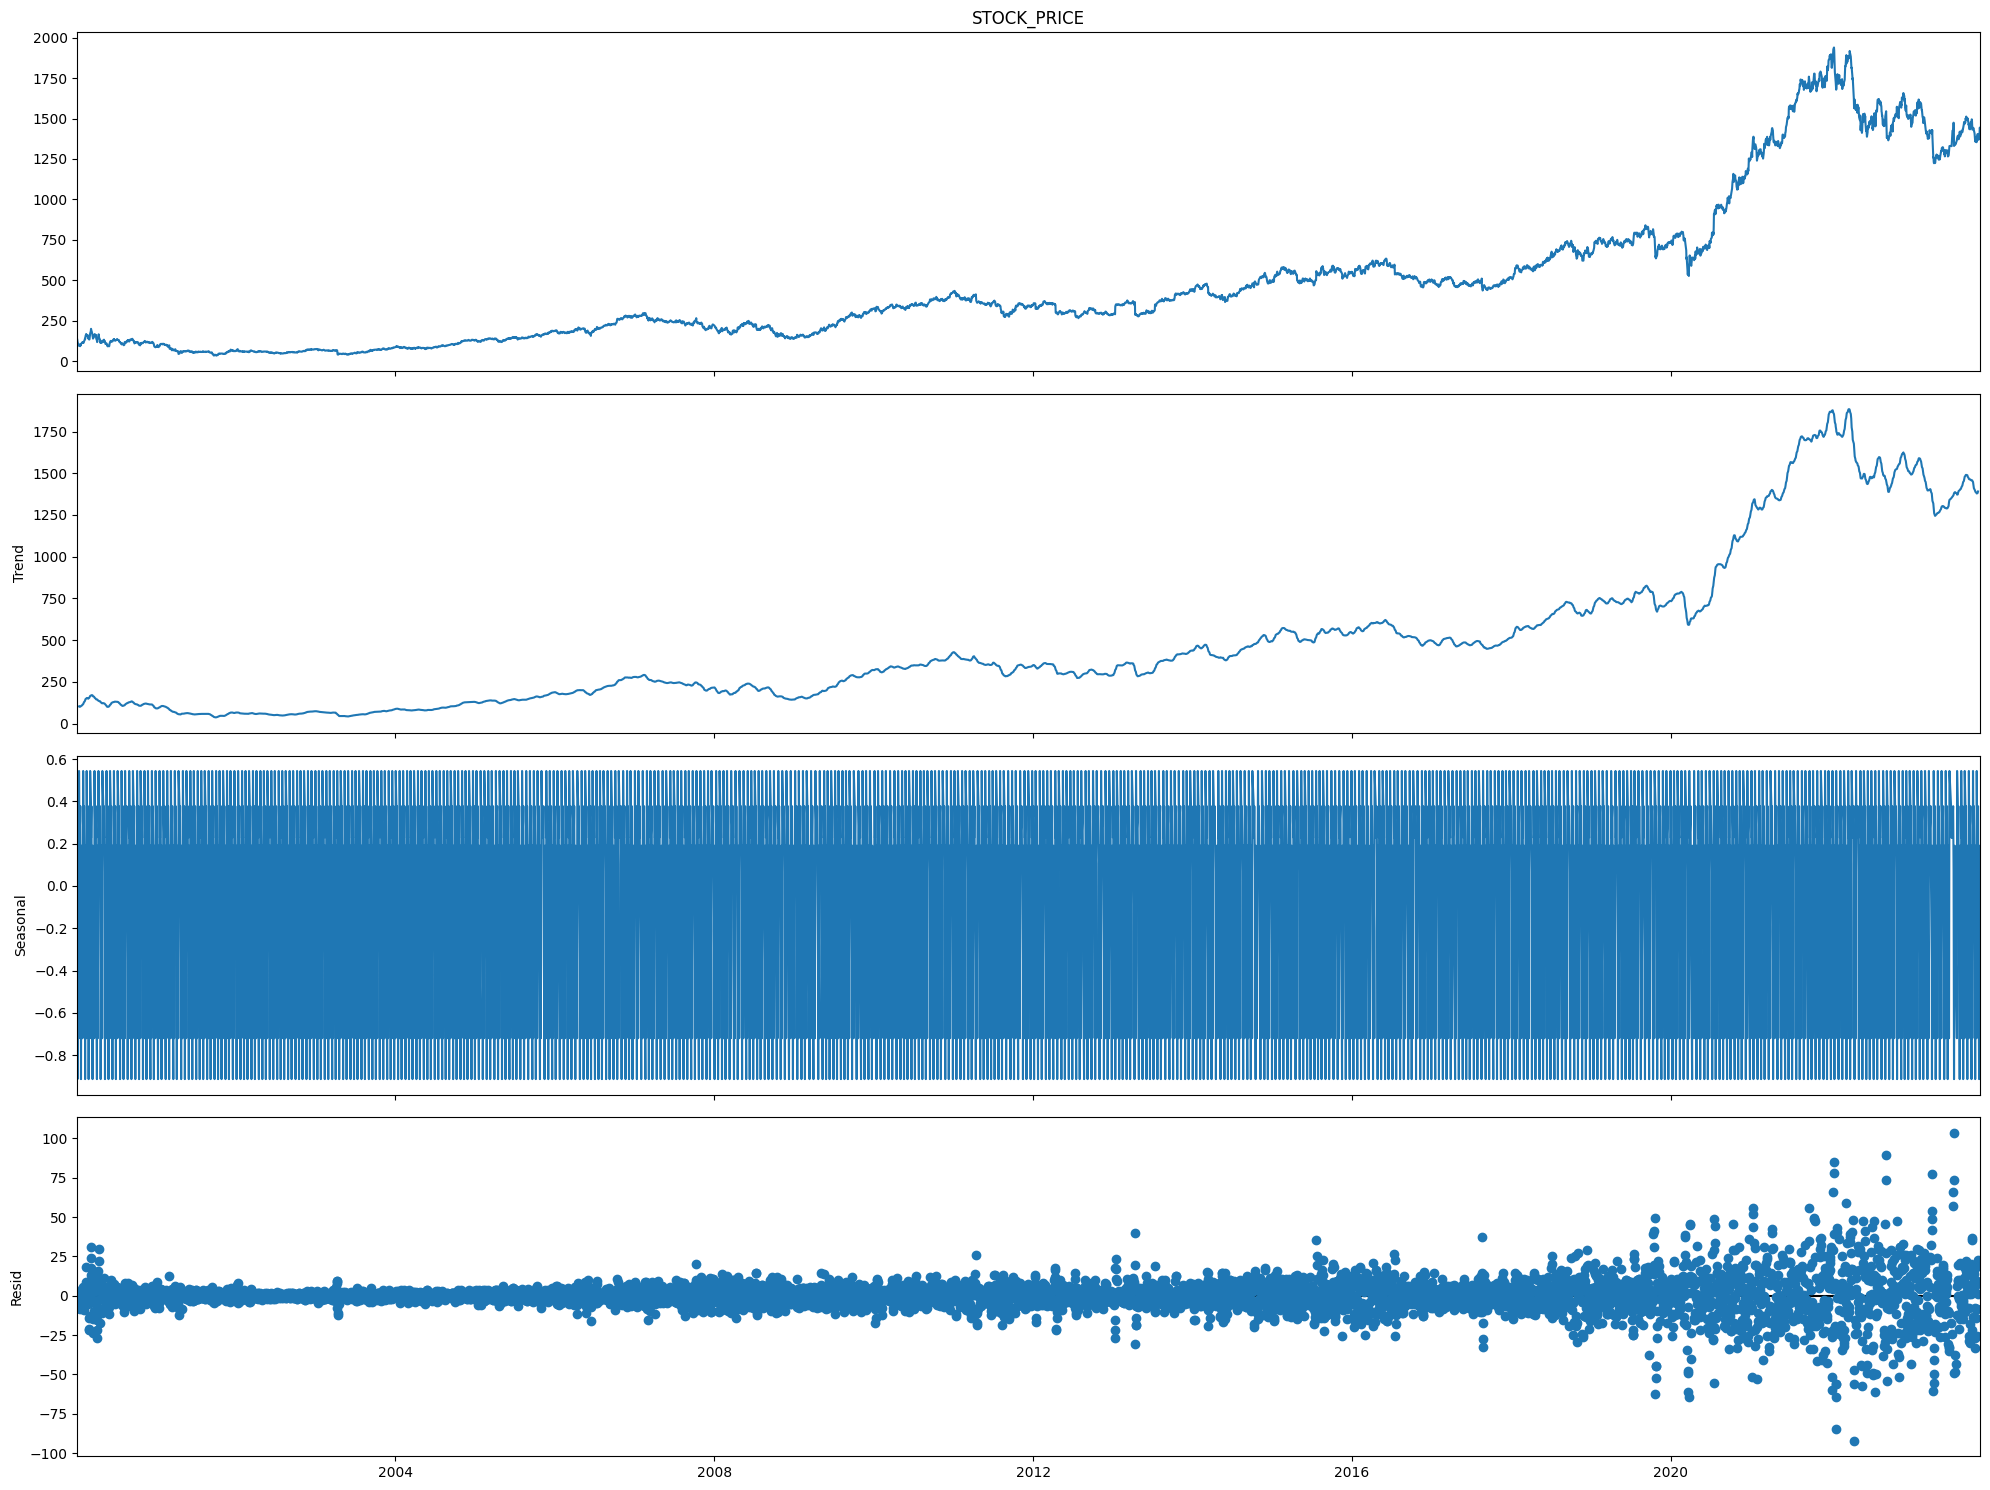

In [66]:
decompose_ts_add = seasonal_decompose(stock_data.STOCK_PRICE,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(20,15))
    decompose_ts_add.plot()
    plt.show()

##### **INFERENCE** #####
**We are getting the Trend, Seasonality and Residue using the 'Additive Seasonality' decomposition method, for the INFOSYS Stock Trading** 
- The trend is a postive trend.
- There is no seasonality observed.
- We see that there is more noise/error in *Additive Seasonality*.

### ***Multiplicative Seasonal Decomposition*** ###

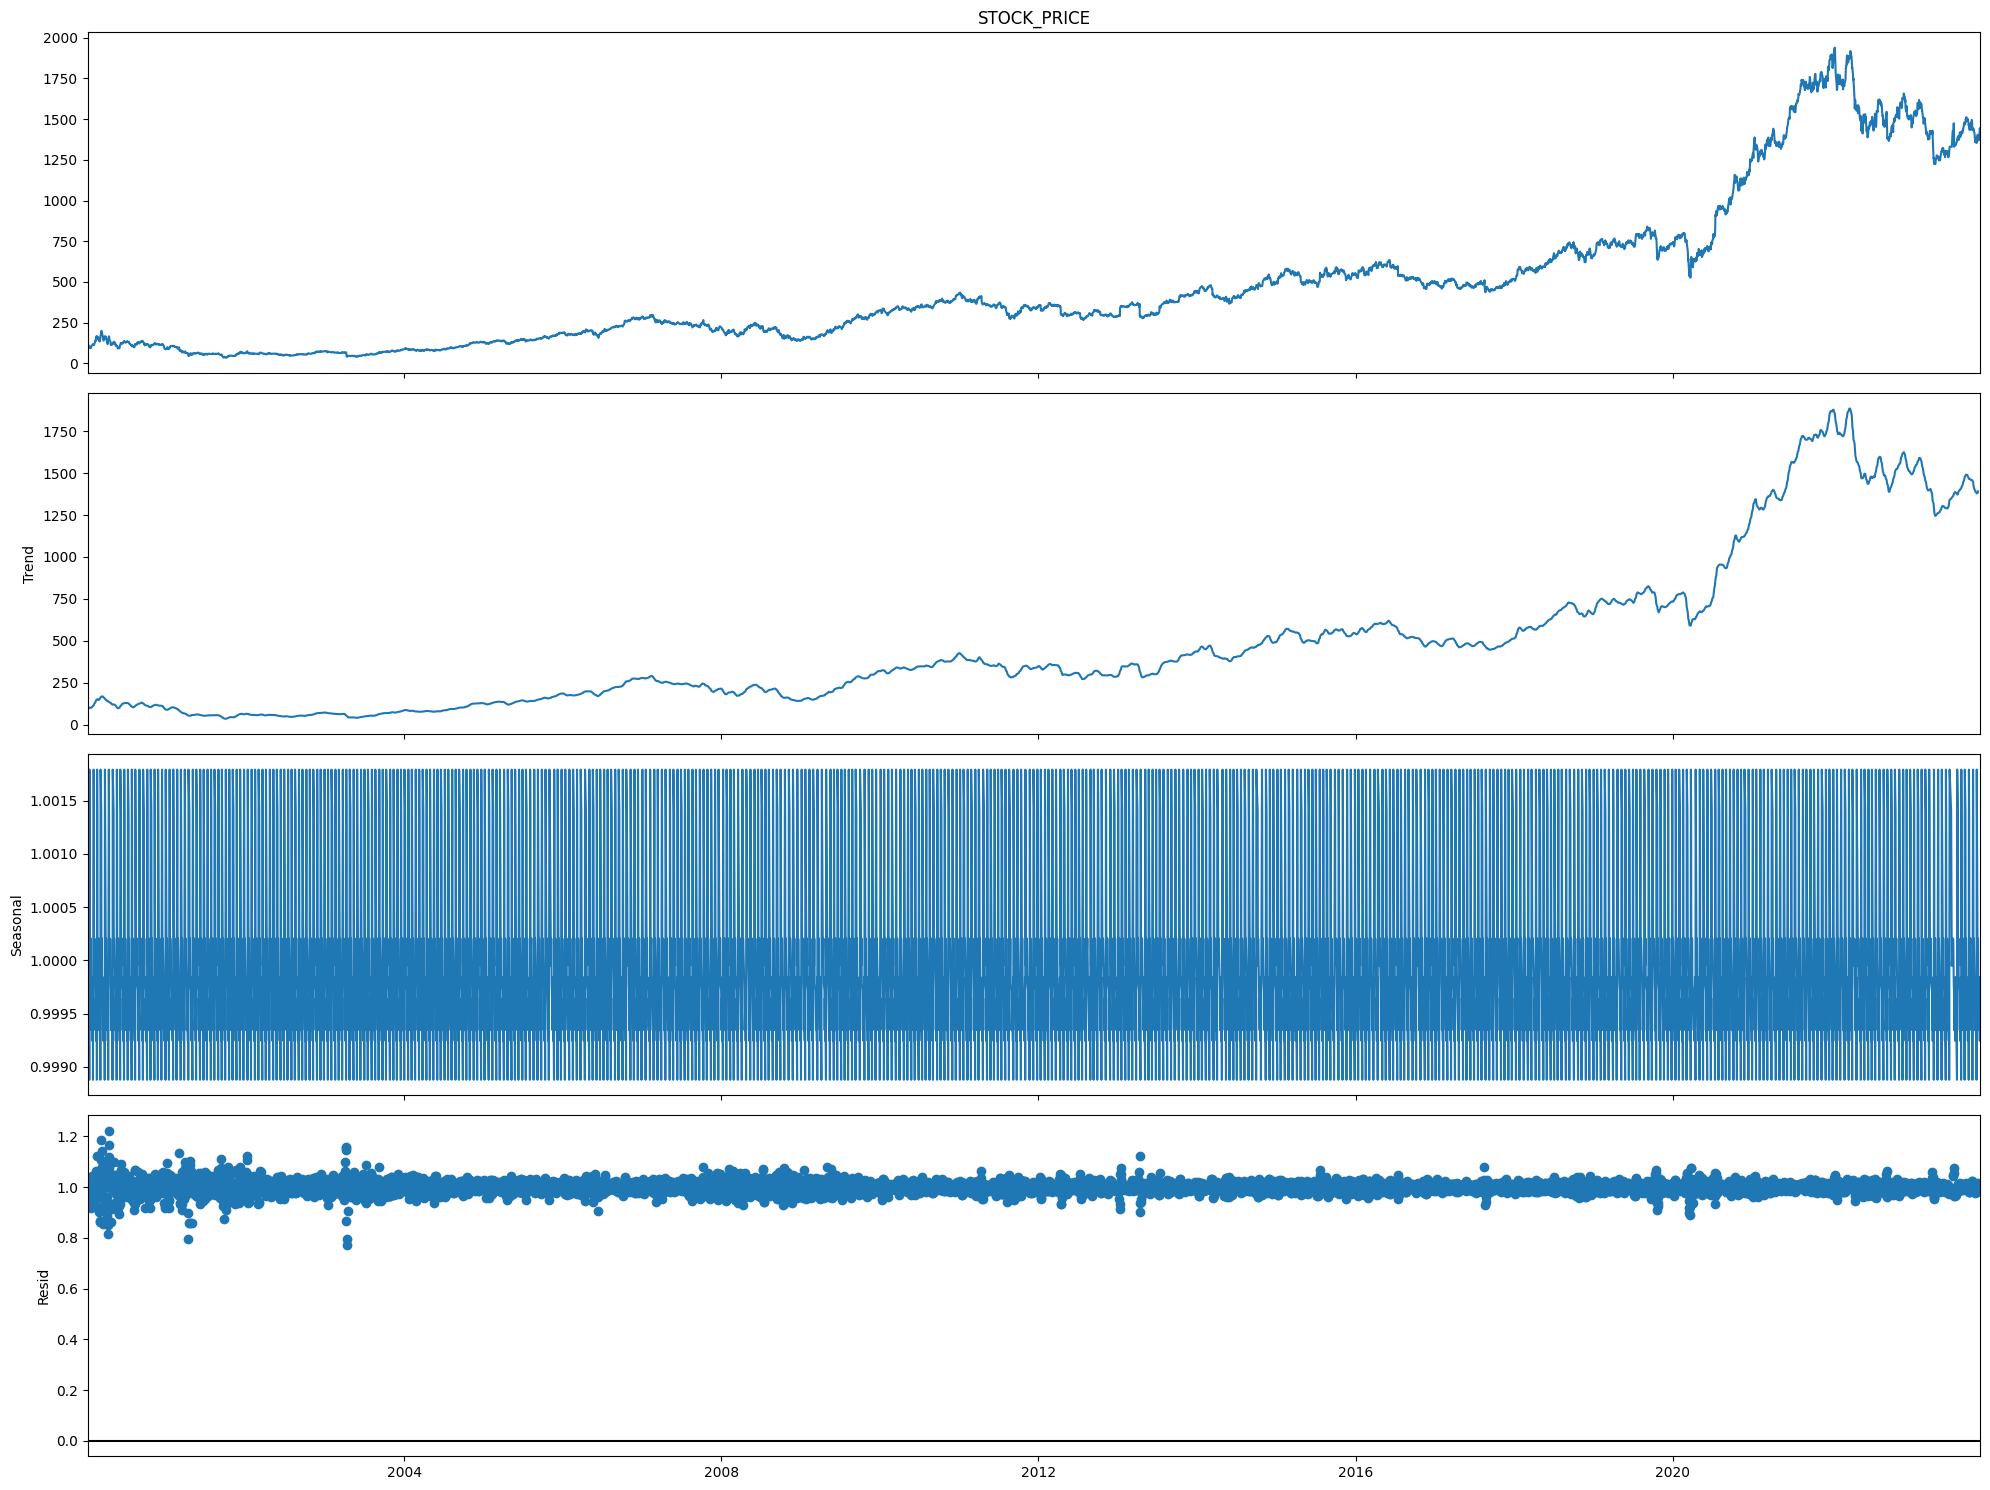

In [67]:
decompose_ts_mult = seasonal_decompose(stock_data.STOCK_PRICE,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(20,15))
    decompose_ts_mult.plot()
    plt.show()

##### **INFERENCE** #####
**We are getting the Trend, Seasonality and Residue using the 'Multiplicative Seasonality' decomposition method, for the INFOSYS Stock Trading** 
- The trend is a postive trend.
- There is no seasonality observed.
- We see that there is less noise/error in *Multiplicative Seasonality* when compared to *Additive Seasonality*.

### **SPLITTING TRAIN AND TEST DATA** ###

### ***Leaving Test Data with 2 Years of Time Series*** ###

In [68]:
stock_data_input = stock_data[['STOCK_PRICE']]

In [69]:
stock_data_input

STOCK_PRICE
DATE                   
2000-01-04   132.110931
2000-01-05   121.542191
2000-01-06   111.819138
2000-01-07   102.873825
2000-01-10   107.031250
...                 ...
2023-11-10  1368.699951
2023-11-13  1374.150024
2023-11-15  1411.150024
2023-11-16  1443.900024
2023-11-17  1437.650024

[5921 rows x 1 columns]

In [70]:
size = 0.8
train_data, test_data = stock_data_input[:int(len(stock_data_input)*size)], stock_data_input[int(len(stock_data_input)*size):]
#train_data, test_data = sdata[:int(len(sdata)*size)], sdata[int(len(sdata)*size):]


In [71]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 2000-01-04 00:00:00 2019-01-03 00:00:00 
 Test: 2019-01-04 00:00:00 2023-11-17 00:00:00


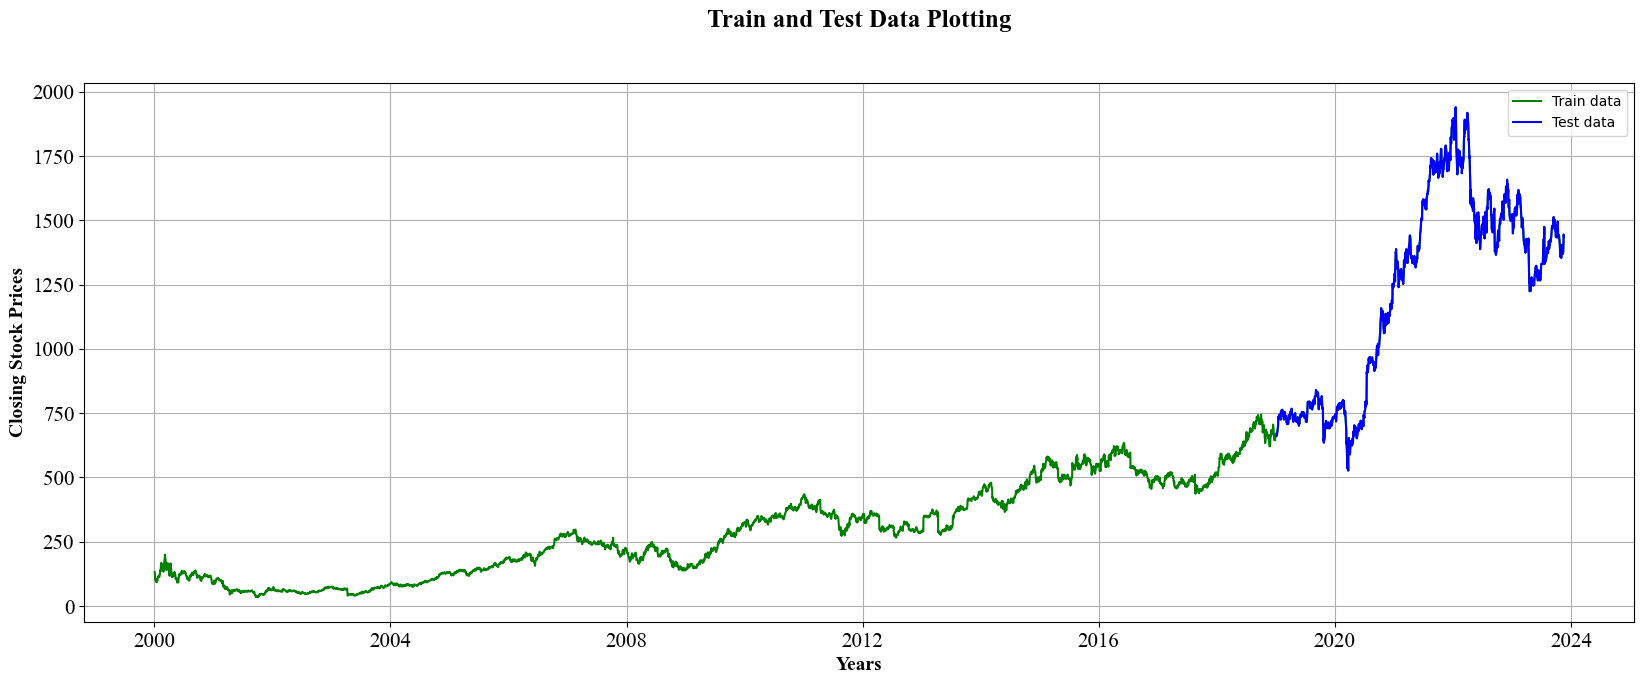

In [72]:
plt.figure(figsize=(20,7))
plt.grid(True)
plt.xlabel('Years', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.ylabel('Closing Stock Prices', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.xticks(fontfamily = "Times New Roman", size=15)
plt.yticks(fontfamily = "Times New Roman", size=15)
plt.plot(stock_data_input, color='green', label='Train data')
plt.plot(test_data, color='blue', label='Test data')
plt.title("Train and Test Data Plotting\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.legend()
plt.show()

In [73]:
def MAPE(pred,org):
    temp = ((pred-org)/org)
    return np.mean(temp)

### **EXPONENTIAL METHODS** ###

### ***Simple Exponential Method*** ###

#### **Using Forecast Attribute** ####

In [74]:
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

alpha = 0.2
ses_model = SimpleExpSmoothing(train_data).fit(smoothing_level = alpha, optimized = False)
test_pred_ses = ses_model.forecast(len(test_data.STOCK_PRICE))
test_pred_ses.index = test_data.index
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_data.STOCK_PRICE, test_pred_ses))
train_rmse_ses= sqrt(mean_squared_error(train_data.STOCK_PRICE, train_pred_ses))
mape_ses = mean_absolute_percentage_error(test_data.STOCK_PRICE, test_pred_ses)
print('Simple Exponential Method Evaluation',"\n", 'Mean Absolute Percent Error = {}'.format(mape_ses),"\n", 'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n", 'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 0.3952357953619566 
 Train Root Mean Squared Error = 9.097103916261531 
 Test Root Mean Squared Error = 681.8260634047043


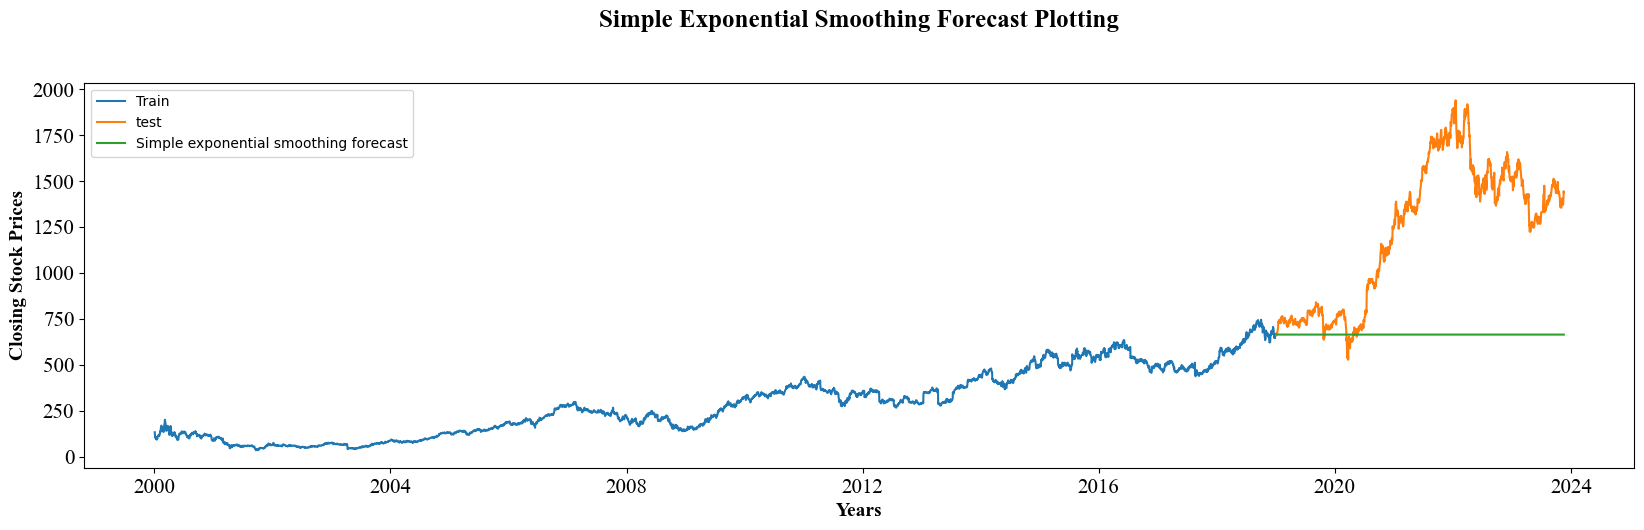

In [75]:
plt.figure(figsize=(20,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.xlabel('Years', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.ylabel('Closing Stock Prices', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.xticks(fontfamily = "Times New Roman", size=15)
plt.yticks(fontfamily = "Times New Roman", size=15)
plt.title("Simple Exponential Smoothing Forecast Plotting\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.legend(loc='best')
plt.show()

### ***Holt method (Double Exponential)*** ###

**Captures both Level and Trend**

In [76]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(len(test_data.STOCK_PRICE))
test_pred_dexp.index = test_data.index
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_data.STOCK_PRICE, test_pred_dexp))
train_rmse_dexp = sqrt(mean_squared_error(train_data.STOCK_PRICE, train_pred_dexp))
mape_dexp = mean_absolute_percentage_error(test_data.STOCK_PRICE, test_pred_dexp)
print('Simple Exponential Method Evaluation',"\n", 'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n", 'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n", 'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 0.4189457765677815 
 Train Root Mean Squared Error = 5.80998061677321 
 Test Root Mean Squared Error = 719.3157610571892


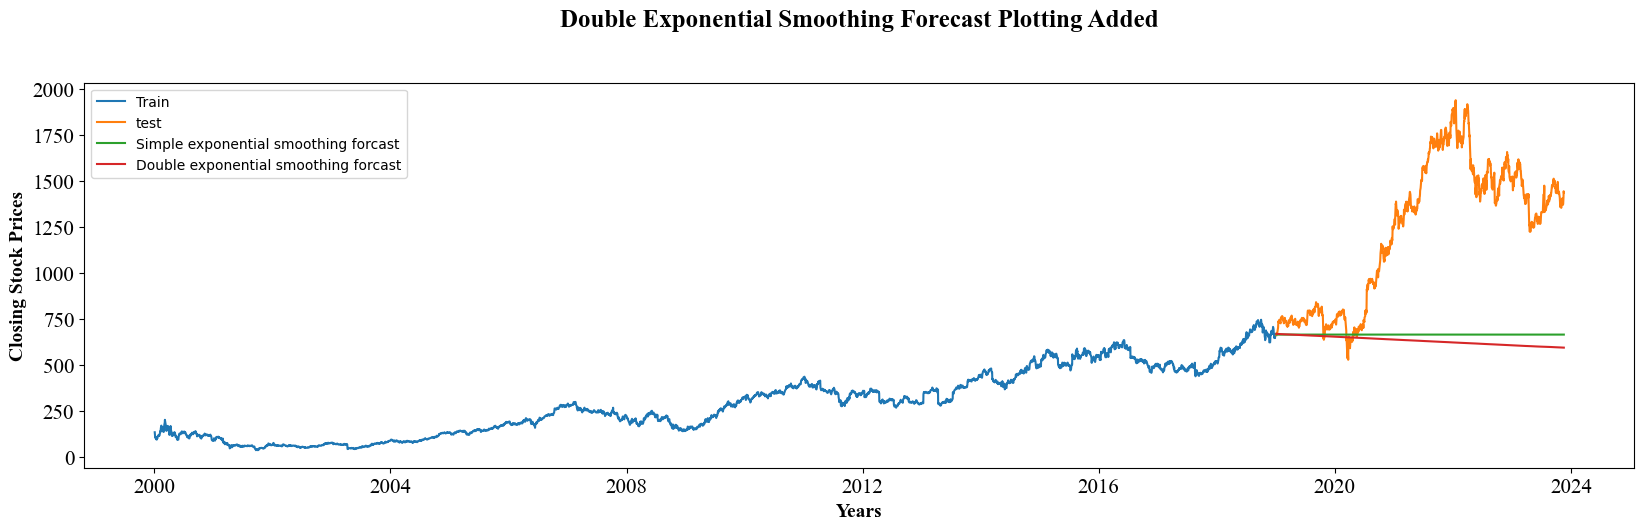

In [77]:
plt.figure(figsize=(20,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.xlabel('Years', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.ylabel('Closing Stock Prices', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.xticks(fontfamily = "Times New Roman", size=15)
plt.yticks(fontfamily = "Times New Roman", size=15)
plt.title("Double Exponential Smoothing Forecast Plotting Added\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.legend(loc='best')
plt.show()

### ***Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)*** ###

**Captures Level, Trend and Seasonality.**

In [78]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(len(test_data.STOCK_PRICE))
test_pred_ad_texp.index = test_data.index
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_data.STOCK_PRICE, test_pred_ad_texp))
train_rmse_ad_texp = sqrt(mean_squared_error(train_data.STOCK_PRICE, train_pred_ad_texp))
mape_ad_texp = mean_absolute_percentage_error(test_data.STOCK_PRICE, test_pred_ad_texp)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n", 'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n", 'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n", 'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 0.2699062213587106 
 Train Root Mean Squared Error = 5.862144579821798 
 Test Root Mean Squared Error = 481.5904763018767


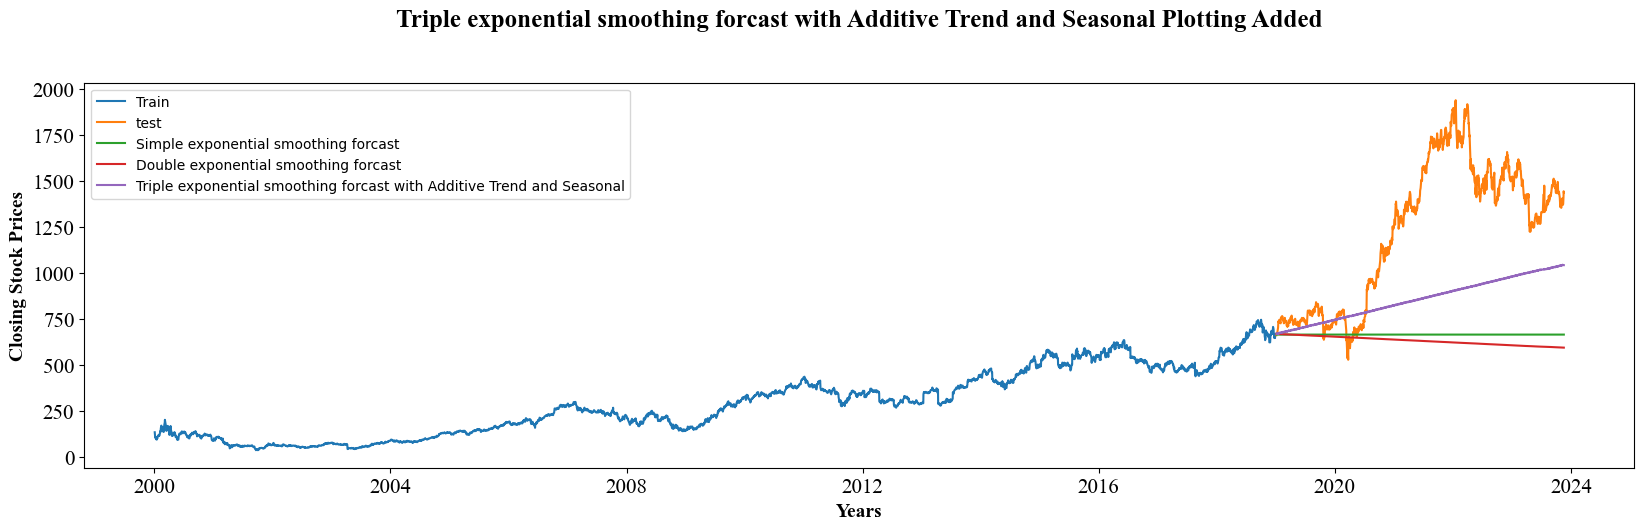

In [79]:
plt.figure(figsize=(20,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Seasonal')
plt.xlabel('Years', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.ylabel('Closing Stock Prices', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.xticks(fontfamily = "Times New Roman", size=15)
plt.yticks(fontfamily = "Times New Roman", size=15)
plt.title("Triple exponential smoothing forcast with Additive Trend and Seasonal Plotting Added\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.legend(loc='best')
plt.show()

### ***Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)*** ###

**Captures Level, Trend and Seasonality.**

In [80]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(len(test_data.STOCK_PRICE))
test_pred_mul_ad_texp.index = test_data.index
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_data.STOCK_PRICE, test_pred_mul_ad_texp))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_data.STOCK_PRICE, train_pred_mul_ad_texp))
mape_mul_ad_texp = mean_absolute_percentage_error(test_data.STOCK_PRICE, test_pred_mul_ad_texp)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 0.23755499988021808 
 Train Root Mean Squared Error = 5.911882714879305 
 Test Root Mean Squared Error = 427.459482398026


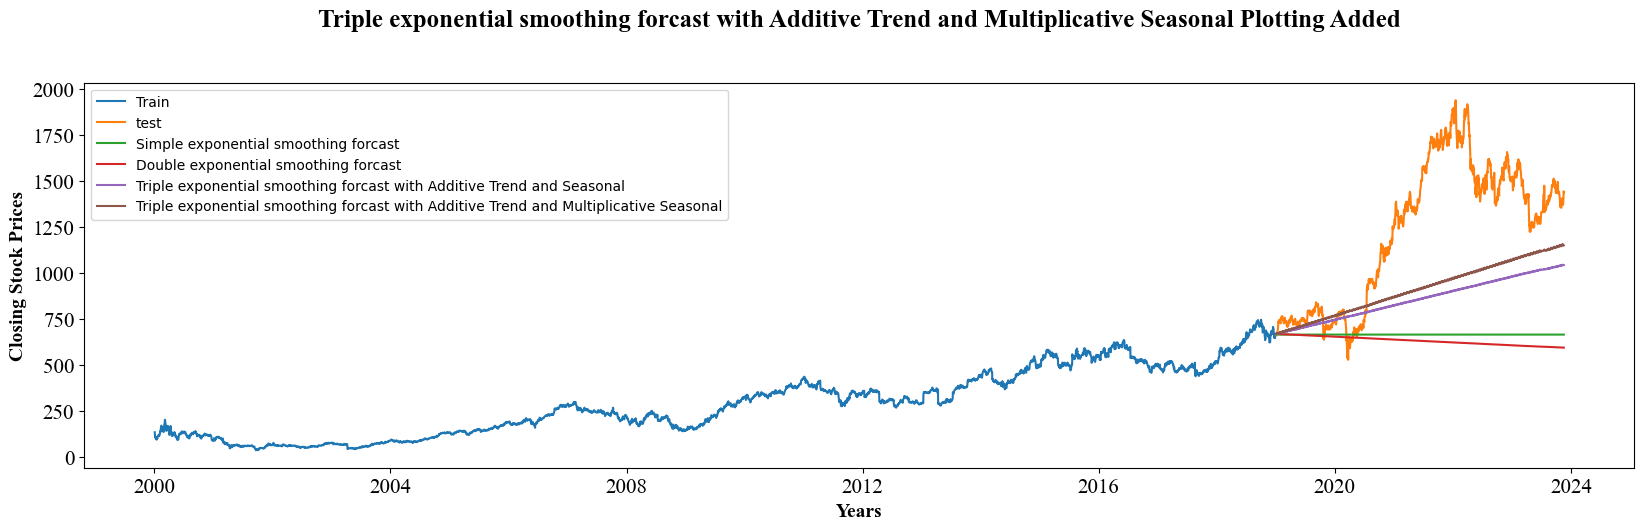

In [81]:
plt.figure(figsize=(20,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Seasonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Seasonal')
plt.xlabel('Years', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.ylabel('Closing Stock Prices', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.xticks(fontfamily = "Times New Roman", size=15)
plt.yticks(fontfamily = "Times New Roman", size=15)
plt.title("Triple exponential smoothing forcast with Additive Trend and Multiplicative Seasonal Plotting Added\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.legend(loc='best')
plt.show()

### ***Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)*** ###

In [82]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(len(test_data.STOCK_PRICE))
test_pred_ad_mul_texp.index = test_data.index
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_data.STOCK_PRICE, test_pred_ad_mul_texp))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_data.STOCK_PRICE, train_pred_ad_mul_texp))
mape_ad_mul_texp  = mean_absolute_percentage_error(test_data.STOCK_PRICE, test_pred_ad_mul_texp)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 0.9008385139966741 
 Train Root Mean Squared Error = 12.464837464053847 
 Test Root Mean Squared Error = 1251.4335726437944


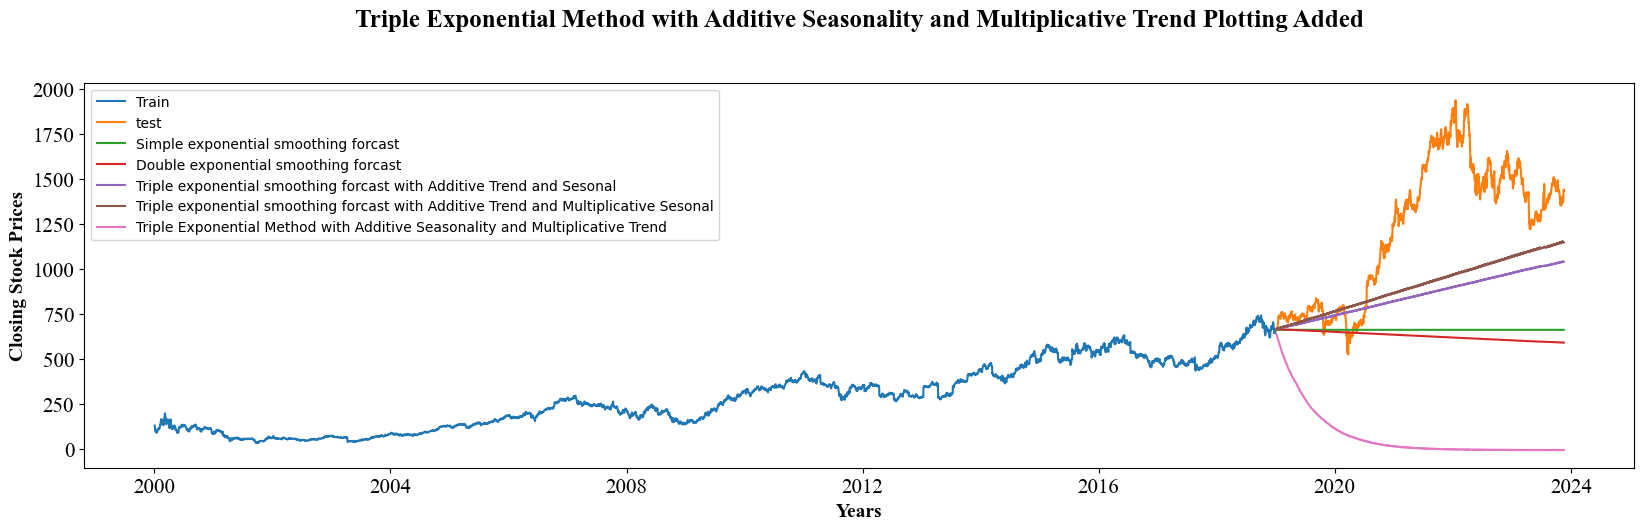

In [83]:
plt.figure(figsize=(20,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.xlabel('Years', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.ylabel('Closing Stock Prices', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.xticks(fontfamily = "Times New Roman", size=15)
plt.yticks(fontfamily = "Times New Roman", size=15)
plt.title("Triple Exponential Method with Additive Seasonality and Multiplicative Trend Plotting Added\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.legend(loc='best')
plt.show()

### ***Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)*** ###

In [84]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(len(test_data.STOCK_PRICE))
test_pred_mul_texp.index = test_data.index
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_data.STOCK_PRICE, test_pred_mul_texp))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_data.STOCK_PRICE, train_pred_mul_texp))
mape_mul_texp  = mean_absolute_percentage_error(test_data.STOCK_PRICE, test_pred_mul_texp)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 0.38230364279345835 
 Train Root Mean Squared Error = 5.955517766867298 
 Test Root Mean Squared Error = 663.6520452670078


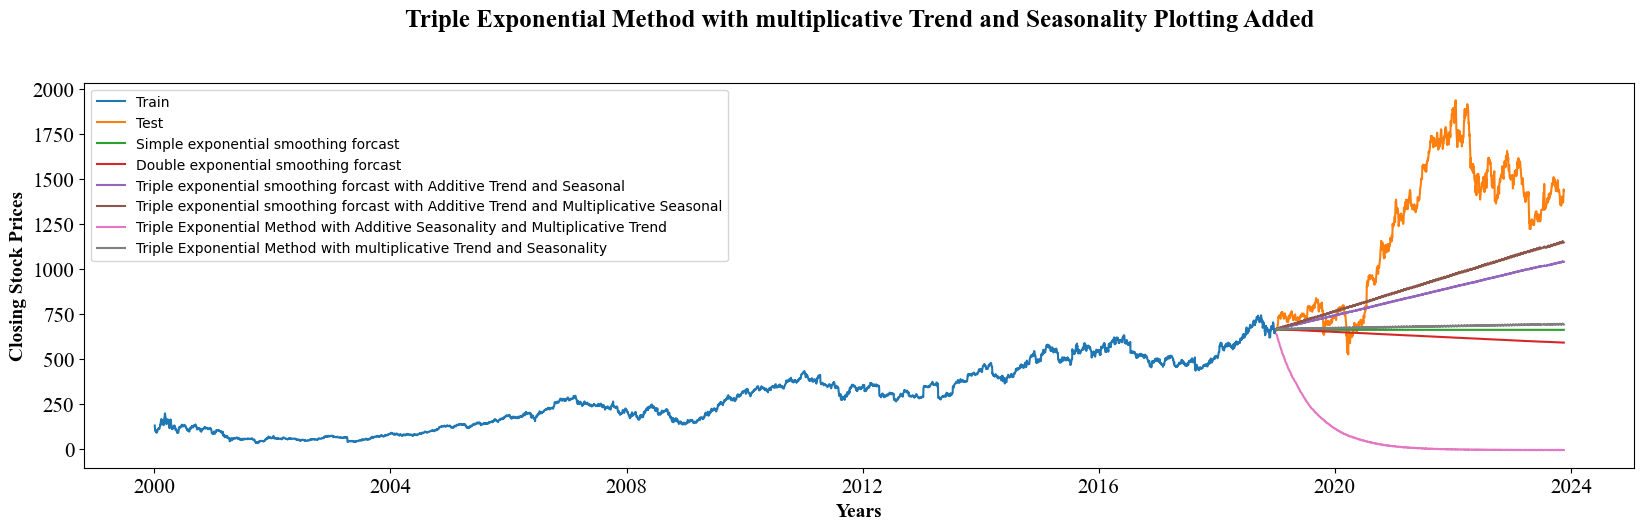

In [85]:
plt.figure(figsize=(20,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Seasonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Seasonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.xlabel('Years', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.ylabel('Closing Stock Prices', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.xticks(fontfamily = "Times New Roman", size=15)
plt.yticks(fontfamily = "Times New Roman", size=15)
plt.title("Triple Exponential Method with multiplicative Trend and Seasonality Plotting Added\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.legend(loc='best')
plt.show()

In [86]:
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul","Triple_Exp_mul"]),"Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),"Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),"Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0  Triple_Exp_mul_ad    5.911883      0.237555        427.459482
1      Triple_Exp_ad    5.862145      0.269906        481.590476
2     Triple_Exp_mul    5.955518      0.382304        663.652045
3         Simple_Exp    9.097104      0.395236        681.826063
4         Double_Exp    5.809981      0.418946        719.315761
5  Triple_Exp_ad_mul   12.464837      0.900839       1251.433573

### **VISUALIZING MODELS PERFORMANCE** ###

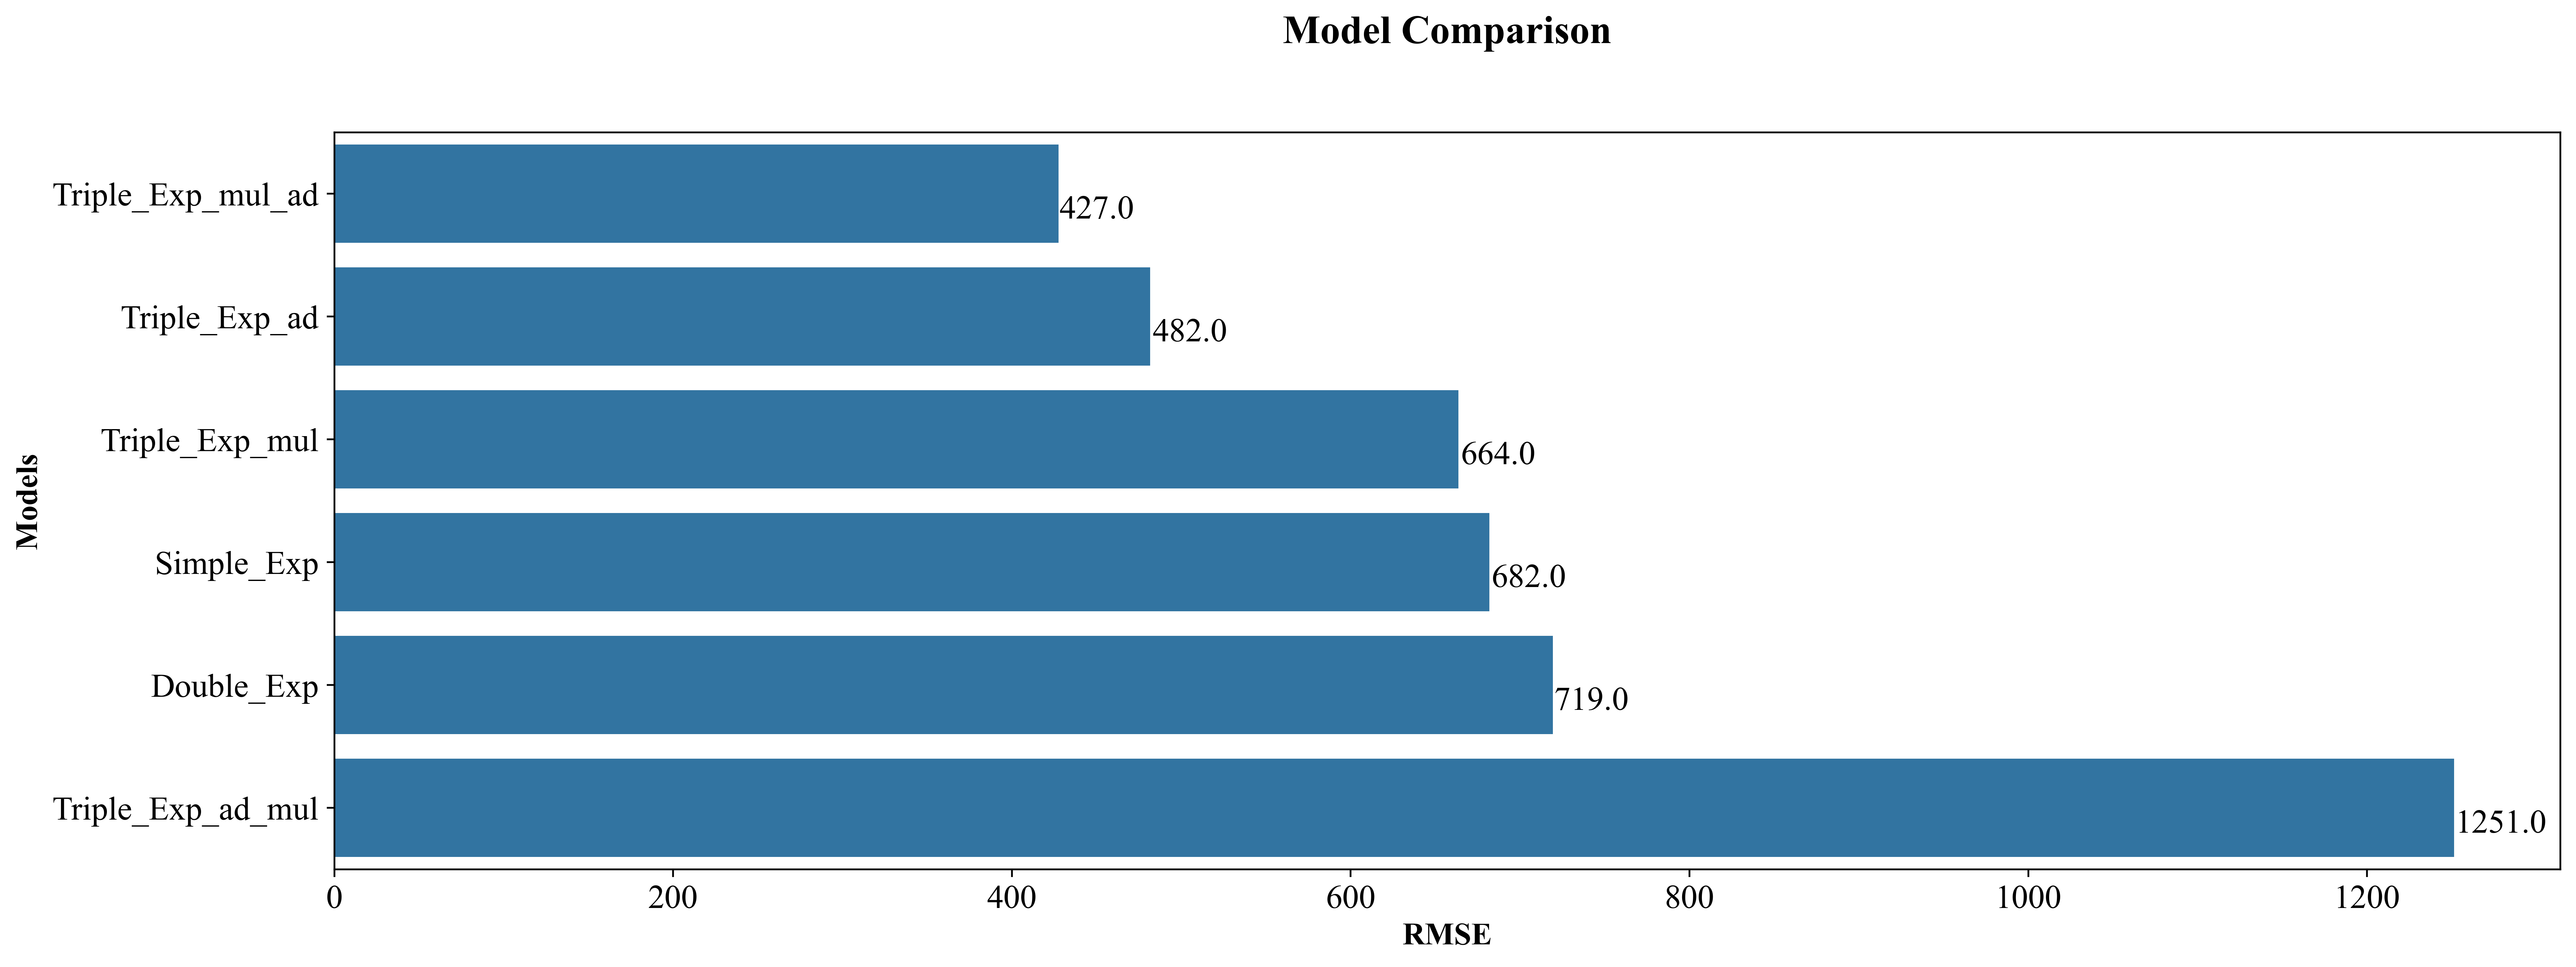

In [87]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
plt.xlabel('RMSE', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.ylabel('Models', weight='bold', fontfamily = "Times New Roman", size = '14')
plt.xticks(fontfamily = "Times New Roman", size=15)
plt.yticks(fontfamily = "Times New Roman", size=15)
plt.title("Model Comparison\n\n", verticalalignment="center", weight='bold', fontfamily = "Times New Roman", size = '18')
for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontfamily = "Times New Roman", size=15)

plt.show()

### **AUTOREGRESSIVE INTEGRATED MOVING AVERAGES (ARIMA)** ###

### ***Test of Stationarity*** ###

In [88]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    f, axes = plt.subplots(1,1, figsize=(20,7))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['STOCK_PRICE'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### ***Augmented Dickey–Fuller test*** ###

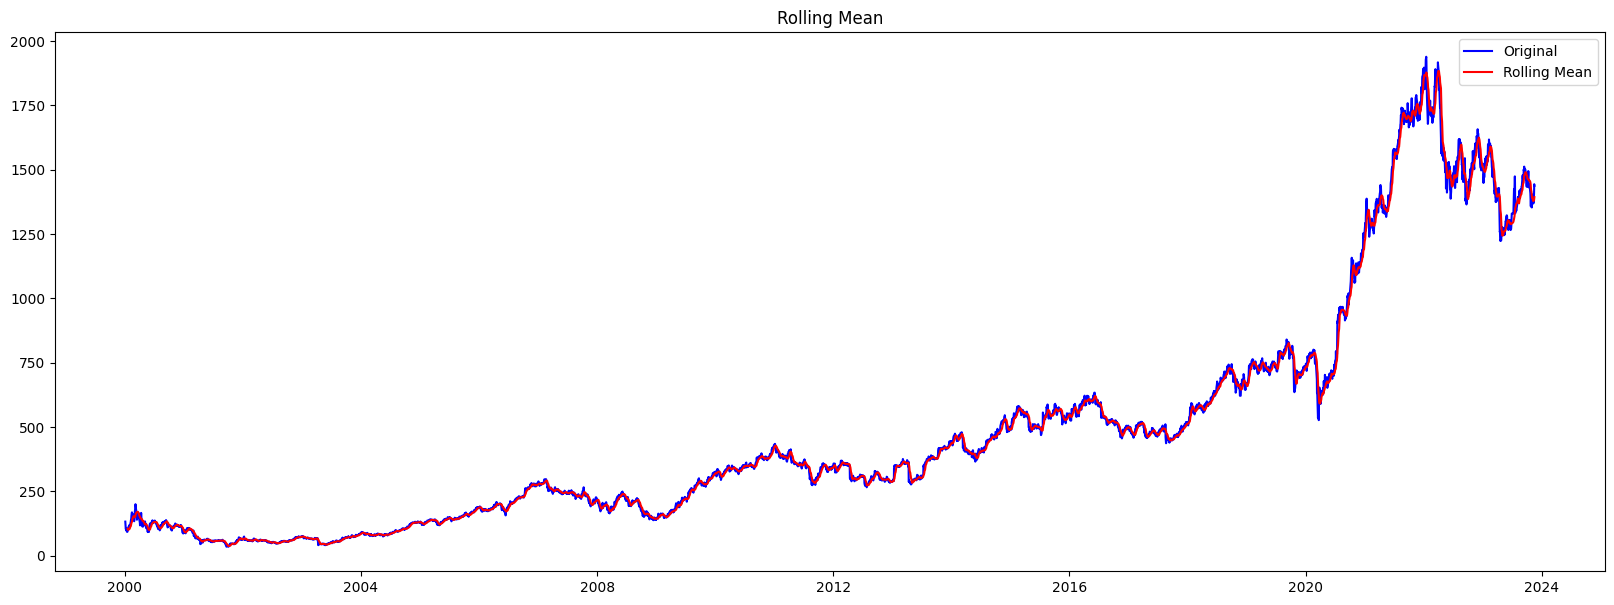

Results of Dickey Fuller Test:
Test Statistic                    0.582492
p-value                           0.987176
#Lags Used                       33.000000
Number of Observations Used    5887.000000
Critical Value (1%)              -3.431461
Critical Value (5%)              -2.862031
Critical Value (10%)             -2.567031
dtype: float64


In [89]:
stocks= pd.DataFrame()
stocks['STOCK_PRICE'] = stock_data[['STOCK_PRICE']]
test_stationarity(stocks)

In [90]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    print(f"Running 'Augmented Dickey–Fuller test' on the data:") 
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [91]:
adf_test(stocks)

Running 'Augmented Dickey–Fuller test' on the data:


Fail to reject the null hypothesis
Data is non-stationary


### ***Feature Scaling (Transformations)*** ###

#### **Square Root Transform** ####

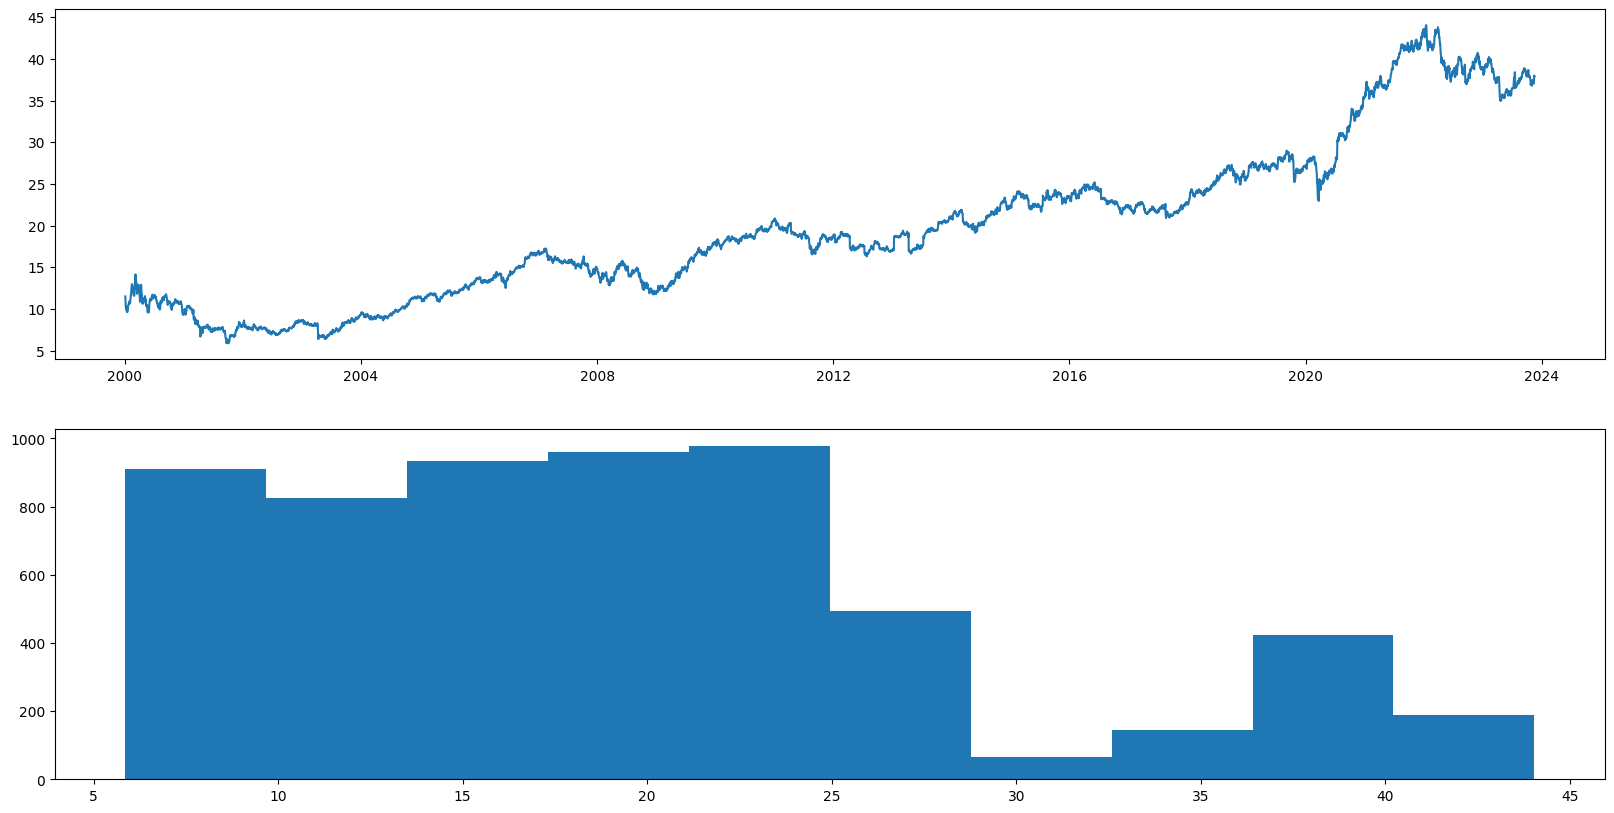

In [92]:
square_root= pd.DataFrame()
square_root['STOCK_PRICE'] = stock_data[['STOCK_PRICE']]
square_root['STOCK_PRICE'] = np.sqrt(square_root.STOCK_PRICE)

# line chart
fig=plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(square_root['STOCK_PRICE'])

#Histogram
plt.subplot(212)
plt.hist(square_root['STOCK_PRICE'])
plt.show()

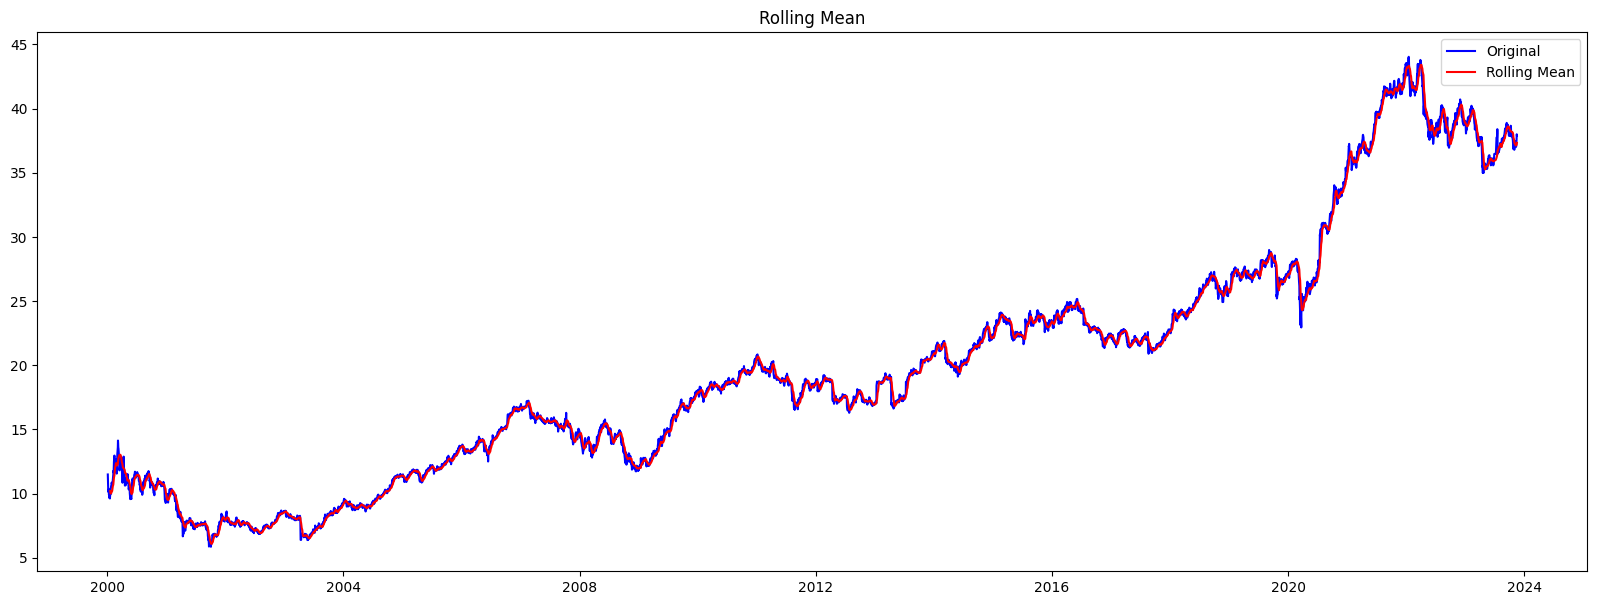

Results of Dickey Fuller Test:
Test Statistic                    0.118896
p-value                           0.967328
#Lags Used                        6.000000
Number of Observations Used    5914.000000
Critical Value (1%)              -3.431456
Critical Value (5%)              -2.862029
Critical Value (10%)             -2.567030
dtype: float64


In [93]:
test_stationarity(square_root)

In [94]:
adf_test(square_root)

Running 'Augmented Dickey–Fuller test' on the data:


Fail to reject the null hypothesis
Data is non-stationary


#### **Log Transform** ####

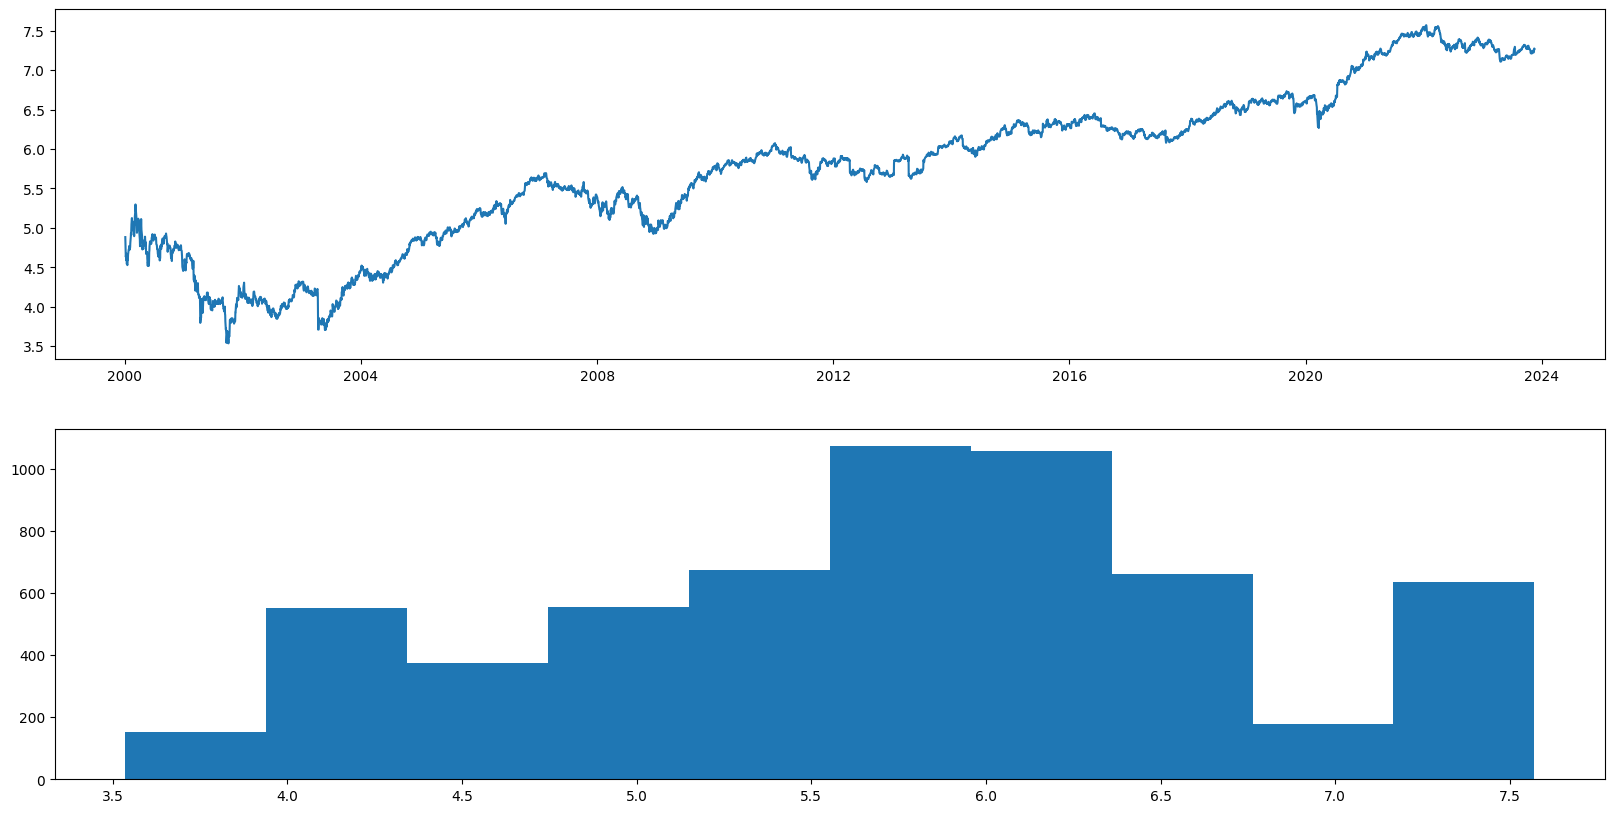

In [95]:
log = pd.DataFrame()

# log = al_data[['STOCK_PRICE']]
log['STOCK_PRICE'] = np.log(stock_data[['STOCK_PRICE']])

# line chart
fig=plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(log['STOCK_PRICE'])
#Histogram
plt.subplot(212)
plt.hist(log['STOCK_PRICE'])
plt.show()

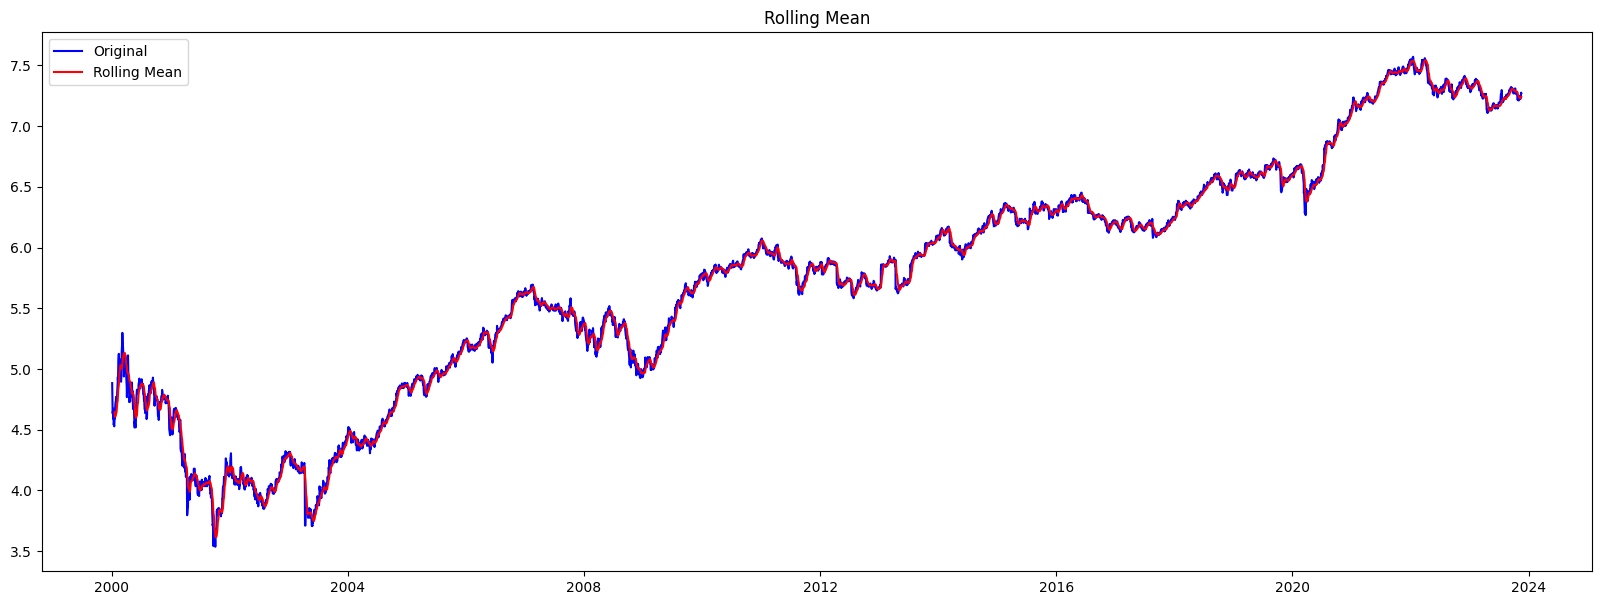

Results of Dickey Fuller Test:
Test Statistic                   -0.545704
p-value                           0.882785
#Lags Used                       12.000000
Number of Observations Used    5908.000000
Critical Value (1%)              -3.431457
Critical Value (5%)              -2.862029
Critical Value (10%)             -2.567030
dtype: float64


In [96]:
test_stationarity(log)

In [97]:
adf_test(log)

Running 'Augmented Dickey–Fuller test' on the data:


Fail to reject the null hypothesis
Data is non-stationary


**Therefore the Time series data is Non-Stationary**

### ***Converting Non-Stationary Time Series into Stationary*** ###

#### **Differencing** ####

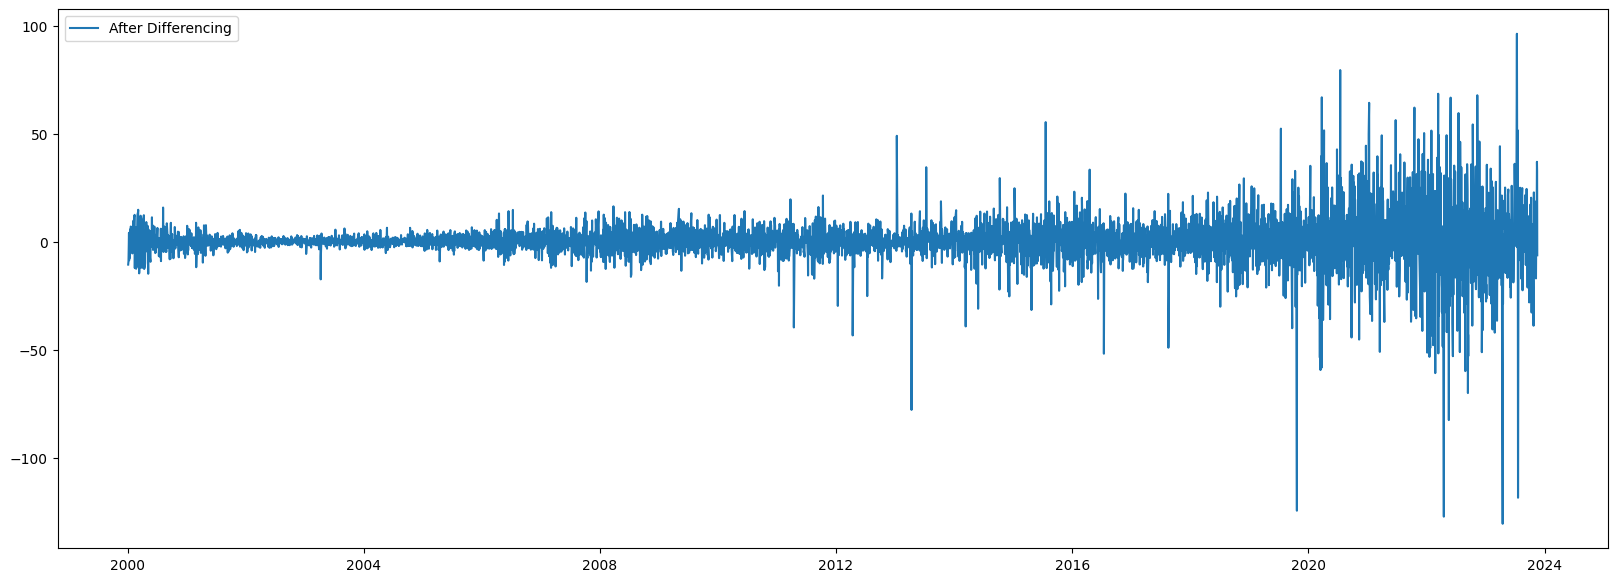

In [98]:
differencing = stocks - stocks.shift(1)
differencing.dropna(inplace=True)
f, axes = plt.subplots(1,1, figsize=(20,7))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

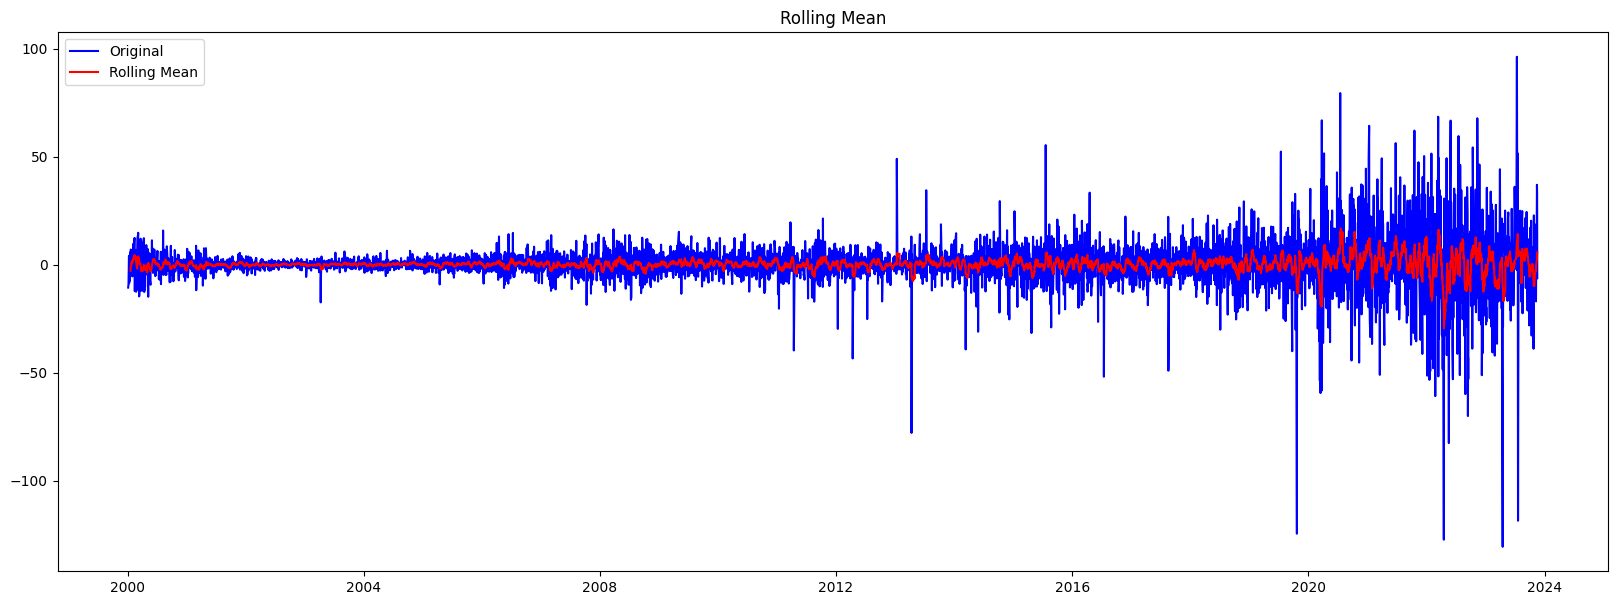

Results of Dickey Fuller Test:
Test Statistic                -1.539954e+01
p-value                        3.228942e-28
#Lags Used                     3.200000e+01
Number of Observations Used    5.887000e+03
Critical Value (1%)           -3.431461e+00
Critical Value (5%)           -2.862031e+00
Critical Value (10%)          -2.567031e+00
dtype: float64


In [99]:
test_stationarity(differencing)

#### **Seasonal Differencing** ####

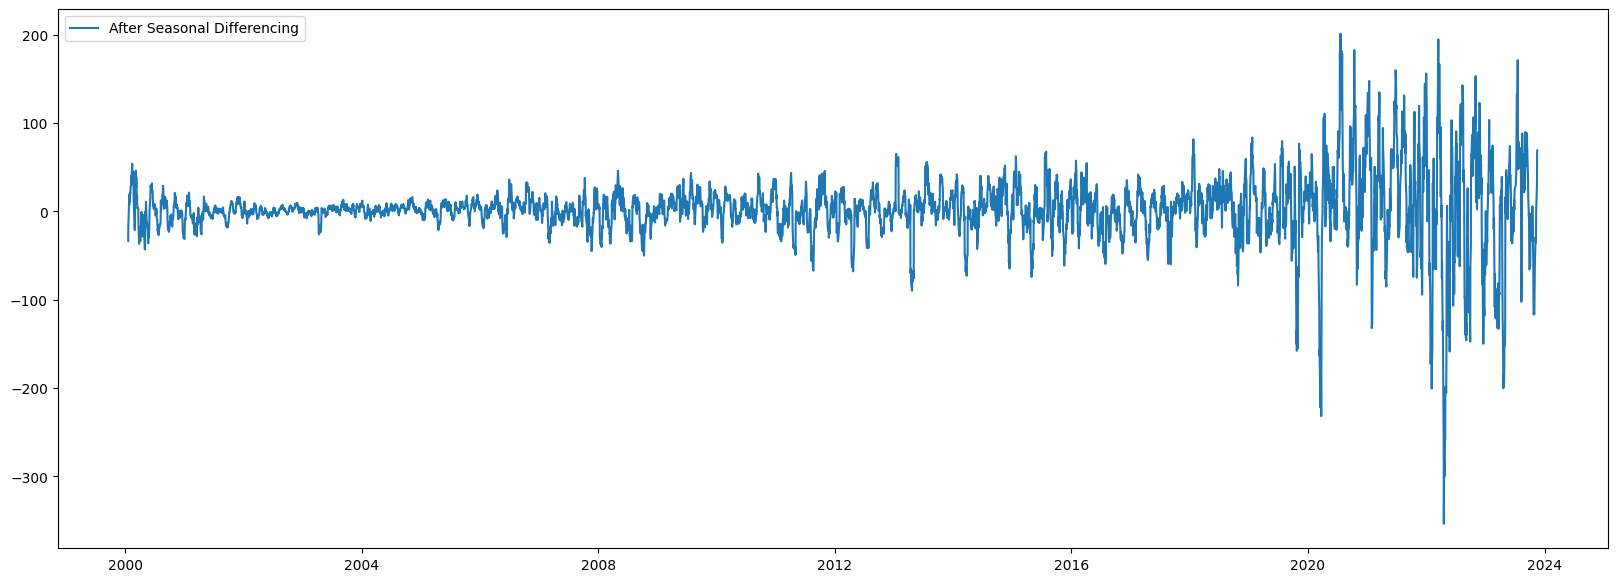

In [100]:
seasonal_differencing = stocks - stocks.shift(12)
seasonal_differencing.dropna(inplace=True)
f, axes = plt.subplots(1,1, figsize=(20,7))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

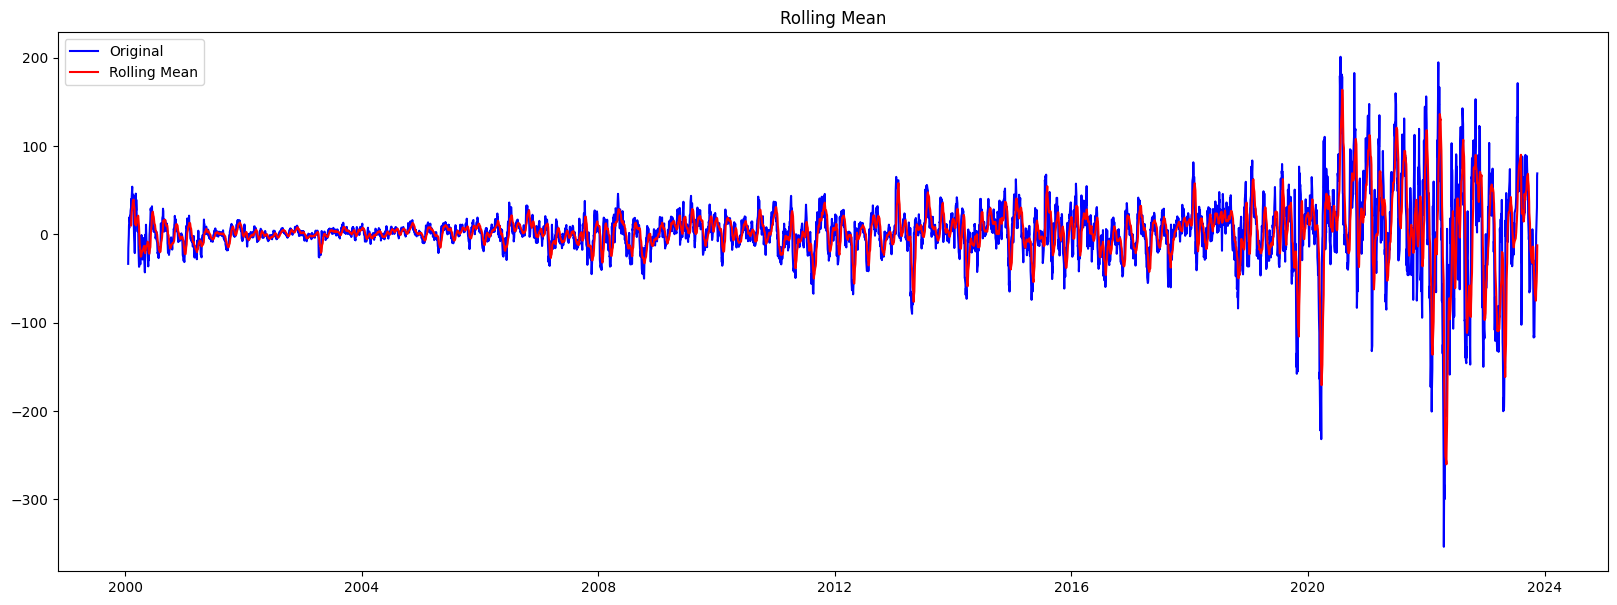

Results of Dickey Fuller Test:
Test Statistic                -1.355959e+01
p-value                        2.323904e-25
#Lags Used                     3.400000e+01
Number of Observations Used    5.874000e+03
Critical Value (1%)           -3.431464e+00
Critical Value (5%)           -2.862032e+00
Critical Value (10%)          -2.567032e+00
dtype: float64


In [101]:
test_stationarity(seasonal_differencing)

In [102]:
adf_test(seasonal_differencing)

Running 'Augmented Dickey–Fuller test' on the data:
Reject the null hypothesis
Data is stationary


#### **Transformation** ####

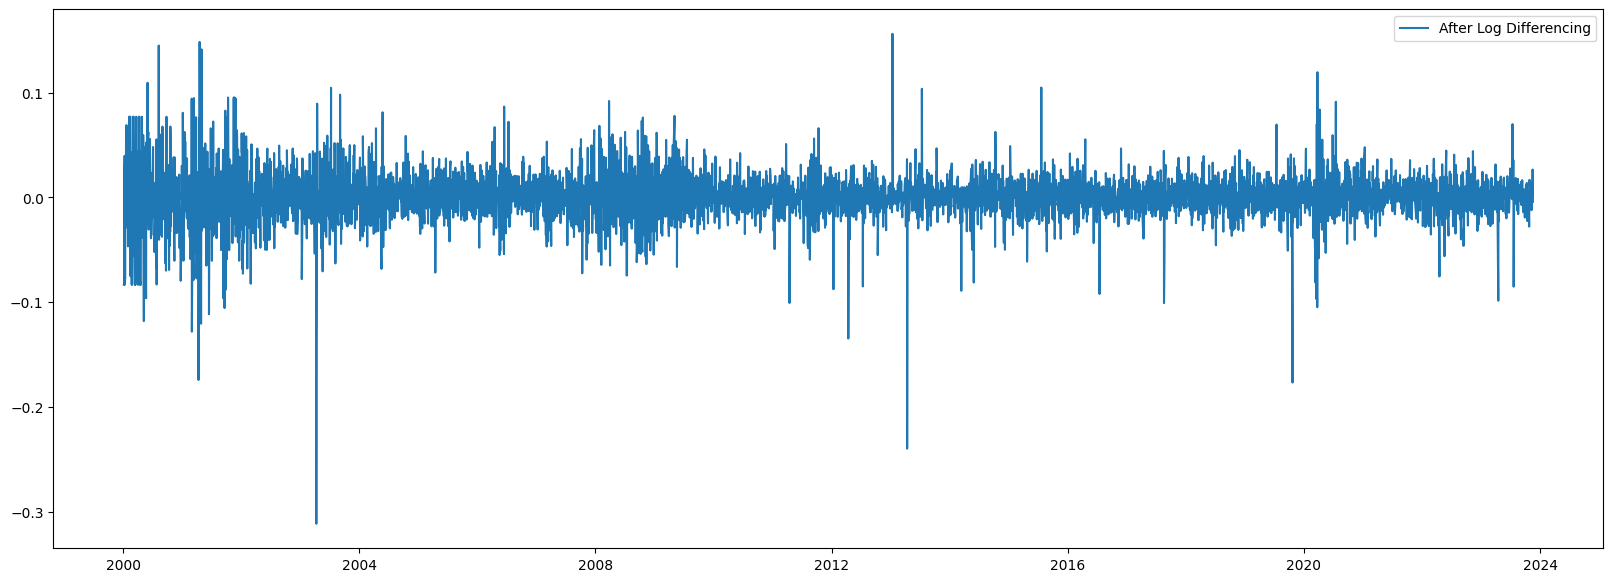

In [103]:
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)
f, axes = plt.subplots(1,1, figsize=(20,7))
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')
plt.show()

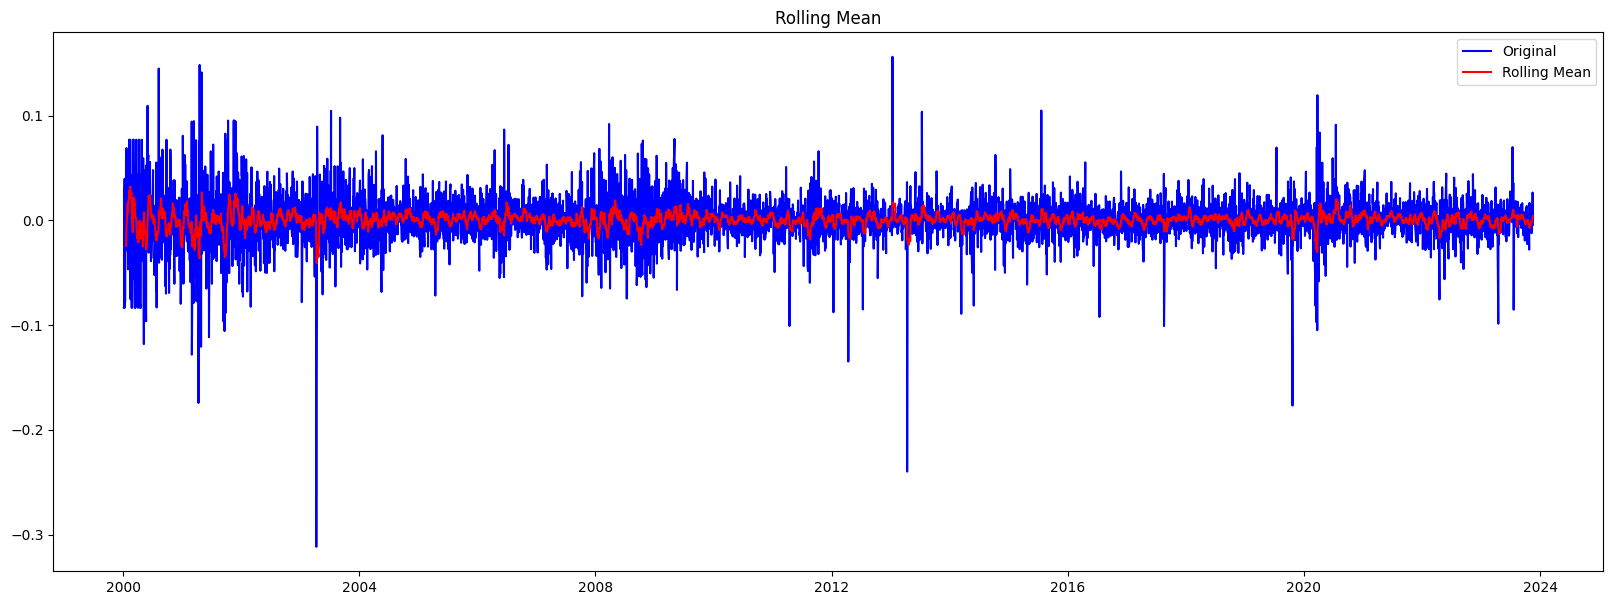

Results of Dickey Fuller Test:
Test Statistic                -1.537437e+01
p-value                        3.474213e-28
#Lags Used                     2.900000e+01
Number of Observations Used    5.890000e+03
Critical Value (1%)           -3.431461e+00
Critical Value (5%)           -2.862031e+00
Critical Value (10%)          -2.567031e+00
dtype: float64


In [104]:
test_stationarity(log_diff)

In [105]:
adf_test(log_diff)

Running 'Augmented Dickey–Fuller test' on the data:
Reject the null hypothesis
Data is stationary


#### **Box Cox Transformation** ####

STOCK_PRICE
DATE                   
2000-01-04     4.883642
2000-01-05     4.800261
2000-01-06     4.716883
2000-01-07     4.633503
2000-01-10     4.673121

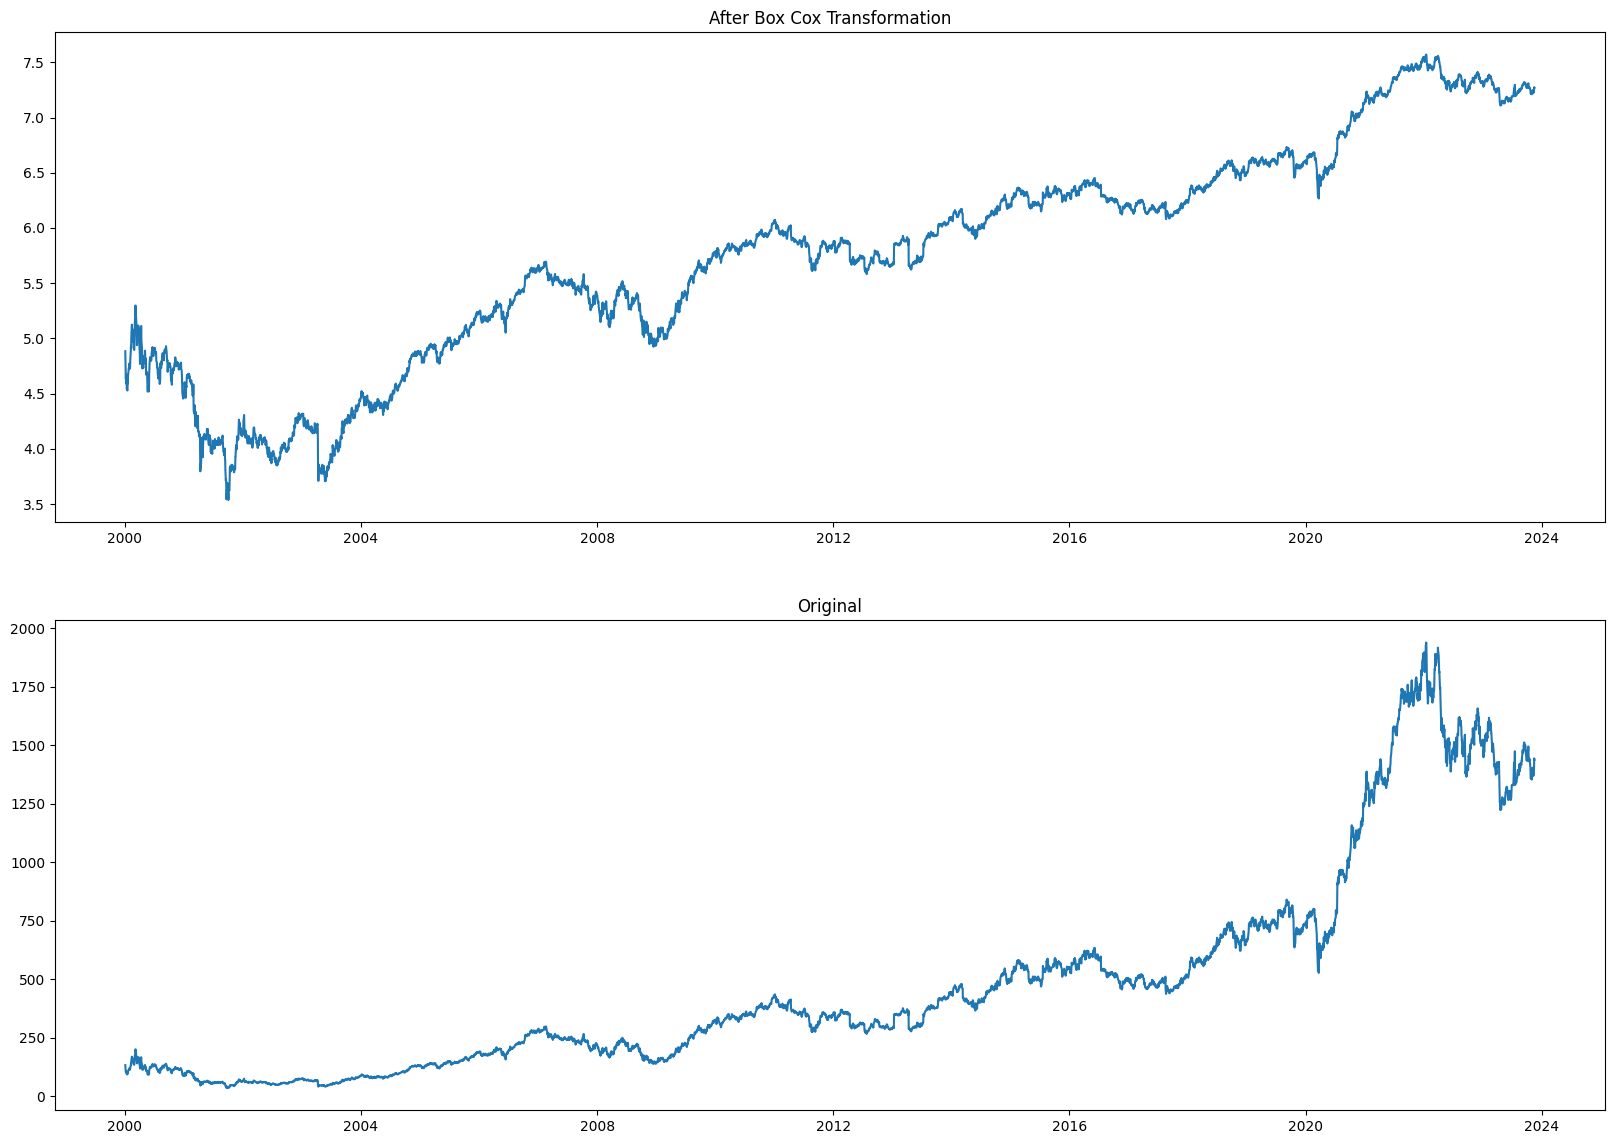

In [106]:
data_boxcox = pd.DataFrame()
data_boxcox['STOCK_PRICE'] = pd.Series(boxcox(stocks['STOCK_PRICE'], lmbda=0), stocks.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(20,14),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(stocks, label='original')
axis[1].set_title('Original')
plt.show()

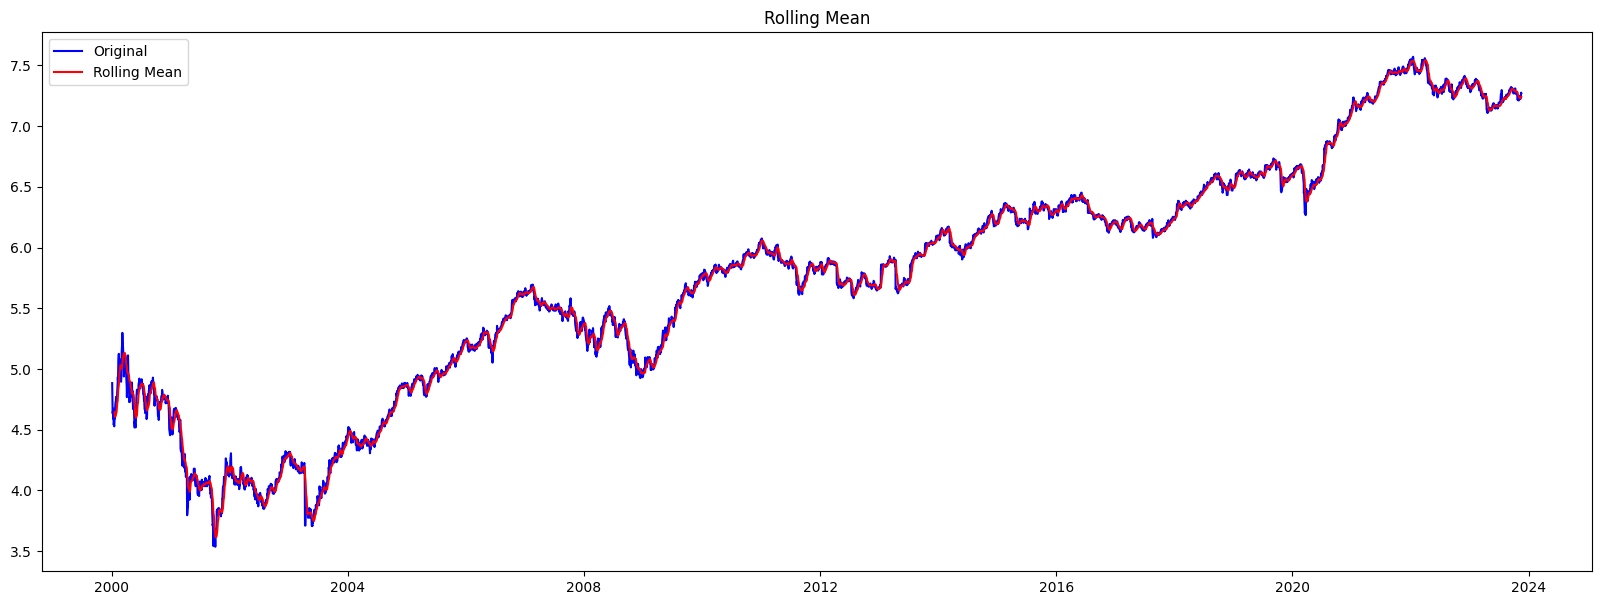

Results of Dickey Fuller Test:
Test Statistic                   -0.545704
p-value                           0.882785
#Lags Used                       12.000000
Number of Observations Used    5908.000000
Critical Value (1%)              -3.431457
Critical Value (5%)              -2.862029
Critical Value (10%)             -2.567030
dtype: float64


In [107]:
test_stationarity(data_boxcox)

In [108]:
adf_test(data_boxcox)

Running 'Augmented Dickey–Fuller test' on the data:


Fail to reject the null hypothesis
Data is non-stationary


#### **Differencing of the Box-Cox Transformation** ####

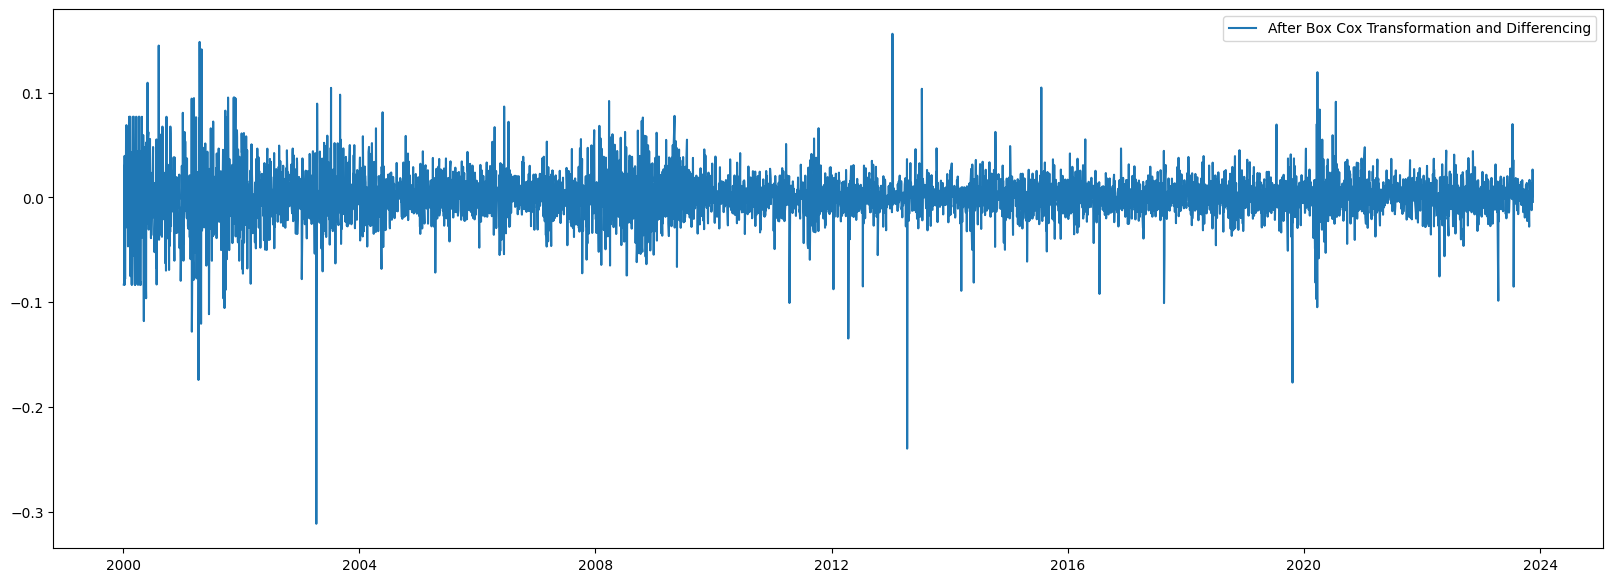

In [109]:
# Differencing of the Box-Cox Transformation
data_boxcox_diff = data_boxcox - data_boxcox.shift() # Performs difference between the previous and current observations.
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(20,7))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

<Figure size 2000x700 with 0 Axes>

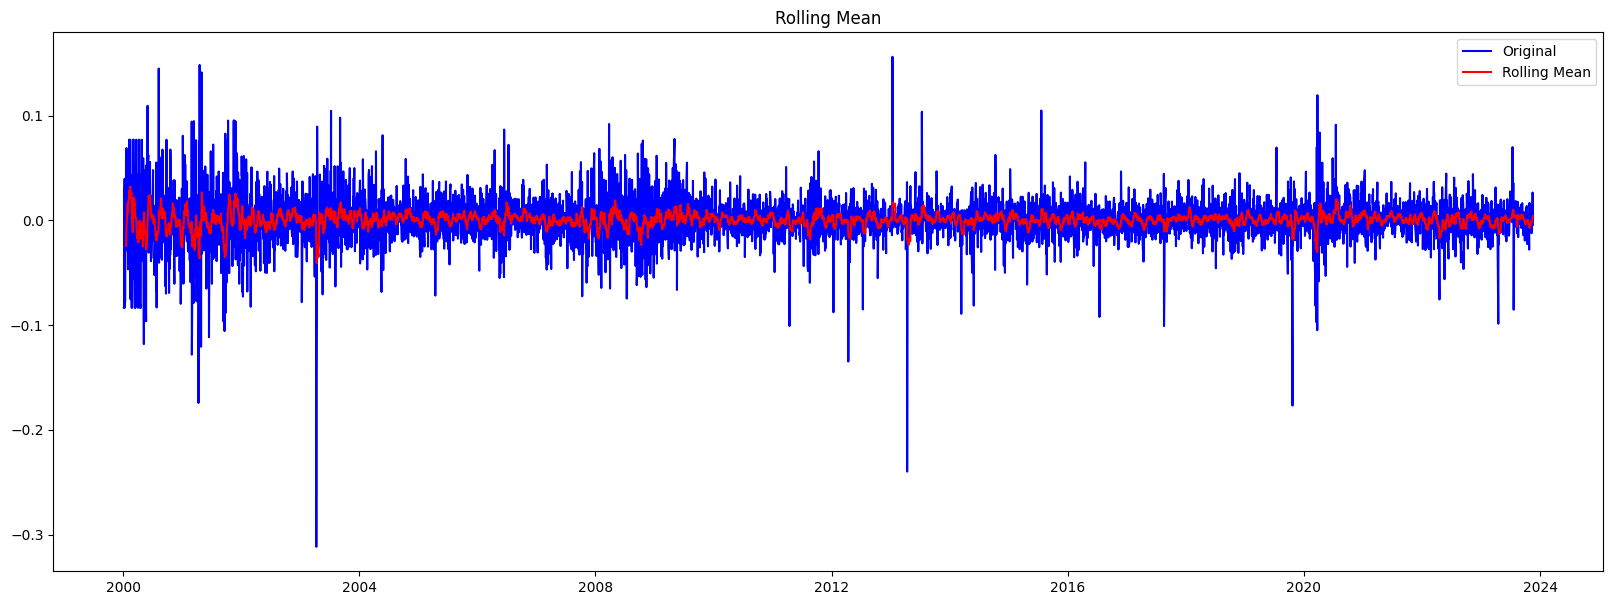

Results of Dickey Fuller Test:
Test Statistic                -1.537437e+01
p-value                        3.474213e-28
#Lags Used                     2.900000e+01
Number of Observations Used    5.890000e+03
Critical Value (1%)           -3.431461e+00
Critical Value (5%)           -2.862031e+00
Critical Value (10%)          -2.567031e+00
dtype: float64


In [110]:
# Check this log transfered data with function
plt.figure(figsize=(20,7))
test_stationarity(data_boxcox_diff)
plt.show()

In [111]:
adf_test(data_boxcox_diff)

Running 'Augmented Dickey–Fuller test' on the data:


Reject the null hypothesis
Data is stationary


**Finally, Our Series is now stationary for AR Forecasting**

### **ARIMA HYPERPARAMETER TUNING** ###

##### **Inverse transformation of the Box-Cox Differencing** #####

As we have converted the original time series to Stationary series by consecutively applying BoxCox transformation and Differencing. We have to transform the series back to the original one (step by step).

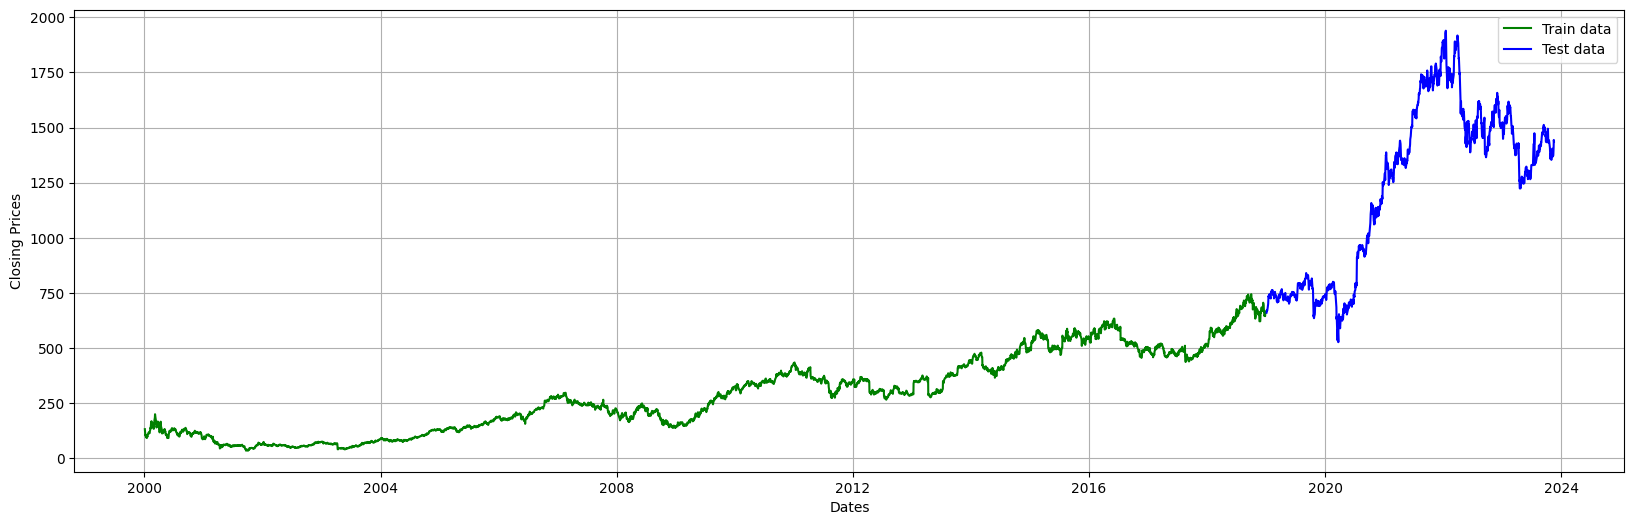

In [112]:
# Split data into train and training set and plotting based on the non-stationary data
size = 0.8
train_data, test_data = stock_data_input[:int(len(stock_data_input)*size)], stock_data_input[int(len(stock_data_input)*size):]
plt.figure(figsize=(20,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

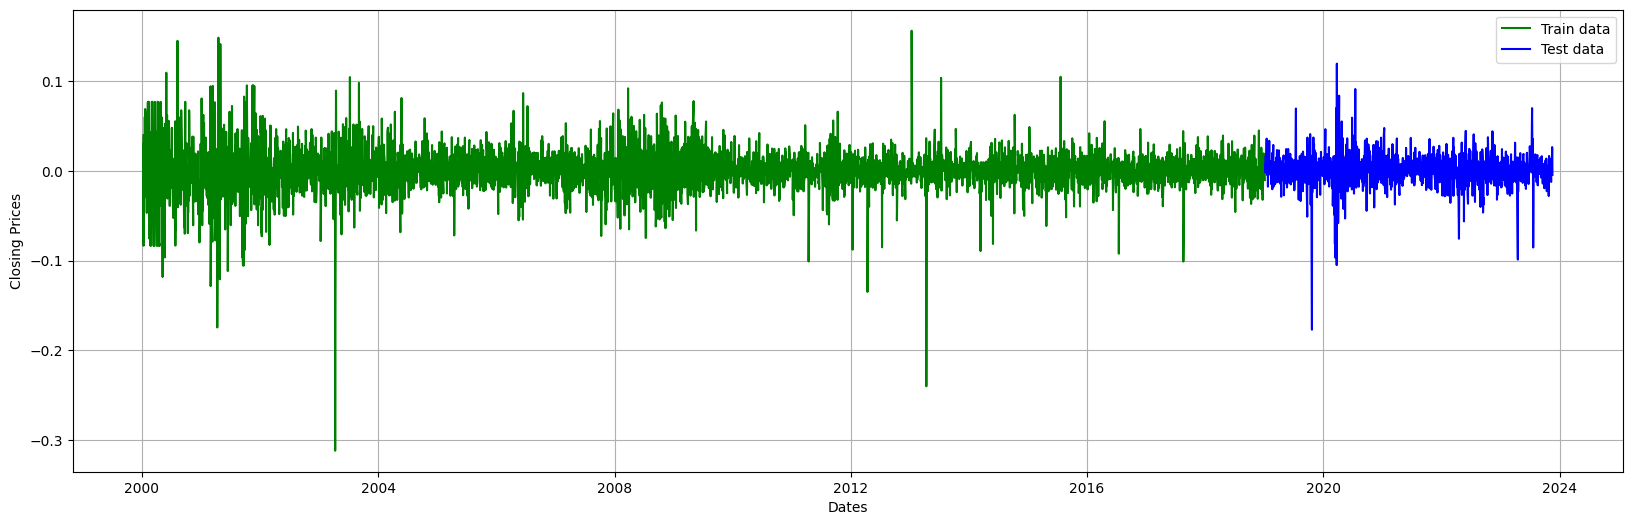

In [113]:
# Split data into train and training set and plotting based on the stationary data
size = 0.8
train_data_boxcox, test_data_boxcox = data_boxcox[3:int(len(data_boxcox)*size)], data_boxcox[int(len(data_boxcox)*size):]
train_data_boxcox_diff, test_data_boxcox_diff = data_boxcox_diff[3:int(len(data_boxcox_diff)*size)], data_boxcox_diff[int(len(data_boxcox_diff)*size):]
plt.figure(figsize=(20,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data_boxcox_diff, 'green', label='Train data')
plt.plot(test_data_boxcox_diff, 'blue', label='Test data')
plt.legend()
plt.show()

### **Building The Time Series Forecasting with Optimal Value using ARIMA** ###

In [114]:
size = 0.8
train_data_boxcox, test_data_boxcox = data_boxcox[:int(len(data_boxcox)*size)], data_boxcox[int(len(data_boxcox)*size):]
train_data_boxcox_diff, test_data_boxcox_diff = data_boxcox_diff[:int(len(data_boxcox_diff)*size)], data_boxcox_diff[int(len(data_boxcox_diff)*size):]

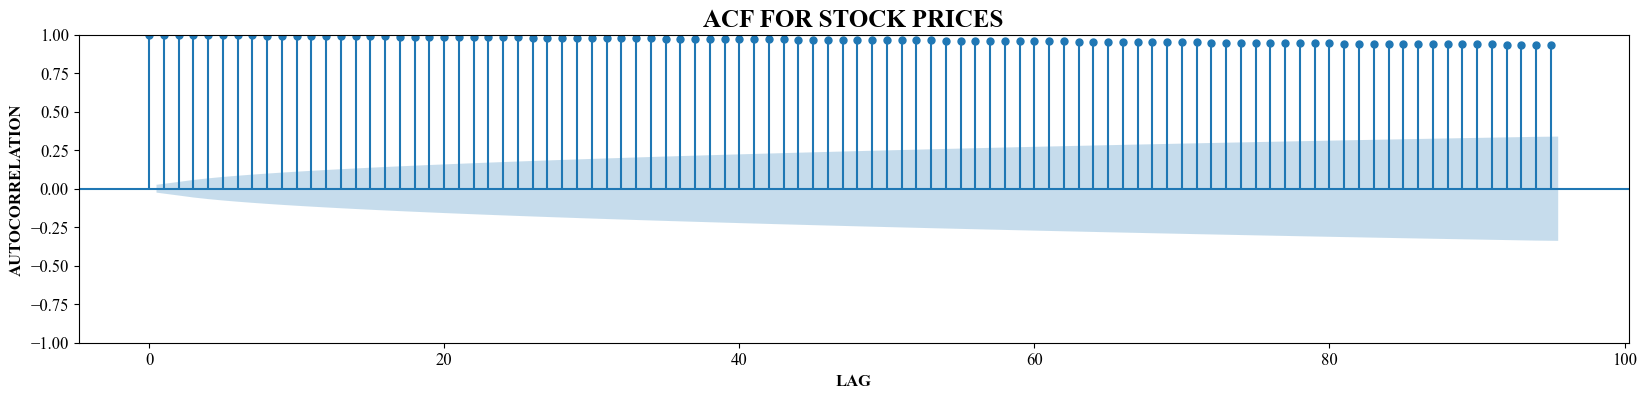

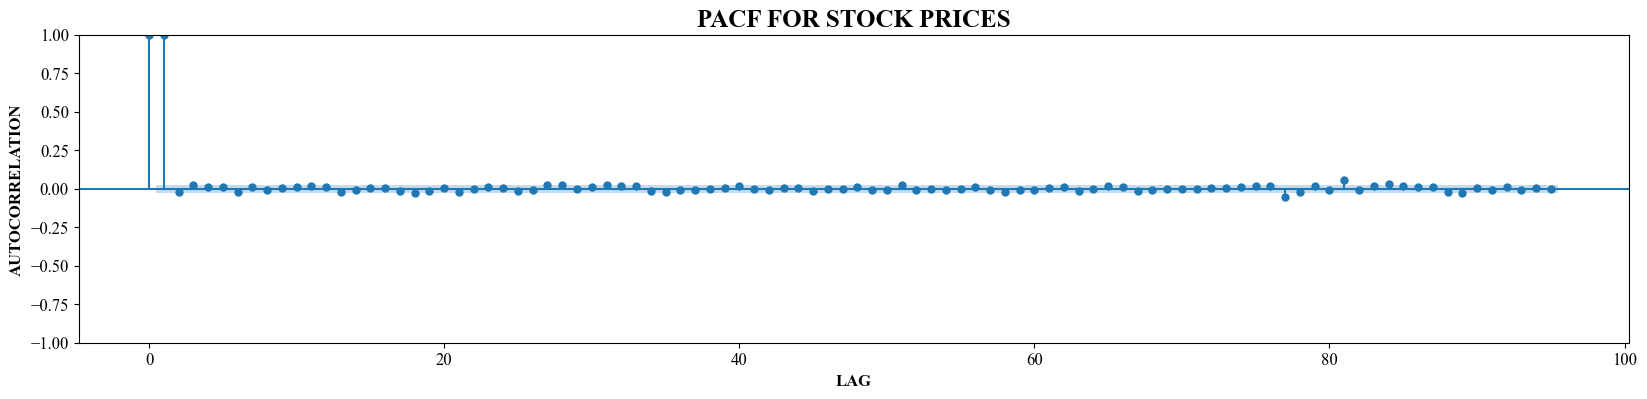

In [115]:
plt.rc("figure", figsize=(20,4))
tsa_plots.plot_acf(stock_data_input["STOCK_PRICE"],lags=95)
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("LAG", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("AUTOCORRELATION", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.title("ACF FOR STOCK PRICES", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.show()

plt.rc("figure", figsize=(20,4))
tsa_plots.plot_pacf(stock_data_input["STOCK_PRICE"],lags=95)
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("LAG", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("AUTOCORRELATION", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.title("PACF FOR STOCK PRICES", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.show()

#### **INFERENCE** ####
- Since the PACF plot has a significant spike at lag p i.e. position 1, but not beyond; the ACF plot decays more gradually.
- Since both conditions match it is always suggested to go for the ARIMA(p, d, 0) model. We will go for ARIMA(2, 0, 0), since d is 0 as the data has been made stationary and no differencing is required.

In [116]:
# Fit the ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train_data_boxcox_diff, order=(2,0,0))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            STOCK_PRICE   No. Observations:                 4736
Model:                 ARIMA(2, 0, 0)   Log Likelihood               10969.243
Date:                Tue, 19 Dec 2023   AIC                         -21930.487
Time:                        01:03:52   BIC                         -21904.635
Sample:                             0   HQIC                        -21921.401
                               - 4736                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.918      0.359      -0.000       0.001
ar.L1          0.0790      0.008     10.449      0.000       0.064       0.094
ar.L2         -0.0483      0.010     -4.995      0.0

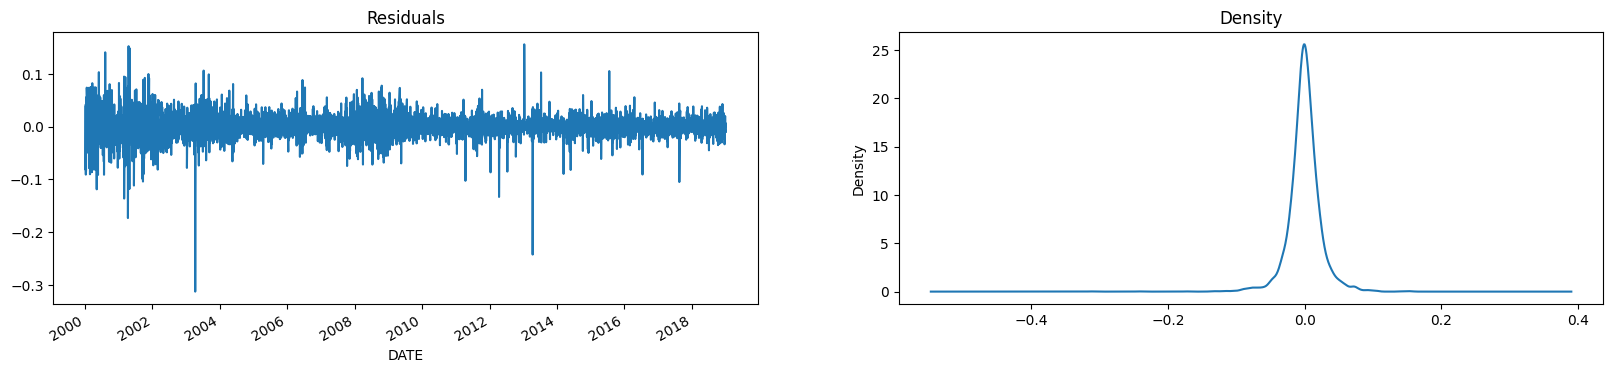

In [117]:
import matplotlib.pyplot as plt
residuals = arima_model_fit.resid[1:]
fig,ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

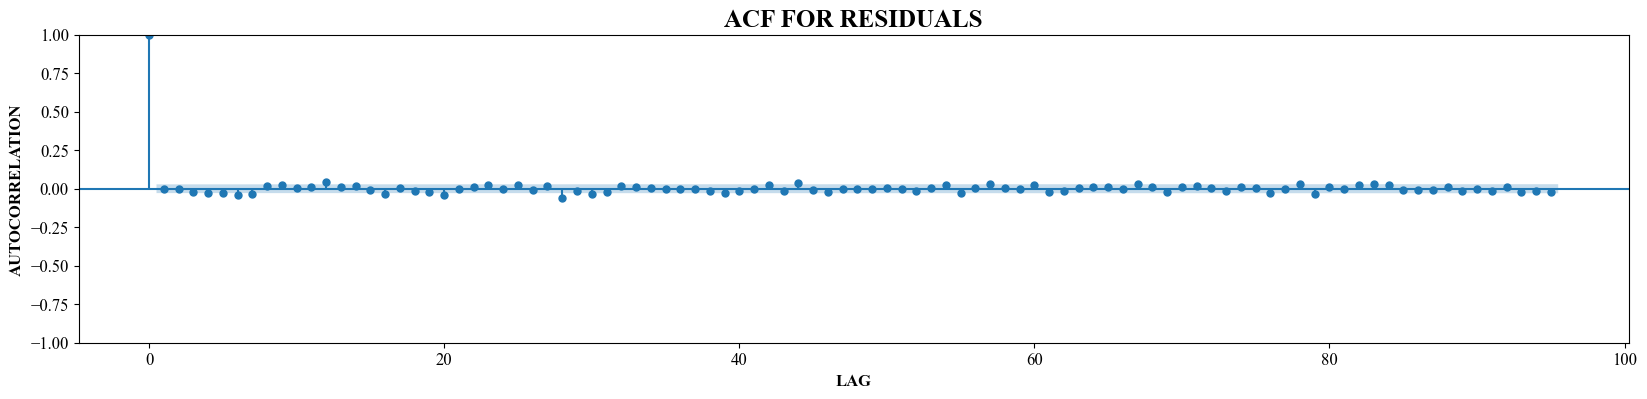

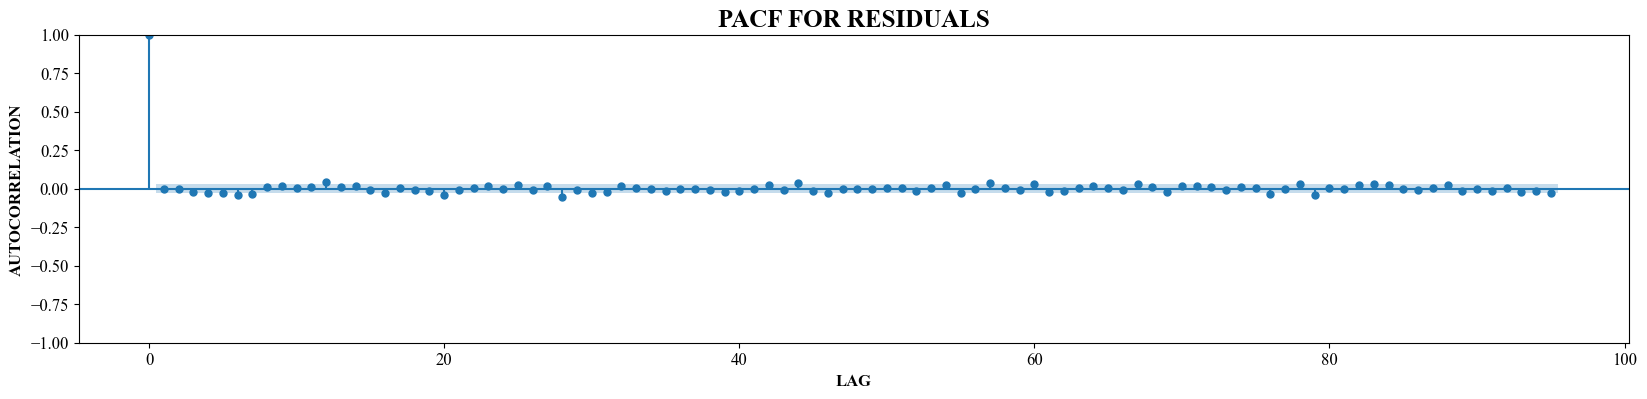

In [118]:
# Plotting ACF and PACF for Residuals

plt.rc("figure", figsize=(20,4))
tsa_plots.plot_acf(residuals,lags=95)
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("LAG", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("AUTOCORRELATION", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.title("ACF FOR RESIDUALS", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.show()

plt.rc("figure", figsize=(20,4))
tsa_plots.plot_pacf(residuals,lags=95)
plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.yticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")
plt.xlabel("LAG", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.ylabel("AUTOCORRELATION", weight='bold', fontfamily = "Times New Roman", size = '12')
plt.title("PACF FOR RESIDUALS", weight='bold', fontfamily = "Times New Roman", size = '18')
plt.show()

#### **INFERENCE** ####
- The residuals show random and density shows a normal distribution around the mean which is an indication of a good model.
- The lower legs barely show any significant spike for both ACF and PACF plots these show that the residuals are close to white noise

In [119]:
# grid search ARIMA parameters for a time series
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    #print("test,train", train, test)
    history = [x for x in train]

    # make predictions
    predictions = list()
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    for t in range(len(test)):
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])    

# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)
    return history, rmse, mape

In [120]:
# Evaluate combinations of p, d and q values for an ARIMA model
dataset = data_boxcox_diff['STOCK_PRICE']
best_score, best_cfg = float('inf'), None
order = (2,0,0)
(history, rmse, mape) = evaluate_arima_model(dataset, order)
rmse_best_score_m, mape_best_score_m, best_cfg_m = rmse, mape, order
print(f'The Best ARIMA:{best_cfg_m} RMSE={rmse_best_score_m} MAPE={mape_best_score_m}')
#history

The Best ARIMA:(2, 0, 0) RMSE=0.0182484048967601 MAPE=12173294760.266973


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21895.805, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-21922.613, Time=0.45 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-21925.309, Time=0.91 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-21927.394, Time=1.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-21936.986, Time=1.00 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-21931.589, Time=0.59 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-21930.157, Time=3.91 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-21928.693, Time=3.58 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-21940.106, Time=4.70 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-21929.906, Time=1.12 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-21931.026, Time=2.55 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-21932.403, Time=1.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-21928.686, Time=4.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-21935.246, Time=9.42 sec

Best

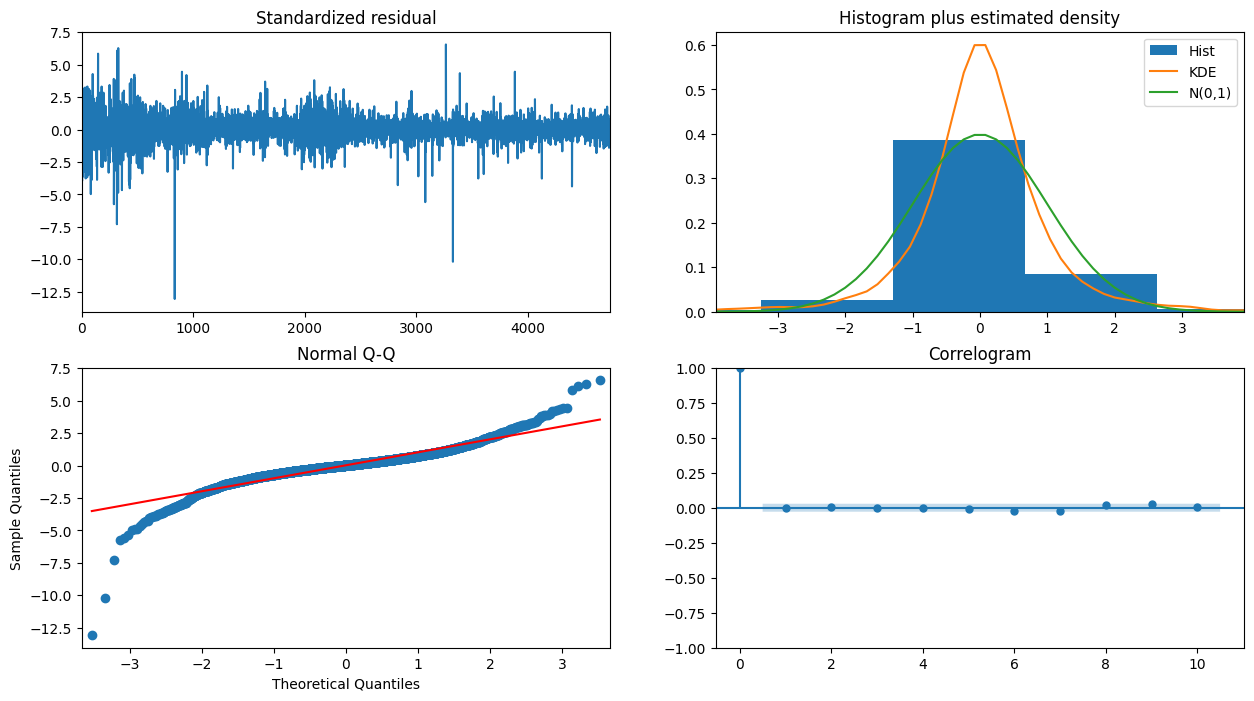

In [121]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train_data_boxcox_diff, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [122]:
import statsmodels.api as smapi
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data_boxcox_diff, order = (1,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            STOCK_PRICE   No. Observations:                 4736
Model:                 ARIMA(1, 0, 2)   Log Likelihood               10972.781
Date:                Tue, 19 Dec 2023   AIC                         -21935.563
Time:                        01:04:43   BIC                         -21903.248
Sample:                             0   HQIC                        -21924.206
                               - 4736                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.083      0.279      -0.000       0.001
ar.L1          0.8607      0.041     21.078      0.000       0.781       0.941
ma.L1         -0.7810      0.041    -19.121      0.0

In [123]:
# Evaluate combinations of p, d and q values for an ARIMA model
dataset = data_boxcox_diff['STOCK_PRICE']
best_score, best_cfg = float('inf'), None
order = (1,0,2)
(history, rmse, mape) = evaluate_arima_model(dataset, order)
rmse_best_score_a, mape_best_score_a, best_cfg_a = rmse, mape, order
print(f'The Best ARIMA:{best_cfg_a} RMSE={rmse_best_score_a} MAPE={mape_best_score_a}')

The Best ARIMA:(1, 0, 2) RMSE=0.018256981081361593 MAPE=17115260913.114716


#### **INFERENCE** ####
- The manually calculated ARIMA(2,0,0) gives higher accuracy than the automated ARIMA(1,0,2)

### **Creating model with different Transformation Technique** ###

In [124]:
# Compareing the results 
Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul","Triple_Exp_multiplicative","ARIMA"
                                #   ,"SARIMA"
                                  ]),
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_best_score_m
                            #  ,mape_sarima
                             ]),
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_best_score_m
                                #  ,rmse_SARIMA
                                 ])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models       MAPE(%)  RMSE_Values
0                      ARIMA  1.217329e+10     0.018248
1          Triple_Exp_mul_ad  2.375550e-01   427.459482
2        Triple_Exp_additive  2.699062e-01   481.590476
3  Triple_Exp_multiplicative  3.823036e-01   663.652045
4         Simple_Exponential  3.952358e-01   681.826063
5         Double_Exponential  4.189458e-01   719.315761
6          Triple_Exp_ad_mul  9.008385e-01  1251.433573

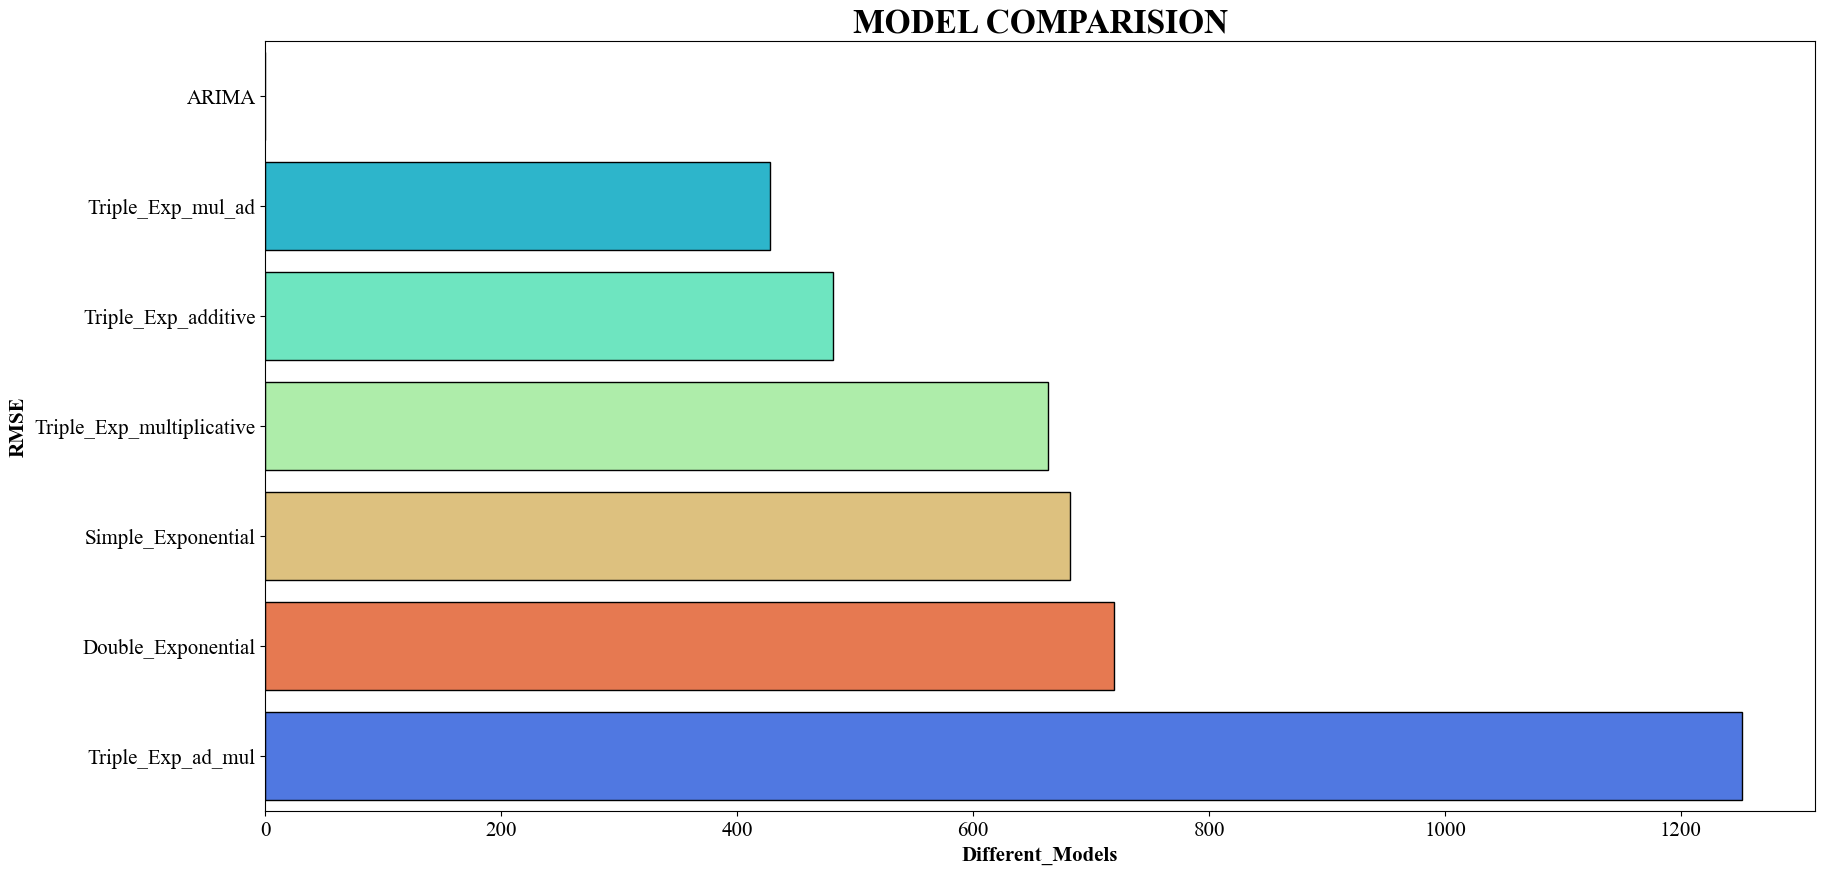

In [125]:
plt.figure(figsize=(20,10))
palette_color = sns.color_palette('rainbow')
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, palette=palette_color, edgecolor="#000000", linewidth=1)
plt.xlabel('Different_Models', rotation=0, fontfamily = "Times New Roman", weight='bold', size = '15')
plt.ylabel('RMSE', rotation=90, fontfamily = "Times New Roman", weight='bold', size = '15')
plt.yticks(rotation = 0, fontfamily = "Times New Roman", size = '15')
plt.xticks(rotation = 0, fontfamily = "Times New Roman", size = '15')
plt.title("MODEL COMPARISION", rotation=0, fontfamily = "Times New Roman", weight='bold', size = '24')
plt.show()

### **Data Pre-processing for Model Driven Techniques** ###

#### ***Creating Dummy Variables of the Categorical Feature Month of Date Time feature*** ####

In [126]:
stockdata = stocks.copy()
stockdata.reset_index(inplace=True)
stockdata['t'] = np.arange(1,len(stockdata)+1)
stockdata['t_squared'] = np.square(stockdata.t)
stockdata["month"] = stockdata.DATE.dt.strftime("%b") # month extraction
stockdata["year"] = stockdata.DATE.dt.strftime("%Y") # year extraction
months = pd.get_dummies(stockdata['month'], dtype=np.int64)
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
stockdata = pd.concat([stockdata,months],axis=1)
stockdata['log_stock_price'] = np.log(stockdata['STOCK_PRICE'])
stockdata

DATE  STOCK_PRICE     t  t_squared month  year  Jan  Feb  Mar  Apr  \
0    2000-01-04   132.110931     1          1   Jan  2000    1    0    0    0   
1    2000-01-05   121.542191     2          4   Jan  2000    1    0    0    0   
2    2000-01-06   111.819138     3          9   Jan  2000    1    0    0    0   
3    2000-01-07   102.873825     4         16   Jan  2000    1    0    0    0   
4    2000-01-10   107.031250     5         25   Jan  2000    1    0    0    0   
...         ...          ...   ...        ...   ...   ...  ...  ...  ...  ...   
5916 2023-11-10  1368.699951  5917   35010889   Nov  2023    0    0    0    0   
5917 2023-11-13  1374.150024  5918   35022724   Nov  2023    0    0    0    0   
5918 2023-11-15  1411.150024  5919   35034561   Nov  2023    0    0    0    0   
5919 2023-11-16  1443.900024  5920   35046400   Nov  2023    0    0    0    0   
5920 2023-11-17  1437.650024  5921   35058241   Nov  2023    0    0    0    0   

      May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_stock_price  
0       0    0    0    0    0    0    0    0         4.883642  
1       0    0    0    0    0    0    0    0         4.800261  
2       0    0    0    0    0    0    0    0         4.716883  
3       0    0    0    0    0    0    0    0         4.633503  
4       0    0    0    0    0    0    0    0         4.673121  
...   ...  ...  ...  ...  ...  ...  ...  ...              ...  
5916    0    0    0    0    0    0    1    0         7.221617  
5917    0    0    0    0    0    0    1    0         7.225591  
5918    0    0    0    0    0    0    1    0         7.252160  
5919    0    0    0    0    0    0    1    0         7.275103  
5920    0    0    0    0    0    0    1    0         7.270765  

[5921 rows x 19 columns]

### ***Splitting data into Train and Test*** ###

In [127]:
size = 0.8
train_data, test_data = stockdata[3:int(len(stockdata)*size)], stockdata[int(len(stockdata)*size):]
# train_data = stockdata.iloc[:size]
# test_data = stockdata.iloc[size:]

In [128]:
train_data

DATE  STOCK_PRICE     t  t_squared month  year  Jan  Feb  Mar  Apr  \
3    2000-01-07   102.873825     4         16   Jan  2000    1    0    0    0   
4    2000-01-10   107.031250     5         25   Jan  2000    1    0    0    0   
5    2000-01-11    98.469139     6         36   Jan  2000    1    0    0    0   
6    2000-01-12   101.570313     7         49   Jan  2000    1    0    0    0   
7    2000-01-13    93.953514     8         64   Jan  2000    1    0    0    0   
...         ...          ...   ...        ...   ...   ...  ...  ...  ...  ...   
4731 2018-12-28   657.599976  4732   22391824   Dec  2018    0    0    0    0   
4732 2018-12-31   659.849976  4733   22401289   Dec  2018    0    0    0    0   
4733 2019-01-01   664.650024  4734   22410756   Jan  2019    1    0    0    0   
4734 2019-01-02   669.299988  4735   22420225   Jan  2019    1    0    0    0   
4735 2019-01-03   667.549988  4736   22429696   Jan  2019    1    0    0    0   

      May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_stock_price  
3       0    0    0    0    0    0    0    0         4.633503  
4       0    0    0    0    0    0    0    0         4.673121  
5       0    0    0    0    0    0    0    0         4.589743  
6       0    0    0    0    0    0    0    0         4.620751  
7       0    0    0    0    0    0    0    0         4.542800  
...   ...  ...  ...  ...  ...  ...  ...  ...              ...  
4731    0    0    0    0    0    0    0    1         6.488597  
4732    0    0    0    0    0    0    0    1         6.492013  
4733    0    0    0    0    0    0    0    0         6.499261  
4734    0    0    0    0    0    0    0    0         6.506232  
4735    0    0    0    0    0    0    0    0         6.503614  

[4733 rows x 19 columns]

In [129]:
test_data

DATE  STOCK_PRICE     t  t_squared month  year  Jan  Feb  Mar  Apr  \
4736 2019-01-04   660.750000  4737   22439169   Jan  2019    1    0    0    0   
4737 2019-01-07   671.150024  4738   22448644   Jan  2019    1    0    0    0   
4738 2019-01-08   669.849976  4739   22458121   Jan  2019    1    0    0    0   
4739 2019-01-09   675.849976  4740   22467600   Jan  2019    1    0    0    0   
4740 2019-01-10   679.750000  4741   22477081   Jan  2019    1    0    0    0   
...         ...          ...   ...        ...   ...   ...  ...  ...  ...  ...   
5916 2023-11-10  1368.699951  5917   35010889   Nov  2023    0    0    0    0   
5917 2023-11-13  1374.150024  5918   35022724   Nov  2023    0    0    0    0   
5918 2023-11-15  1411.150024  5919   35034561   Nov  2023    0    0    0    0   
5919 2023-11-16  1443.900024  5920   35046400   Nov  2023    0    0    0    0   
5920 2023-11-17  1437.650024  5921   35058241   Nov  2023    0    0    0    0   

      May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_stock_price  
4736    0    0    0    0    0    0    0    0         6.493376  
4737    0    0    0    0    0    0    0    0         6.508993  
4738    0    0    0    0    0    0    0    0         6.507054  
4739    0    0    0    0    0    0    0    0         6.515971  
4740    0    0    0    0    0    0    0    0         6.521725  
...   ...  ...  ...  ...  ...  ...  ...  ...              ...  
5916    0    0    0    0    0    0    1    0         7.221617  
5917    0    0    0    0    0    0    1    0         7.225591  
5918    0    0    0    0    0    0    1    0         7.252160  
5919    0    0    0    0    0    0    1    0         7.275103  
5920    0    0    0    0    0    0    1    0         7.270765  

[1185 rows x 19 columns]

### ***Building Ordinary Square Model (Linear Model)*** ###

In [130]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('STOCK_PRICE~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = sqrt(mean_squared_error(test_data.STOCK_PRICE, pred_linear))
mape_linear = mean_absolute_percentage_error(test_data.STOCK_PRICE, pred_linear)
print(f"Root Mean Square Error (RMSE) for Exponential: {np.round(rmse_linear,2)}\nMean Absolute Percentage Error (MAPE) for Exponential: {np.round(mape_linear,2)}\n")

Root Mean Square Error (RMSE) for Exponential: 675.83
Mean Absolute Percentage Error (MAPE) for Exponential: 0.42



In [131]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            STOCK_PRICE   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                 3.779e+04
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:04:59   Log-Likelihood:                -26068.
No. Observations:                4733   AIC:                         5.214e+04
Df Residuals:                    4731   BIC:                         5.215e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.9090      1.737     -4.553      0.000     -11.314      -4.504
t              0.1234      0.001    194.407      0.000       0.122       0.125
==============================================================================
Omnibus:                      114.392   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.199
Skew:                           0.391   Prob(JB):                     2.92e-27
Kurtosis:                       2.908   Cond. No.                     5.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [132]:
# Exponential

Exp = smf.ols('log_stock_price~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = sqrt(mean_squared_error(test_data.STOCK_PRICE, pred_Exp))
mape_Exp = mean_absolute_percentage_error(test_data.STOCK_PRICE, pred_Exp)
print(f"Root Mean Square Error (RMSE) for Exponential: {np.round(rmse_Exp,2)}\nMean Absolute Percentage Error (MAPE) for Exponential: {np.round(mape_Exp,2)}\n")

Root Mean Square Error (RMSE) for Exponential: 1278.49
Mean Absolute Percentage Error (MAPE) for Exponential: 0.99



In [133]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_stock_price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 2.657e+04
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:04:59   Log-Likelihood:                -1055.4
No. Observations:                4733   AIC:                             2115.
Df Residuals:                    4731   BIC:                             2128.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1523      0.009    471.676      0.000       4.135       4.170
t              0.0005   3.22e-06    163.016      0.000       0.001       0.001
==============================================================================
Omnibus:                        2.817   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.244   Jarque-Bera (JB):                2.956
Skew:                          -0.002   Prob(JB):                        0.228
Kurtosis:                       3.122   Cond. No.                     5.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [134]:
# Quadratic 

Quad = smf.ols('STOCK_PRICE~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = sqrt(mean_squared_error(test_data.STOCK_PRICE, pred_Quad))
mape_Quad = mean_absolute_percentage_error(test_data.STOCK_PRICE, pred_Quad)
print(f"Root Mean Square Error (RMSE) for Exponential: {np.round(rmse_Quad,2)}\nMean Absolute Percentage Error (MAPE) for Exponential: {np.round(mape_Quad,2)}\n")

Root Mean Square Error (RMSE) for Exponential: 567.06
Mean Absolute Percentage Error (MAPE) for Exponential: 0.33



In [135]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            STOCK_PRICE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 2.459e+04
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:04:59   Log-Likelihood:                -25506.
No. Observations:                4733   AIC:                         5.102e+04
Df Residuals:                    4730   BIC:                         5.104e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.7161      2.318     23.171      0.000      49.171      58.261
t              0.0455      0.002     20.165      0.000       0.041       0.050
t_squared   1.643e-05   4.61e-07     35.612      0.000    1.55e-05    1.73e-05
==============================================================================
Omnibus:                      203.987   Durbin-Watson:                   0.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.750
Skew:                           0.093   Prob(JB):                     1.97e-20
Kurtosis:                       2.347   Cond. No.                     3.02e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [136]:
# Additive seasonality 

add_sea = smf.ols('STOCK_PRICE~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = sqrt(mean_squared_error(test_data['STOCK_PRICE'], pred_add_sea))
mape_add_sea = mean_absolute_percentage_error(test_data['STOCK_PRICE'], pred_add_sea)
print(f"Root Mean Square Error (RMSE) for Additive Seasonality: {np.round(rmse_add_sea,2)}\nMean Absolute Percentage Error (MAPE) for Additive Seasonality: {np.round(mape_add_sea,2)}\n")

Root Mean Square Error (RMSE) for Additive Seasonality: 1016.98
Mean Absolute Percentage Error (MAPE) for Additive Seasonality: 0.74



In [137]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            STOCK_PRICE   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7807
Date:                Tue, 19 Dec 2023   Prob (F-statistic):              0.660
Time:                        01:04:59   Log-Likelihood:                -31261.
No. Observations:                4733   AIC:                         6.255e+04
Df Residuals:                    4721   BIC:                         6.262e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.375e+13    2.7e+14      0.162      0.871   -4.85e+14    5.72e+14
Jan        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
Feb        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
Mar        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
Apr        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
May        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
Jun        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
Jul        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
Aug        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
Sep        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
Oct        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
Nov        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
Dec        -4.375e+13    2.7e+14     -0.162      0.871   -5.72e+14    4.85e+14
==============================================================================
Omnibus:                      819.786   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              299.766
Skew:                           0.413   Prob(JB):                     8.07e-66
Kurtosis:                       2.084   Cond. No.                     3.89e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.39e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [138]:
# Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('STOCK_PRICE~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = sqrt(mean_squared_error(test_data['STOCK_PRICE'], pred_add_sea_quad))
mape_add_sea_quad = mean_absolute_percentage_error(test_data['STOCK_PRICE'], pred_add_sea_quad)
print(f"Root Mean Square Error (RMSE) for Additive Seasonality: {np.round(rmse_add_sea_quad,2)}\nMean Absolute Percentage Error (MAPE) for Additive Seasonality: {np.round(mape_add_sea_quad,2)}\n")

Root Mean Square Error (RMSE) for Additive Seasonality: 566.54
Mean Absolute Percentage Error (MAPE) for Additive Seasonality: 0.33



In [139]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            STOCK_PRICE   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     3834.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:05:00   Log-Likelihood:                -25472.
No. Observations:                4733   AIC:                         5.097e+04
Df Residuals:                    4719   BIC:                         5.106e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.4428      2.128     23.235      0.000      45.271      53.615
t              0.0457      0.002     20.338      0.000       0.041       0.050
t_squared   1.642e-05   4.59e-07     35.804      0.000    1.55e-05    1.73e-05
Jan           10.4251      2.534      4.113      0.000       5.456      15.394
Feb           15.5466      2.605      5.969      0.000      10.440      20.653
Mar           14.9580      2.541      5.888      0.000       9.977      19.939
Apr            0.8505      2.628      0.324      0.746      -4.301       6.002
May           -5.1068      2.503     -2.040      0.041     -10.015      -0.199
Jun           -1.9602      2.516     -0.779      0.436      -6.893       2.973
Jul           -2.3131      2.489     -0.929      0.353      -7.193       2.567
Aug            1.5842      2.516      0.630      0.529      -3.348       6.517
Sep            2.4899      2.559      0.973      0.331      -2.527       7.507
Oct            4.0474      2.572      1.574      0.116      -0.995       9.090
Nov            2.8578      2.582      1.107      0.268      -2.205       7.920
Dec            6.0635      2.528      2.398      0.017       1.107      11.020
==============================================================================
Omnibus:                      240.415   Durbin-Watson:                   0.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.907
Skew:                           0.071   Prob(JB):                     5.49e-22
Kurtosis:                       2.310   Cond. No.                     4.05e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.9e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [140]:
# Multiplicative Seasonality

Mul_sea = smf.ols('log_stock_price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = sqrt(mean_squared_error(test_data['STOCK_PRICE'], pred_Mult_sea))
mape_Mult_sea = mean_absolute_percentage_error(test_data['STOCK_PRICE'], pred_Mult_sea)
print(f"Root Mean Square Error (RMSE) for Additive Seasonality: {np.round(rmse_Mult_sea,2)}\nMean Absolute Percentage Error (MAPE) for Additive Seasonality: {np.round(mape_Mult_sea,2)}\n")

Root Mean Square Error (RMSE) for Additive Seasonality: 1280.02
Mean Absolute Percentage Error (MAPE) for Additive Seasonality: 1.0



In [141]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_stock_price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.043
Date:                Tue, 19 Dec 2023   Prob (F-statistic):              0.405
Time:                        01:05:00   Log-Likelihood:                -5521.5
No. Observations:                4733   AIC:                         1.107e+04
Df Residuals:                    4721   BIC:                         1.114e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.233e+11   1.17e+12      0.191      0.849   -2.07e+12    2.52e+12
Jan        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
Feb        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
Mar        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
Apr        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
May        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
Jun        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
Jul        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
Aug        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
Sep        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
Oct        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
Nov        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
Dec        -2.233e+11   1.17e+12     -0.191      0.849   -2.52e+12    2.07e+12
==============================================================================
Omnibus:                      983.825   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              367.986
Skew:                          -0.492   Prob(JB):                     1.24e-80
Kurtosis:                       2.053   Cond. No.                     3.89e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.39e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [142]:
# Multiplicative Additive Seasonality 
Mul_Add_sea = smf.ols('log_stock_price~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = sqrt(mean_squared_error(test_data['STOCK_PRICE'], pred_Mult_add_sea))
mape_Mult_add_sea = mean_absolute_percentage_error(test_data['STOCK_PRICE'], pred_Mult_add_sea)
print(f"Root Mean Square Error (RMSE) for Additive Seasonality: {np.round(rmse_Mult_add_sea,2)}\nMean Absolute Percentage Error (MAPE) for Additive Seasonality: {np.round(mape_Mult_add_sea,2)}\n")

Root Mean Square Error (RMSE) for Additive Seasonality: 1278.49
Mean Absolute Percentage Error (MAPE) for Additive Seasonality: 0.99



In [143]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_stock_price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     2247.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:05:00   Log-Likelihood:                -1021.7
No. Observations:                4733   AIC:                             2069.
Df Residuals:                    4720   BIC:                             2153.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8323      0.008    474.087      0.000       3.816       3.848
t              0.0005    3.2e-06    163.956      0.000       0.001       0.001
Jan            0.3644      0.014     25.224      0.000       0.336       0.393
Feb            0.3878      0.015     26.122      0.000       0.359       0.417
Mar            0.3702      0.014     25.574      0.000       0.342       0.399
Apr            0.2941      0.015     19.638      0.000       0.265       0.323
May            0.2759      0.014     19.339      0.000       0.248       0.304
Jun            0.2882      0.014     20.102      0.000       0.260       0.316
Jul            0.2827      0.014     19.934      0.000       0.255       0.310
Aug            0.3004      0.014     20.948      0.000       0.272       0.328
Sep            0.3057      0.015     20.971      0.000       0.277       0.334
Oct            0.2979      0.015     20.318      0.000       0.269       0.327
Nov            0.3248      0.015     22.066      0.000       0.296       0.354
Dec            0.3401      0.014     23.611      0.000       0.312       0.368
==============================================================================
Omnibus:                        0.453   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.797   Jarque-Bera (JB):                0.495
Skew:                           0.016   Prob(JB):                        0.781
Kurtosis:                       2.962   Cond. No.                     9.92e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.6e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [144]:
np.exp(pred_Mult_add_sea)
test_pred_mul_ad_texp

DATE
2019-01-04     668.594078
2019-01-07     667.975850
2019-01-08     671.234512
2019-01-09     670.478015
2019-01-10     672.901069
                 ...     
2023-11-10    1156.558587
2023-11-13    1152.265062
2023-11-15    1151.142910
2023-11-16    1149.571552
2023-11-17    1148.808706
Length: 1185, dtype: float64

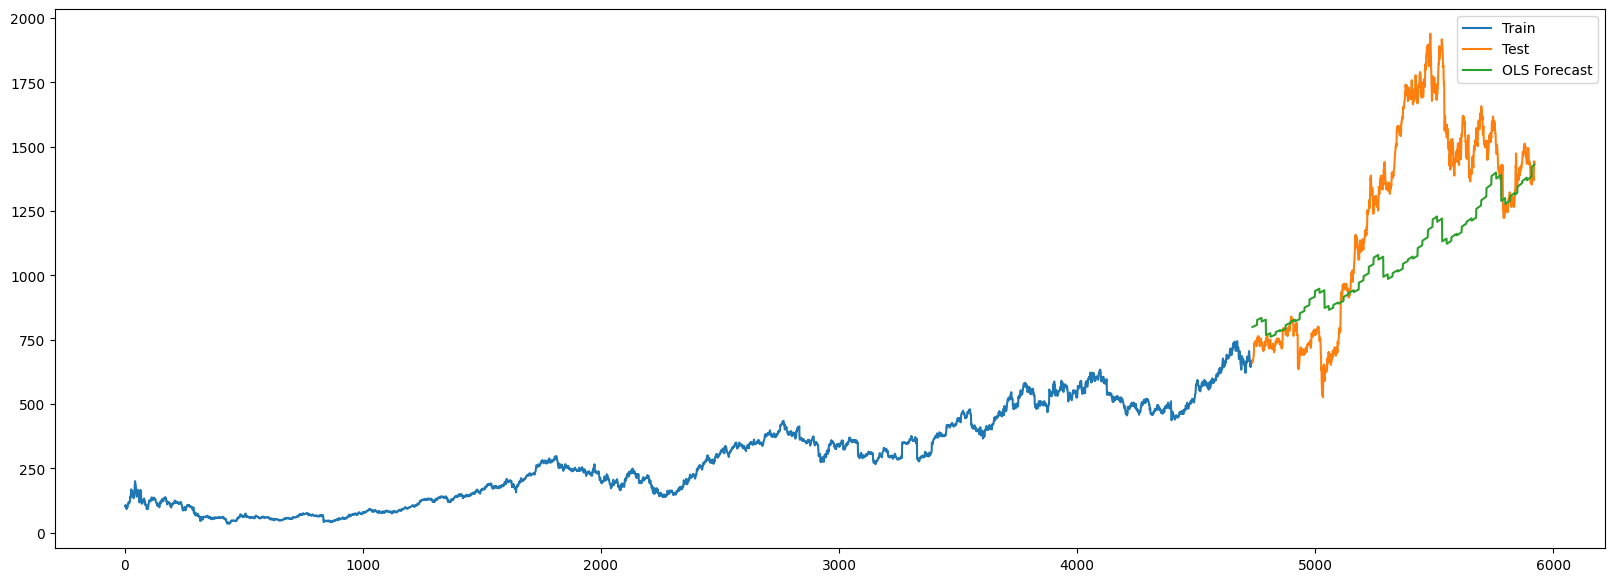

In [145]:
plt.figure(figsize=(20,7))
plt.plot(train_data['STOCK_PRICE'], label='Train')
plt.plot(test_data['STOCK_PRICE'], label='Test')
plt.plot(np.exp(pred_Mult_add_sea), label='OLS Forecast')
plt.legend(loc='best')
plt.show()

In [146]:
# Compare the results

data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
"MAPE(%)":pd.Series([mape_linear,mape_Exp,mape_Quad,mape_add_sea,mape_add_sea_quad,mape_Mult_sea,mape_Mult_add_sea]),
"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])
}
table_evaluation_2=pd.DataFrame(data)
table_evaluation_2.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [147]:
table_evaluation_2

Models   MAPE(%)  RMSE_Values
0  rmse_add_sea_quad  0.327145   566.543419
1          rmse_Quad  0.327555   567.061777
2        rmse_linear  0.416439   675.829170
3       rmse_add_sea  0.739321  1016.980725
4  rmse_Mult_add_sea  0.993673  1278.489078
5           rmse_Exp  0.993674  1278.491197
6      rmse_Mult_sea  0.995054  1280.015335

In [148]:
table_evaluation

Models       MAPE(%)  RMSE_Values
0                      ARIMA  1.217329e+10     0.018248
1          Triple_Exp_mul_ad  2.375550e-01   427.459482
2        Triple_Exp_additive  2.699062e-01   481.590476
3  Triple_Exp_multiplicative  3.823036e-01   663.652045
4         Simple_Exponential  3.952358e-01   681.826063
5         Double_Exponential  4.189458e-01   719.315761
6          Triple_Exp_ad_mul  9.008385e-01  1251.433573

In [149]:
table_evaluation_2

Models   MAPE(%)  RMSE_Values
0  rmse_add_sea_quad  0.327145   566.543419
1          rmse_Quad  0.327555   567.061777
2        rmse_linear  0.416439   675.829170
3       rmse_add_sea  0.739321  1016.980725
4  rmse_Mult_add_sea  0.993673  1278.489078
5           rmse_Exp  0.993674  1278.491197
6      rmse_Mult_sea  0.995054  1280.015335

In [150]:
mod_comp = pd.DataFrame()
mod_comp = table_evaluation.copy()
mod_comp = pd.concat([mod_comp, table_evaluation_2])
mod_comp.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

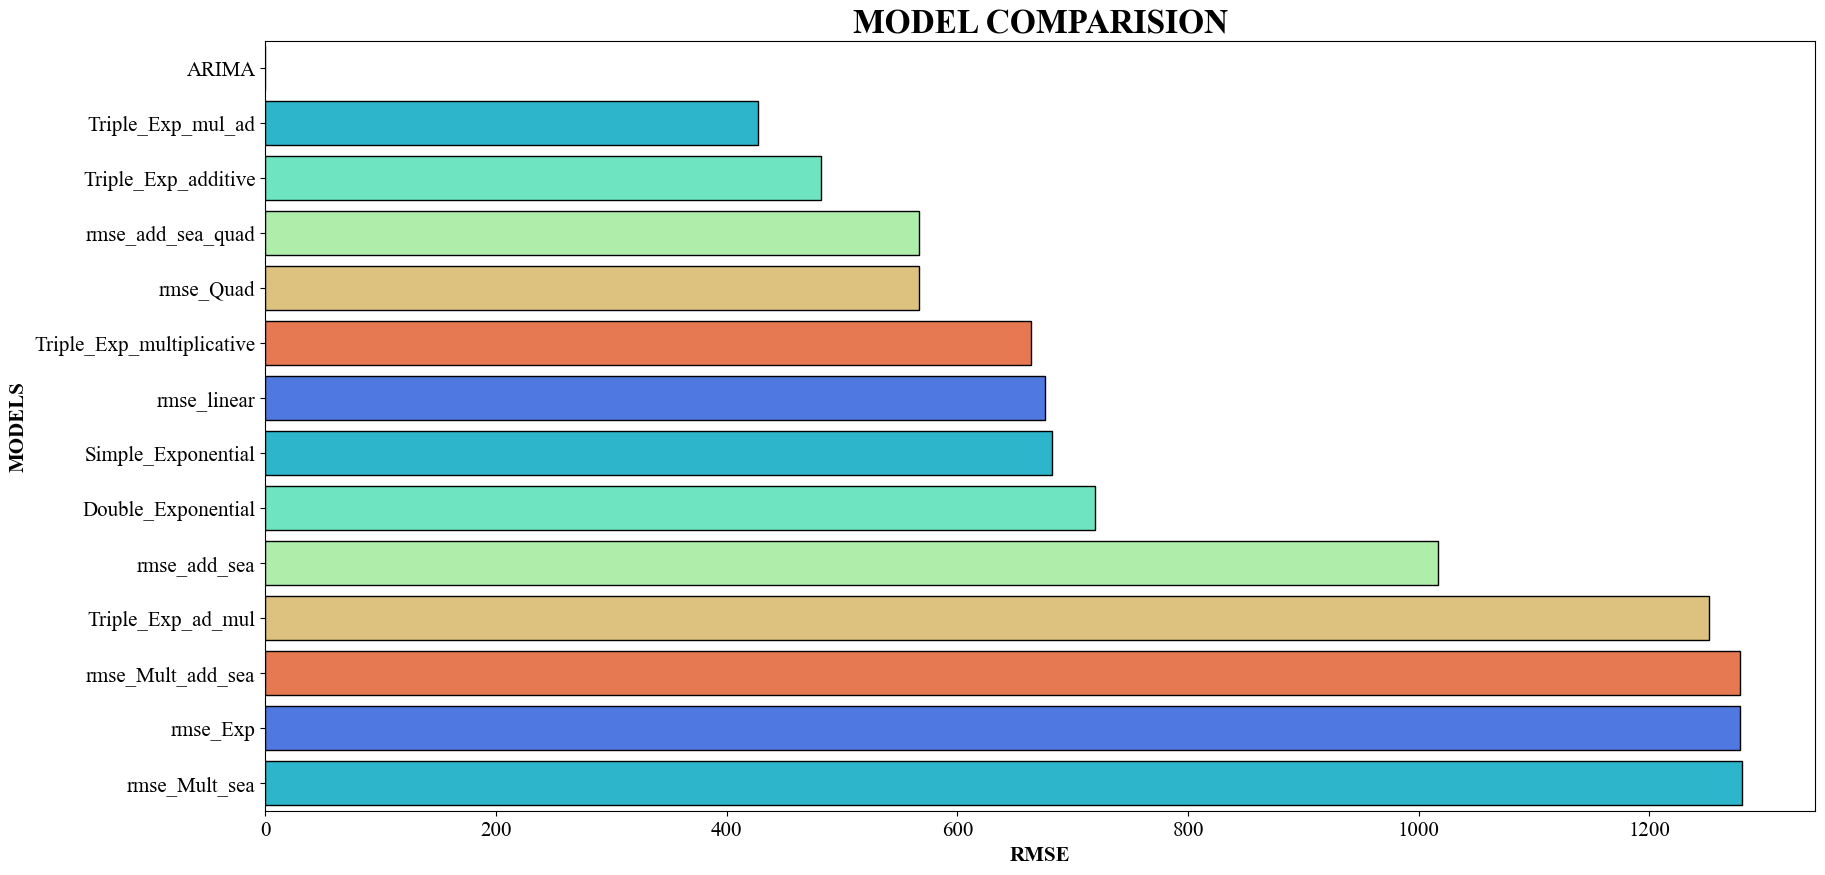

In [151]:
# Creating a chart with the Feature Score
plt.figure(figsize=(20,10))

# Creating the barplot for RMSE
palette_color = sns.color_palette('rainbow')
sns.barplot(x='RMSE_Values', y="Models", data=mod_comp, palette=palette_color, edgecolor="#000000", linewidth=1,)

# Setting labels, title and other paraments
plt.xlabel("RMSE", rotation=0, fontfamily = "Times New Roman", weight='bold', size = '15')
plt.ylabel("MODELS", rotation=90, fontfamily = "Times New Roman", weight='bold', size = '15')
plt.yticks(rotation = 0, fontfamily = "Times New Roman", size = '15')
plt.xticks(rotation = 0, fontfamily = "Times New Roman", size = '15')
plt.title("MODEL COMPARISION", rotation=0, fontfamily = "Times New Roman", weight='bold', size = '24')
plt.show()

##### **CONCLUSION** #####

The best model is 'ARIMA', which gives us the lowest Root Mean Squared Error (RMSE) and lowest Mean Absolute Percentage Error (MAPE).